In [1]:
# Suppress warnings

import warnings
warnings.simplefilter('ignore')

import pyrcel as pm
import numpy as np
import matplotlib.pyplot as plt

In [2]:
"""
Making the code into a function so that the number concentration at peak supersaturation can be output as a function of input parameters 
(including particle properties and contrail mixing properties)
"""

from pyrcel import binned_activation

# Functions for estimating the saturation ratio

def es(T): # pyrcel implementation of es(T)
    return 611.2 * np.exp(17.67 * T / (T + 243.5)) 

def p_i_0(T): # ice saturation
    
    return np.exp(9.550426 - 5723.265/T + 3.53068 * np.log(T) - 0.00728332*T) 

def p_mw(T, T_a): # water vapour pressure along the contrail mixing line 
        
    p_wa = p_i_0(T_a) * 1.1 # assume the mixing line terminates with a water vapour partial pressure = ice saturation
                    
    return p_wa + 1.64 * (T - T_a) 

def Smw(T, T_a): 
        return p_mw(T, T_a)/es(T-273.15)

# Function for estimating the droplet number concentration

def n_droplets(T_a, T_e, P0, 
               n_ambient, GMD_ambient, GSD_ambient, kappa_ambient, bins_ambient, 
               EI_vPM, GMD_vPM, GSD_vPM, kappa_vPM, bins_vPM,
               EI_nvPM, GMD_nvPM, GSD_nvPM, kappa_nvPM, bins_nvPM,
               T_start, dt, t_end, RHi, G):

    # Define the supersaturation at the initial model temperature

    S0 = Smw(T_start, T_a) - 1 # water supersaturation at initial model temperature / K 

    # Initialise particle modes, note that mu = GRD of mode in micrometers

    N0_nvPM = (EI_nvPM * (P0 * 28.96e-3) / (8.3145 * T_e)) / 60 / 1e6 # initial number concentration of soot particles, particles per cm^3
    N0_vPM = (EI_vPM * (P0 * 28.96e-3) / (8.3145 * T_e)) / 60 / 1e6 # initial number concentration of soot particles, particles per cm^3

    ambient =  pm.AerosolSpecies('ambient',
                                pm.Lognorm(mu=GMD_ambient * 0.5e6, sigma=GSD_ambient, N=n_ambient),
                                kappa=kappa_ambient, bins=int(bins_ambient))
                                
    vPM =  pm.AerosolSpecies('vPM',
                                pm.Lognorm(mu=GMD_vPM * 0.5e6, sigma=GSD_vPM, N=N0_vPM),
                                kappa=kappa_vPM, bins=int(bins_vPM))

    nvPM =  pm.AerosolSpecies('nvPM',
                                pm.Lognorm(mu=GMD_nvPM * 0.5e6, sigma=GSD_nvPM, N=N0_nvPM),
                                kappa=kappa_nvPM, bins=int(bins_nvPM))                              

    initial_aerosols = [vPM, nvPM, ambient]

    # Model initialisation and calculation

    model = pm.ParcelModel(initial_aerosols, np.array([T_a, P0, RHi, G, T_e]), T_start, S0, P0, console=False, accom=1.0, truncate_aerosols=True) # array for Ta gives room for any parameters to be passed into the model i.e., 

    parcel_trace, aerosol_traces = model.run(t_end, dt, solver='cvode')

    # Maximum supersaturation

    S_max = np.max(parcel_trace['S']) * 100 # maximum plume supersaturation achieved / %
    idxmax = np.argmax(parcel_trace['S']) # index of above

    "recent"

    T_of_interest = 230
    T_x = np.argmin(np.abs(parcel_trace['T'] - 230))

    nvPM_trace = aerosol_traces['nvPM']
    vPM_trace = aerosol_traces['vPM']
    ambient_trace = aerosol_traces['ambient']

    max_n_vPM = binned_activation(parcel_trace['S'].iloc[T_x], parcel_trace['T'].iloc[T_x], vPM_trace.iloc[T_x],  vPM, T_a, P0, T_e) # activated fractions at maximum supersaturation
    max_n_nvPM = binned_activation(parcel_trace['S'].iloc[T_x], parcel_trace['T'].iloc[T_x], nvPM_trace.iloc[T_x],  nvPM, T_a, P0, T_e) # activated fractions at maximum supersaturation
    max_n_ambient = binned_activation(parcel_trace['S'].iloc[T_x], parcel_trace['T'].iloc[T_x], ambient_trace.iloc[T_x],  ambient, T_a, P0, T_e) # activated fractions at maximum supersaturation

    max_n_total = (max_n_nvPM + max_n_vPM + max_n_ambient)
    
    "former"

    # nvPM_trace = aerosol_traces['nvPM']
    # vPM_trace = aerosol_traces['vPM']
    # ambient_trace = aerosol_traces['ambient']

    # max_n_vPM = binned_activation(parcel_trace['S'].iloc[-1], parcel_trace['T'].iloc[-1], vPM_trace.iloc[-1],  vPM, T_a) # activated fractions at maximum supersaturation
    # max_n_nvPM = binned_activation(parcel_trace['S'].iloc[-1], parcel_trace['T'].iloc[-1], nvPM_trace.iloc[-1],  nvPM, T_a) # activated fractions at maximum supersaturation
    # max_n_ambient = binned_activation(parcel_trace['S'].iloc[-1], parcel_trace['T'].iloc[-1], ambient_trace.iloc[-1],  ambient, T_a) # activated fractions at maximum supersaturation

    # max_n_total = (max_n_nvPM + max_n_vPM + max_n_ambient)

    # return S_max
    return parcel_trace, aerosol_traces # for most
    # return max_n_nvPM/max_n_total * 100
    # return max_n_total

In [3]:
# plotting a single mixing profile (1/Y)

# Define contrail properties

T_a = 215.00 # ambient temperature / K
T_e = 600.0 # exhaust temperature
P0 = 22919.5 # (cruise) pressure, Pa 

RHi = 1.1 # ice saturation ratio 
G = 1.64 # contrail mixing line gradient

# Define particle properties

n_ambient = 600 # number concentration of ambient particles / cm^-3
EI_nvPM = 1e15 # emission index of nvPM particles, particles per kg of fuel burned
EI_vPM = 1e17 # emission index of vPM particles, particles per kg of fuel burned

GMD_ambient, GSD_ambient, kappa_ambient = 30.0e-9, 2.2, 0.500001 # must specify the ambient mode with this kappa value otherwise the code will fail
GMD_nvPM, GSD_nvPM, kappa_nvPM = 35e-9, 2.0, 0.005
GMD_vPM, GSD_vPM, kappa_vPM = 2.5e-09, 1.3, 0.5
bins_nvPM, bins_ambient, bins_vPM = 50, 50, 100

# Define model properties

T_start = 270.0 # initial model (not the ambient temperature) temperature / K
dt = 1e-4 # timestep / s
t_end = 1 # end time / s

# Call the model (returns maximum supersaturation as % and effective emission index of ice as particles per kg-fuel)

parcel_trace, aerosol_traces = n_droplets(T_a, T_e, P0, 
               n_ambient, GMD_ambient, GSD_ambient, kappa_ambient, bins_ambient, 
               EI_vPM, GMD_vPM, GSD_vPM, kappa_vPM, bins_vPM,
               EI_nvPM, GMD_nvPM, GSD_nvPM, kappa_nvPM, bins_nvPM,
               T_start, dt, t_end, RHi, G)

# AEI_ice = n_droplets(T_a, T_e, P0, 
#                n_ambient, GMD_ambient, GSD_ambient, kappa_ambient, bins_ambient, 
#                EI_vPM, GMD_vPM, GSD_vPM, kappa_vPM, bins_vPM,
#                EI_nvPM, GMD_nvPM, GSD_nvPM, kappa_nvPM, bins_nvPM,
#                T_start, dt, t_end, RHi, G)

# print(AEI_ice/EI_nvPM)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


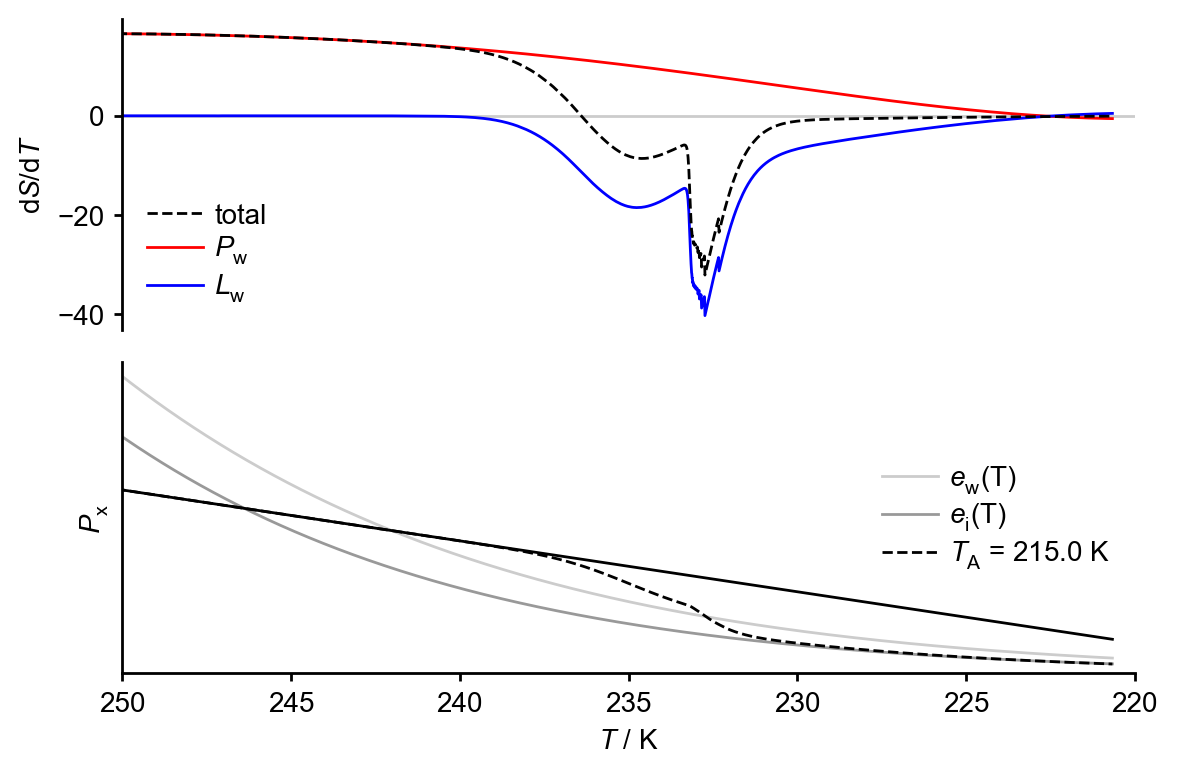

1.3064573088273936


In [ ]:
"""SUPERSATURATION FORCING GRAPHS, LW and PW"""

tau_m = 10 ** (np.log10((70/7000))/0.8) # F Yu (2024) and Schumann (CoCiP paper)
beta = 0.8

# tau_m = 10e-3
# beta = 0.9

T = np.array(parcel_trace["T"])
t = tau_m * ((T_e - T_a) / (T - T_a)) ** (1/beta)

def es(T): # pyrcel implementation of es(T)
    return 611.2 * np.exp(17.67 * T / (T + 243.5)) 

def p_i_0(T): # ice saturation
    
    return np.exp(9.550426 - 5723.265/T + 3.53068 * np.log(T) - 0.00728332*T) 

def p_mw(T, T_a): # water vapour pressure along the contrail mixing line 
        
    p_wa = p_i_0(T_a) * RHi # assume the mixing line terminates with a water vapour partial pressure = ice saturation
                    
    return p_wa + G * (T - T_a) 

def Smw(T, T_a): 
        return p_mw(T, T_a)/es(T-273.15)

S_mw = Smw(T, T_a)

P_w = np.gradient(S_mw, t)

S_total = parcel_trace["S"]
dS_dt_total = np.gradient(S_total, t)

L_w = dS_dt_total - P_w # equation in the form dS/dt = P_w - L_w

%matplotlib inline
%config InlineBackend.figure_format='retina'

plt.rcParams['mathtext.default'] = 'regular'
plt.rcParams["font.family"] = "Arial"
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['axes.formatter.useoffset'] = False
plt.rcParams["font.size"] = 10

fig = plt.figure(figsize = (6, 4))

ax = fig.add_subplot(2, 1, 1)

ax.axhline(y = 0, color = "black", alpha = 0.2, linewidth = 1)
ax.plot(T, dS_dt_total, color = "black", linestyle = "--", linewidth = 1, zorder = 10, label = "total")
ax.plot(T, P_w, color = "red", linewidth = 1, label = "$\it{P}$$_{w}$")
ax.plot(T, L_w, color = "blue", linewidth = 1, label = "$\it{L}$$_{w}$")

ax.legend(handletextpad = 0.4, labelspacing = 0.2, frameon = False, loc = "lower left")

ax.spines[["right", "top", "bottom"]].set_visible(False)

ax.set_ylabel("dS/dT")

ax.set_xlim([250, 220])
# ax.set_ylim([-25, 25])
# ax.set_yticks([])
ax.set_xticks([])

ax.tick_params(which='major', width=1, length = 3)

ax1 = fig.add_subplot(2, 1, 2)

ax1.plot(T, es(T - 273.15), color = "black", alpha = 0.2, linewidth = 1, label = "$\it{e}$$_{w}$(T)")

ax1.plot(T, p_i_0(T) * 1., color = "grey", alpha = 0.8, linewidth = 1, label = "$\it{e}$$_{i}$(T)")
ax1.plot(T, (S_total + 1) * es(T - 273.15), color = "black", linewidth = 1, linestyle = "--", label = "$\it{T}$$_{A}$ = "f"{T_a:.1f} K")
ax1.plot(T, p_mw(T, T_a), linewidth = 1, color = "black")

ax1.set_ylabel("P$_{x}$")
ax1.set_xlabel("T / K")

ax1.set_yticks([])
ax1.set_ylim([0, 100])
ax1.set_xlim([250, 220])

ax1.legend(handletextpad = 0.4, labelspacing = 0.2, frameon = False, loc = "center right")

ax1.spines[["right", "top"]].set_visible(False)

plt.tight_layout()

# Axis parameters

import matplotlib as mpl

mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['mathtext.it'] = 'Arial: italic'

ax.set_ylabel("$d\it{S}$/$d\it{T}$")
ax1.set_ylabel("$\it{P}$$_{x}$")
ax1.set_xlabel("$\it{T}$ / K")

ax1.tick_params(which='major', width=1, length = 3)

plt.savefig(f"/Users/jrp21/Desktop/test_after_changes.png", dpi = 500)

plt.show() 

print(np.max((S_total)) + 1)

# save data for external plotting

import pandas as pd

df = pd.DataFrame({'T': T, 'p_mw': (S_total + 1) * es(T - 273.15)})
df.to_csv("/Users/jrp21/Desktop/data.csv", index=False)

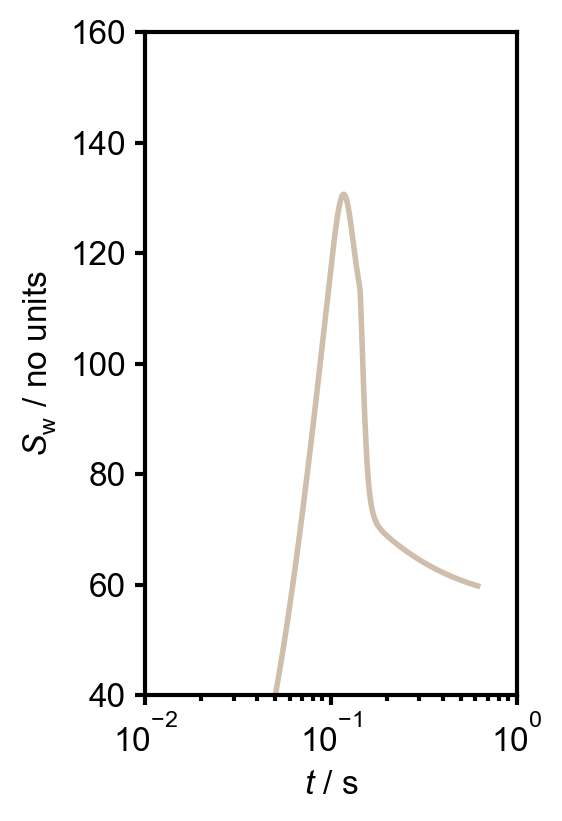

In [6]:
"""LOOKING AT EVOLUTION OVER TIME - FOR PRESENTATIONS"""

%matplotlib inline
%config InlineBackend.figure_format='retina'

plt.rcParams['mathtext.default'] = 'regular'
plt.rcParams["font.family"] = "Arial"
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['axes.formatter.useoffset'] = False
plt.rcParams["font.size"] = 12

fig = plt.figure(figsize = (3, 4.3))

ax = fig.add_subplot(1, 1, 1)

# plt.plot(T, es(T - 273.15)/es(T - 273.15), color = "black", alpha = 0.2, linewidth = 1, label = "$\it{e}$$_{w}$(T)")
# plt.plot(T, p_i_0(T)/es(T - 273.15), color = "grey", alpha = 0.8, linewidth = 1, label = "$\it{e}$$_{i}$(T)")
# plt.plot(T, (S_total + 1), color = "black", linewidth = 1, linestyle = "--", label = "$\it{T}$$_{A}$ = "f"{T_a:.1f} K")
# plt.plot(T, p_mw(T, T_a)/es(T - 273.15), linewidth = 1, color = "black")

ax.plot(t, 100 * (S_total + 1), color = "#d0bead", linewidth = 2, linestyle = "-", label = "$\it{T}$$_{A}$ = "f"{T_a:.1f} K")
ax.set_ylim([40, 160])
ax.set_xscale("log")
ax.set_xlim(1e-2, 1)

ax.xaxis.set_tick_params(width=1.5, which = "both")
ax.yaxis.set_tick_params(width=1.5, which = "both")

import matplotlib as mpl

mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['mathtext.it'] = 'Arial: italic'

ax.set_ylabel("$\it{S}$$_{w}$ / no units")
ax.set_xlabel("$\it{t}$ / s")

plt.tight_layout()

plt.savefig(f"/Users/jrp21/Desktop/water_and_ice_{EI_nvPM:.1e}_vPM_{EI_vPM:.1e}.png", dpi = 500)

plt.show() 


# plt.plot(t, T)
# plt.xscale("log")
# plt.xlim(1e-2, 10)
# plt.ylim([200, 400])
# # plt.show()

# T_new = np.linspace(200, 600, 1000)
# T_amb = 210

# plt.plot(T_new, 100 * (Smw(T_new, T_amb) - 1))
# plt.ylim([0, 400])

In [ ]:
"""ESTIMATING MAXIMUM SUPERSATURATION WITHIN PLUME" (PAPER FIGURE - USED TO GENERATE CSV FILES)"""

# iterating to find the droplet number concentration at peak supersaturation as a function of EI nvPM, including vPM in the calculations

from pyrcel import binned_activation

# Define contrail properties

T_a = 223 # ambient temperature / K
T_e = 600 # exhaust temperature
P0 = 22919.5 # (cruise) pressure, Pa 

RHi = 1.10 # ice saturation ratio 
G = 1.64 # contrail mixing line gradient

# Define particle properties

n_ambient = 600 # number concentration of ambient particles / cm^-3
EI_nvPM = 0 # emission index of nvPM particles, particles per kg of fuel burned
EI_vPM = 1e17 # emission index of vPM particles, particles per kg of fuel burned

GMD_ambient, GSD_ambient, kappa_ambient = 30.0e-9, 2.2, 0.500001 # must specify the ambient mode with this kappa value otherwise the code will fail
GMD_nvPM, GSD_nvPM, kappa_nvPM = 35.01e-9, 2.0, 0.005 # aggregates
# GMD_nvPM, GSD_nvPM, kappa_nvPM = 15.7e-9, 1.5, 0.005 # primary particles
GMD_vPM, GSD_vPM, kappa_vPM = 2.5e-9, 1.3, 0.5
bins_nvPM, bins_ambient, bins_vPM = 100, 50, 150

# Define model properties

T_start = 300.0 # initial model (not the ambient temperature) temperature / K
dt = 5e-5 # timestep / s
t_end = 0.5 # end time / s

n_0_list = []

EI_nvPM_array = np.logspace(12, 16, 10)

for index, value in enumerate(EI_nvPM_array):

    print(index)

    n = n_droplets(T_a, T_e, P0, 
               n_ambient, GMD_ambient, GSD_ambient, kappa_ambient, bins_ambient, 
               EI_vPM, GMD_vPM, GSD_vPM, kappa_vPM, bins_vPM,
               value, GMD_nvPM, GSD_nvPM, kappa_nvPM, bins_nvPM,
               T_start, dt, t_end, RHi, G)
    
    n_0_list.append(n)

# plotting
    
%matplotlib inline
%config InlineBackend.figure_format='retina'

plt.rcParams['mathtext.default'] = 'regular'
plt.rcParams["font.family"] = "Arial"
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['axes.formatter.useoffset'] = False
plt.rcParams["font.size"] = 10

fig = plt.figure(figsize = (7.5, 4))

ax = fig.add_subplot(1, 1, 1)

ax.plot(EI_nvPM_array, n_0_list, linewidth = 1, color = "black")
ax.scatter(EI_nvPM_array, n_0_list, edgecolor = "black", color = "white", s = 15, linewidth = 1)

ax.set_xscale("log")
ax.set_yscale("log")

# ax.set_ylim([1e16, 1e17])

ax.set_ylabel("n$_{0, w}$" + " / cm$^{-3}$")
ax.set_xlabel("EI$_{ice}$ / particles (kg-fuel)$^{-1}$")
ax.set_xlabel("EI$_{nvPM}$ / particles (kg-fuel)$^{-1}$")

plt.tight_layout()

# plt.savefig(f"/Users/jrp21/Desktop/{T_a}.png", dpi = 500)

plt.show()

import pandas as pd

df = pd.DataFrame({'EIs': EI_nvPM_array, 'AEIice': n_0_list})
df.to_csv(f"/Users/jrp21/Desktop/pyrcel_T_a_{T_a}.csv", index=False)

0
1


In [9]:
n_0_list


[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

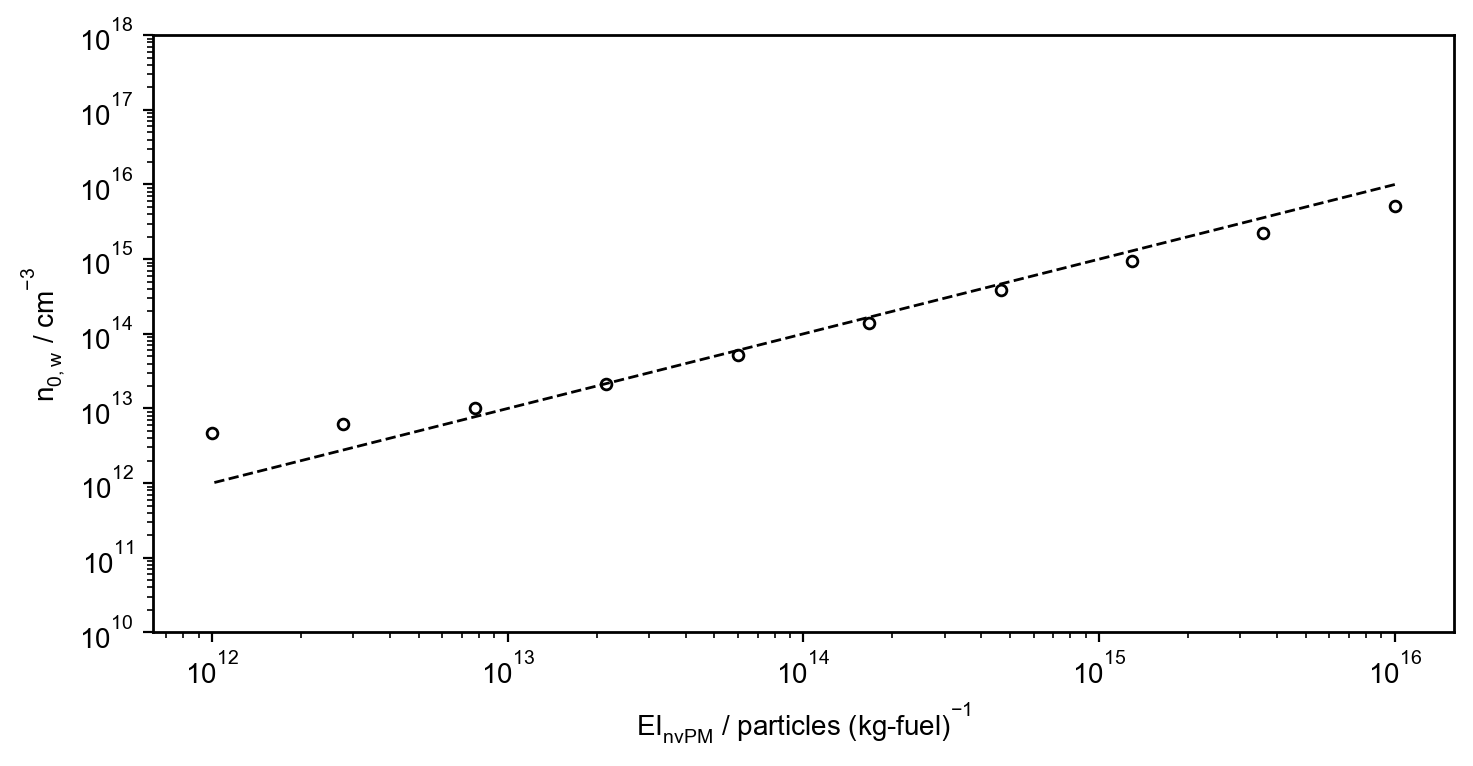

In [ ]:
# plotting above

%matplotlib inline
%config InlineBackend.figure_format='retina'

plt.rcParams['mathtext.default'] = 'regular'
plt.rcParams["font.family"] = "Arial"
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['axes.formatter.useoffset'] = False
plt.rcParams["font.size"] = 10

# # importing and plotting Yu data
# df = pd.read_csv("/Users/jrp21/Desktop/threshold.csv")
# # df = pd.read_csv("/Users/jrp21/Desktop/sub-threshold.csv")
# df = df.sort_values(by=["EI_soot"])
# ax.plot(df["EI_soot"], df["n_ice"] * 1e15/5e4, color = "black", linewidth = 1.5, label = "results from Kärcher and Yu, 2009")

fig = plt.figure(figsize = (7.5, 4))

ax = fig.add_subplot(1, 1, 1)

ax.plot(EI_nvPM_array, np.array(n_0_list)/1e6, linewidth = 1, color = "black")
ax.plot(EI_nvPM_array, EI_nvPM_array, linewidth = 1, color = "black", linestyle = "--")

ax.scatter(EI_nvPM_array, n_0_list, edgecolor = "black", color = "white", s = 15, linewidth = 1)

ax.set_xscale("log")
ax.set_yscale("log")

ax.set_ylim([1e10, 1e18])

ax.set_ylabel("n$_{0, w}$" + " / cm$^{-3}$")
ax.set_xlabel("EI$_{ice}$ / particles (kg-fuel)$^{-1}$")
ax.set_xlabel("EI$_{nvPM}$ / particles (kg-fuel)$^{-1}$")

plt.tight_layout()

plt.savefig(f"/Users/jrp21/Desktop/nvPM_sensitivity_analysis_water_and_ice_T_{T_a:.1f}.png", dpi = 500)

plt.show()

In [35]:
"""VISUALISING AEROSOL, LIQUID AND ICE (PAPER FIGURE PART 1)"""

from pyrcel import binned_activation
from pyrcel import constants as c
from pyrcel import dv, dv_cont, es, ka_cont, kohler_crit, sigma_w

def size_distribution(parcel_trace, aerosol_trace, aerosol, temperature):

    T_of_interest = temperature
    T_x = np.argmin(np.abs(parcel_trace['T'] - T_of_interest))

    Smax = parcel_trace['S'].iloc[T_x] # not maximum supersaturation during entire run, just at this timestep (definition consistent with pyrcel definition)
    T = parcel_trace['T'].iloc[T_x]
    rs = aerosol_trace.iloc[T_x]

    kappa = aerosol.kappa
    r_drys = aerosol.r_drys
    Nis = aerosol.Nis
    
    # code to modify the total number concentration of aerosol (according to the decay)

    def es(T):
        return 611.2 * np.exp(17.67 * T / (T + 243.5))

    P = 22919.5
    pv_sat = es(T - 273.15)  # saturation vapor pressure
    e = (1.0 + Smax) * pv_sat  # water vapor pressure
    rho_air_dry = (P - e) / c.Rd / T

    T_e = 600 

    expansion_time = 10e-3 * ((T_e - T_a) / (T - T_a)) ** (1/0.9)
    dilution_parameter = np.where(expansion_time > 10e-3, (10e-3/expansion_time) ** 0.9, 1) # dilution parameter as a function of expansion time

    if kappa == 0.500001:
        Nis = T_a/T * (1 - dilution_parameter) * aerosol.Nis
    else:
        Nis = dilution_parameter * (rho_air_dry)/((22919.5 * 28.96e-3) / (8.3145 * T_e)) * aerosol.Nis # dilution of number concentration

    # Nis = Nis / np.sum(Nis)

    dT_dt = - 0.9 * (T_e - T_a)/10e-3 * dilution_parameter ** (1 + 1/0.9)

    def J_Koop_new(T, r, kappa, r_dry):

        # determining P

        T_c = 647.096
        tau = 1 - T/T_c
        mu = 1.256
        B_ = 0.2358
        b_ = -0.625

        gamma_vw = B_ * tau ** mu * (1 + b_ * tau)

        # specifying conditions

        r_w = r
        T = T
        P0 = 1e5/1e6 # 101325 ~ 1e5 normalised by 1e6 (for MPa)
        P_droplet = (P0 + (2 * gamma_vw / r_w)/1e6) / 1e3 # converting to GPa
        
        # # activity constraints

        a_w = (r ** 3 - r_dry ** 3)/(r **3 - r_dry ** 3 * (1-kappa))

        u_w_i_minus_u_w_0 = 210368 + 131.438 * T - 3.32373e6/T - 41729.1 * np.log(T)
        a_w_i = np.exp(u_w_i_minus_u_w_0/(8.3145 * T))

        v_w_0 = -230.76 - 0.1478 * T + 4099.2/T + 48.8341 * np.log(T)
        v_i_0 = 19.43 - 2.2e-3 * T + 1.08e-5 * T ** 2

        v_w_minus_v_i = v_w_0 * (P_droplet - 0.5 * 1.6 * P_droplet ** 2 - 1/6 * -8.8 * P_droplet ** 3) - v_i_0 * (P_droplet - 0.5 * 0.22 * P_droplet ** 2 - 1/6 * -0.17 * P_droplet **3)

        delta_a_w = a_w * np.exp(v_w_minus_v_i/(8.3145 * T)) - a_w_i

        J = 10 ** (-906.7 + 8502 * delta_a_w - 26924 * delta_a_w ** 2 + 29180 * delta_a_w ** 3)

        for index, value in enumerate(delta_a_w):
            if value > 0.34 or value < 0.26:
                J[index] = np.nan

        return J
   
    def frozen_fraction(T, r_dry, r_wet, kappa, T_a, T_e, dT_dt):

        J = J_Koop_new(T, r_wet, kappa, r_dry) * 1e6

        # determine rate of change of the homogeneous ice nucleation rate

        dT = 0.001
        dJ_dT = (np.log(J_Koop_new(T + dT, r_wet, kappa, r_dry)) - np.log(J_Koop_new(T, r_wet, kappa, r_dry)))/(2 * dT) 
        inverse_freezing_timescale = dJ_dT * dT_dt
        
        # determine when the frozen fraction is unity 

        volume_of_dry_particle = 4/3 * np.pi * r_dry ** 3 # volume of dry particle without the soluble material included
        volume_of_wet_particle = 4/3 * np.pi * r_wet ** 3 # volume of wet particle including water added during hygroscopic growth
        LWV = volume_of_wet_particle - volume_of_dry_particle # total volume of metastable liquid (original coating + water)

        lmbda = 1 - np.exp(-LWV * J * inverse_freezing_timescale) # determine the frozen fraction

        return lmbda

    ff = frozen_fraction(T, r_drys, rs, kappa, T_a, T_e, dT_dt)
    ff = ff.fillna(0.0) # replace nan values with 0.0
    ff = np.round(ff, decimals = 3)

    # Coerce the reference wet droplet sizes (rs) to an array if they were passed as a Series
    if hasattr(rs, "values"):
        rs = rs.values

    r_crits, s_crits = list(
        zip(*[kohler_crit(T, r_dry, kappa, False) for r_dry in r_drys])
    )

    s_crits = np.array(s_crits)
    r_crits = np.array(r_crits)

    # Kinetic calculation
    aerosol_eq = (rs < r_crits) & (ff < 1) 

    # Kinetic water calculation 
    activated_eq = (rs >= r_crits) & (ff < 1)

    # Kinetic ice calculation 
    frozen_eq = (ff >= 1) 

    """TEST - THERMODYNAMIC CALCULATION"""

    # # Thermodynamic calculation
    # aerosol_eq = (Smax < s_crits) & (ff < 1) 

    # # Thermodynamic water calculation 
    # activated_eq = (Smax >= s_crits) & (ff < 1)

    # # Thermodynamic ice calculation 
    # frozen_eq = (ff >= 1) 

    # size distribution parameters
    aerosol_mode_conc = Nis[aerosol_eq]
    aerosol_mode_radius = rs[aerosol_eq]

    ice_mode_conc = Nis[frozen_eq]
    ice_mode_radius = rs[frozen_eq]
    
    liquid_mode_conc = Nis[activated_eq]
    liquid_mode_radius = rs[activated_eq]

    EIi_eq = (np.sum(ice_mode_conc) * 60) / (dilution_parameter * rho_air_dry)

    EIw_eq = (np.sum(liquid_mode_conc) * 60) / (dilution_parameter * rho_air_dry)  
    print(EIi_eq)   

    # plotting

    if aerosol == nvPM:

        ax.scatter(2 * aerosol_mode_radius, aerosol_mode_conc/1e6, color = "black", edgecolors = "black", linewidth = 1, s = 40, marker = "o", alpha = 1, label = f"T = {temperature}", zorder = 10)
        ax.scatter(2 * liquid_mode_radius, liquid_mode_conc/1e6, color = "royalblue",  edgecolors = "black", linewidth = 1, s = 40, marker = "o",  alpha = 1, label = "activated aerosol", zorder = 10)
        ax.scatter(2 * ice_mode_radius, ice_mode_conc/1e6, color = "white", edgecolors = "black", linewidth = 1, s = 40, marker = "h", alpha = 1, label = "ice particles", zorder = 10)
        ax.plot(2 * rs, Nis/1e6, color = "black", linestyle = "--", linewidth = 0.75)

    elif aerosol == vPM:

        ax1.scatter(2 * aerosol_mode_radius, aerosol_mode_conc/1e6, color = "black", linewidth = 1, s = 40, marker = "o", alpha = 1, label = "interstitial aerosol", zorder = 10)
        ax1.scatter(2 * liquid_mode_radius, liquid_mode_conc/1e6, color = "royalblue",  edgecolors = "black", linewidth = 1, s = 40, marker = "o",  alpha = 1, label = "activated aerosol", zorder = 10)
        ax1.scatter(2 * ice_mode_radius, ice_mode_conc/1e6, color = "white", edgecolors = "black", linewidth = 1, s = 40, marker = "h", alpha = 1, label = "ice particles", zorder = 10)
        ax1.plot(2 * rs, Nis/1e6, color = "black", linestyle = "--", linewidth = 0.75)

    # return 2 * aerosol_mode_radius, aerosol_mode_conc/1e6, 2 * liquid_mode_radius, liquid_mode_conc/1e6, 2 * ice_mode_radius, ice_mode_conc/1e6

nvPM_trace = aerosol_traces['nvPM']
vPM_trace = aerosol_traces['vPM']

N0_nvPM = (EI_nvPM * (P0 * 28.96e-3) / (8.3145 * T_e)) / 60 / 1e6 # initial number concentration of soot particles, particles per cm^3
nvPM =  pm.AerosolSpecies('nvPM',
                            pm.Lognorm(mu=GMD_nvPM * 0.5e6, sigma=GSD_nvPM, N=N0_nvPM),
                            kappa=kappa_nvPM, bins=int(bins_nvPM))   

N0_vPM = (EI_vPM * (P0 * 28.96e-3) / (8.3145 * T_e)) / 60 / 1e6 # initial number concentration of soot particles, particles per cm^3
vPM =  pm.AerosolSpecies('vPM',
                            pm.Lognorm(mu=GMD_vPM * 0.5e6, sigma=GSD_vPM, N=N0_vPM),
                            kappa=kappa_vPM, bins=int(bins_vPM))

In [108]:
"""VISUALISING AEROSOL, LIQUID AND ICE (PAPER FIGURE PART 1 - EDITS MADE ON 11/10/24)"""

from pyrcel import binned_activation
from pyrcel import constants as c
from pyrcel import dv, dv_cont, es, ka_cont, kohler_crit, sigma_w

def p_i_0(T):

    return np.exp(9.550426 - 5723.265/T + 3.53068 * np.log(T) - 0.00728332*T) 

def e_w(T):
    
    A = 54.842763
    B = 6763.22
    C = 4.21
    D = 0.000367
    E = 0.0415
    F = 218.8
    G = 53.878
    H = 1331.22
    I = 9.44523
    J = 0.014025
    
    return np.exp(A - B/T - C * np.log(T) + D*T + np.tanh(E * (T - F)) * (G - H/T - I * np.log(T) + J*T)) 

def J_KM2016(temperature):

    # Koop and Murray, 2016

    c0 = -3020.684
    c1 = -425.921
    c2 = -25.9779
    c3 = -0.868451
    c4 = -1.66203e-2
    c5 = -1.71736e-4
    c6 = -7.46953e-7

    temperature_degrees = temperature - 273.15

    x = (c0 * temperature_degrees ** 0) + \
        (c1 * temperature_degrees ** 1) + \
        (c2 * temperature_degrees ** 2) + \
        (c3 * temperature_degrees ** 3) + \
        (c4 * temperature_degrees ** 4) + \
        (c5 * temperature_degrees ** 5) + \
        (c6 * temperature_degrees ** 6)

    return (10 ** x)

def J_Marcolli(T, r_w):

    """
    I have checked this against the table (D2) in C Marcolli 2019 paper

    # Implementation error: I found that C Marcolli did not use 273.15 in the gamma_iw equation; instead she used 273
    # Note: For vi (ice molar density): rho0 (from Zobrist et al., 2017) is the density of ice at its melting temperature (0.9167 - 0.9168 g/cm^3)
    # Typographic error: in the expression for d_kappa_dP, the exponents should be negative i.e., (-6) and (-8)
    # Typographic error: throughout, we should have -delta G and -delta F in the exponents

    # I still can't get the delta G to agree with Claudia's table - I am very close (in the 3rd decimal place)
    # I still can't get the final value to agree (J) - this therefore must be due to the F term but I have double and triple checked this and cannot see the error

    """

    T_c = 647.096
    tau = 1 - T/T_c
    mu = 1.256
    B = 0.2358
    b = -0.625

    gamma_vw = B * tau ** mu * (1 + b * tau)

    # specifying conditions

    r_w = r_w
    T = T
    P0 = 1e5/1e6 # 101325 ~ 1e5 normalised by 1e6 (for MPa)
    P = P0 + (2 * gamma_vw / r_w)/1e6

    # calculating gamma_iw (surface tension of ice-water interface)

    gamma_iw = 0.03 - 0.18e-3 * (273 - T) + 4.99e-5 * P - 1.37e-7 * P ** 2 + 1.53e-10 * P ** 3 + 1.40e-12 * P ** 4 - 2.97e-15 * P ** 5 - 3.05e-17 * P ** 6 # P in MPa, result in J/m^2

    for index, value in enumerate(gamma_iw):
        if value < 0:
            gamma_iw[index] = 0

    # calculating d_F_diff (diffusion activation energy of water to cross water-ice embryo interface)

    T0 = 117.6 - 0.07416 * P + 0.0002213 * P ** 2
    d_F_diff = 1.380649e-23 * T ** 2 * 892 / (T - T0) ** 2

    # calculating molar volumes, v_i and v_w

    Mw = 18.01528e-3
    Na = 6.02214e23

    # densities of water under P0 and P

    rho_w_P0 = 1864.3535 - 72.5821489 * T + 2.5194368 * T ** 2 -0.049000203 * T ** 3 + 5.860253e-4 * T ** 4 - 4.5055151e-6 * T ** 5 + 2.2616353e-8 * T ** 6 - 7.3484974e-11 * T ** 7 + 1.4862784e-13 * T ** 8 -1.6984748e-16 * T ** 9 + 8.3699379e-20 * T ** 10

    kappa = 0.487 - 0.004368 * (T - 273.15) + 0.00007235 * (T - 273.15) ** 2
    d_kappa_dP = -0.0003805 + 6.639e-6 * (T - 273.15) - 9.688e-8 * (T - 273.15) ** 2 
    rho_w_P = rho_w_P0 + kappa * P + d_kappa_dP * P ** 2

    v_i = Mw/(Na * 916.75) * (1 - 0.05294 * (T - 273)/(273) - 0.05637 * (T - 273)/(273) ** 2 - 0.002913 * (T - 273)/(273) ** 3) ** -1
    v_w_P = Mw / (Na * rho_w_P)
    v_w_P0 = Mw / (Na * rho_w_P0)

    # calculating d_G_c

    d_G_c_numerator = 16 * np.pi * gamma_iw ** 3 * v_i ** 2
    d_G_c_denominator = 3 * (1.380649e-23 * T * np.log(e_w(T)/p_i_0(T)) - 1e6 * (P - P0) * v_i + 1e6 * (P - P0) * (v_w_P + v_w_P0)/2) ** 2

    d_G_c = d_G_c_numerator/d_G_c_denominator

    # calculating J_hom

    C_prefactor = 1e41
    J_hom = C_prefactor * np.exp(-d_G_c/(1.380649e-23 * T)) * np.exp(-d_F_diff/(1.380649e-23 * T))
    
    # return gamma_iw, d_G_c, J_hom/1e6  # return in terms of cm
    return J_hom

def size_distribution(parcel_trace, aerosol_trace, aerosol, temperature):

    T_of_interest = temperature
    T_x = np.argmin(np.abs(parcel_trace['T'] - T_of_interest))

    Smax = parcel_trace['S'].iloc[T_x] # not maximum supersaturation during entire run, just at this timestep (definition consistent with pyrcel definition)
    T = parcel_trace['T'].iloc[T_x]
    rs = aerosol_trace.iloc[T_x]

    kappa = aerosol.kappa
    r_drys = aerosol.r_drys
    Nis = aerosol.Nis
    
    # code to modify the total number concentration of aerosol (according to the decay)

    def es(T):
        return 611.2 * np.exp(17.67 * T / (T + 243.5))

    P = 22919.5
    pv_sat = es(T - 273.15)  # saturation vapor pressure
    e = (1.0 + Smax) * pv_sat  # water vapor pressure
    rho_air_dry = (P - e) / c.Rd / T

    T_e = 600 

    expansion_time = 10e-3 * ((T_e - T_a) / (T - T_a)) ** (1/0.9)
    dilution_parameter = np.where(expansion_time > 10e-3, (10e-3/expansion_time) ** 0.9, 1) # dilution parameter as a function of expansion time

    if kappa == 0.500001:
        Nis = T_a/T * (1 - dilution_parameter) * aerosol.Nis
    else:
        Nis = dilution_parameter * (rho_air_dry)/((22919.5 * 28.96e-3) / (8.3145 * T_e)) * aerosol.Nis # dilution of number concentration

    # Nis = Nis / np.sum(Nis)

    dT_dt = - 0.9 * (T_e - T_a)/10e-3 * dilution_parameter ** (1 + 1/0.9)

    def J_Koop_new(T, r, kappa, r_dry):

        # determining P

        T_c = 647.096
        tau = 1 - T/T_c
        mu = 1.256
        B_ = 0.2358
        b_ = -0.625

        gamma_vw = B_ * tau ** mu * (1 + b_ * tau)

        # specifying conditions

        r_w = r
        T = T
        P0 = 1e5/1e6 # 101325 ~ 1e5 normalised by 1e6 (for MPa)
        P_droplet = (P0 + (2 * gamma_vw / r_w)/1e6) / 1e3 # converting to GPa
        
        # # activity constraints

        a_w = (r ** 3 - r_dry ** 3)/(r **3 - r_dry ** 3 * (1-kappa))

        u_w_i_minus_u_w_0 = 210368 + 131.438 * T - 3.32373e6/T - 41729.1 * np.log(T)
        a_w_i = np.exp(u_w_i_minus_u_w_0/(8.3145 * T))

        v_w_0 = -230.76 - 0.1478 * T + 4099.2/T + 48.8341 * np.log(T)
        v_i_0 = 19.43 - 2.2e-3 * T + 1.08e-5 * T ** 2

        v_w_minus_v_i = v_w_0 * (P_droplet - 0.5 * 1.6 * P_droplet ** 2 - 1/6 * -8.8 * P_droplet ** 3) - v_i_0 * (P_droplet - 0.5 * 0.22 * P_droplet ** 2 - 1/6 * -0.17 * P_droplet **3)

        delta_a_w = a_w * np.exp(v_w_minus_v_i/(8.3145 * T)) - a_w_i

        J = 10 ** (-906.7 + 8502 * delta_a_w - 26924 * delta_a_w ** 2 + 29180 * delta_a_w ** 3)
        
        for index, value in enumerate(delta_a_w):
            if value > 0.34 or value < 0.26:
                J[index] = np.nan

        return J
       
    def frozen_fraction(T, r_dry, r_wet, kappa, T_a, T_e, dT_dt):

        J = J_Koop_new(T, r_wet, kappa, r_dry) * 1e6
        # J = J_Marcolli(T, r_wet) * 1e6
        # J = J_KM2016(T) * 1e6

        # determine rate of change of the homogeneous ice nucleation rate

        dT = 0.0001
        dlnJ_dT = (np.log(J_Koop_new(T + dT, r_wet, kappa, r_dry)) - np.log(J_Koop_new(T, r_wet, kappa, r_dry)))/dT 
        # dlnJ_dT = (np.log(J_Marcolli(T + dT, r_wet)) - np.log(J_Marcolli(T, r_wet)))/dT 
        # dlnJ_dT = (np.log(J_KM2016(T + dT)) - np.log(J_KM2016(T)))/dT

        inverse_freezing_timescale = dlnJ_dT * dT_dt
        
        # determine when the frozen fraction is unity 

        volume_of_dry_particle = 4/3 * np.pi * r_dry ** 3 # volume of dry particle without the soluble material included
        volume_of_wet_particle = 4/3 * np.pi * r_wet ** 3 # volume of wet particle including water added during hygroscopic growth
        LWV = volume_of_wet_particle - volume_of_dry_particle # total volume of metastable liquid (original coating + water)

        lmbda = 1 - np.exp(-LWV * J * 1/inverse_freezing_timescale) # determine the frozen fraction

        return lmbda

    ff = frozen_fraction(T, r_drys, rs, kappa, T_a, T_e, dT_dt)
    ff = ff.fillna(0.0) # replace nan values with 0.0
    ff = np.round(ff, decimals = 3)

    # Coerce the reference wet droplet sizes (rs) to an array if they were passed as a Series
    if hasattr(rs, "values"):
        rs = rs.values

    r_crits, s_crits = list(
        zip(*[kohler_crit(T, r_dry, 0.001, False) for r_dry in r_drys])
    )

    s_crits = np.array(s_crits)
    r_crits = np.array(r_crits)

    # Kinetic calculation
    aerosol_eq = (rs < r_crits) 

    # Kinetic water calculation 
    activated_eq = (rs >= r_crits) & (ff < 0.1)

    # Kinetic ice calculation 
    frozen_eq = (rs >= r_crits) & (ff >= 0.1) 

    # print(rs[0], kohler_crit(T, r_drys[0], 0.001, False)[0], r_crits[0])
    # print(frozen_eq)

    # fig, (ax, ax1) = plt.subplots(nrows = 2, ncols = 1, figsize=(7.3, 5))
    # ax1.set_xscale("log")

    # plt.scatter(rs, ff)
    # plt.xscale("log")
    # plt.axhline(y = 0)
    # plt.savefig(f"/Users/jrp21/Desktop/fig_T_{temperature}.png", dpi = 400)
    # plt.show()          

    """TEST - THERMODYNAMIC CALCULATION"""

    # # Thermodynamic calculation
    # aerosol_eq = (Smax < s_crits) & (ff < 1) 

    # # Thermodynamic water calculation 
    # activated_eq = (Smax >= s_crits) & (ff < 1)

    # # Thermodynamic ice calculation 
    # frozen_eq = (ff >= 1) 

    # size distribution parameters
    aerosol_mode_conc = Nis[aerosol_eq]
    aerosol_mode_radius = rs[aerosol_eq]

    ice_mode_conc = Nis[frozen_eq]
    ice_mode_radius = rs[frozen_eq]

    liquid_mode_conc = Nis[activated_eq]
    liquid_mode_radius = rs[activated_eq]

    # print(np.sum(ice_mode_conc), np.sum(liquid_mode_conc))
    
    EIi_eq = (np.sum(ice_mode_conc) * 60) / (dilution_parameter * rho_air_dry)
    EIw_eq = (np.sum(liquid_mode_conc) * 60) / (dilution_parameter * rho_air_dry)

    # plotting

    if aerosol == nvPM:

        ax.scatter(2 * aerosol_mode_radius, aerosol_mode_conc/1e6, color = "black", edgecolors = "black", linewidth = 1, s = 40, marker = "o", alpha = 1, label = f"T = {temperature}", zorder = 10)
        ax.scatter(2 * liquid_mode_radius, liquid_mode_conc/1e6, color = "royalblue",  edgecolors = "black", linewidth = 1, s = 40, marker = "o",  alpha = 1, label = "activated aerosol", zorder = 10)
        ax.scatter(2 * ice_mode_radius, ice_mode_conc/1e6, color = "white", edgecolors = "black", linewidth = 1, s = 40, marker = "h", alpha = 1, label = "ice particles", zorder = 10)
        ax.plot(2 * rs, Nis/1e6, color = "black", linestyle = "--", linewidth = 0.75)

        print(len(liquid_mode_radius), len(ice_mode_radius))


    elif aerosol == vPM:

        ax1.scatter(2 * aerosol_mode_radius, aerosol_mode_conc/1e6, color = "black", linewidth = 1, s = 40, marker = "o", alpha = 1, label = "interstitial aerosol", zorder = 10)
        ax1.scatter(2 * liquid_mode_radius, liquid_mode_conc/1e6, color = "royalblue",  edgecolors = "black", linewidth = 1, s = 40, marker = "o",  alpha = 1, label = "activated aerosol", zorder = 10)
        ax1.scatter(2 * ice_mode_radius, ice_mode_conc/1e6, color = "white", edgecolors = "black", linewidth = 1, s = 40, marker = "h", alpha = 1, label = "ice particles", zorder = 10)
        ax1.plot(2 * rs, Nis/1e6, color = "black", linestyle = "--", linewidth = 0.75)

    # return 2 * aerosol_mode_radius, aerosol_mode_conc/1e6, 2 * liquid_mode_radius, liquid_mode_conc/1e6, 2 * ice_mode_radius, ice_mode_conc/1e6

nvPM_trace = aerosol_traces['nvPM']
vPM_trace = aerosol_traces['vPM']

N0_nvPM = (EI_nvPM * (P0 * 28.96e-3) / (8.3145 * T_e)) / 60 / 1e6 # initial number concentration of soot particles, particles per cm^3
nvPM =  pm.AerosolSpecies('nvPM',
                            pm.Lognorm(mu=GMD_nvPM * 0.5e6, sigma=GSD_nvPM, N=N0_nvPM),
                            kappa=kappa_nvPM, bins=int(bins_nvPM))   

N0_vPM = (EI_vPM * (P0 * 28.96e-3) / (8.3145 * T_e)) / 60 / 1e6 # initial number concentration of soot particles, particles per cm^3
vPM =  pm.AerosolSpecies('vPM',
                            pm.Lognorm(mu=GMD_vPM * 0.5e6, sigma=GSD_vPM, N=N0_vPM),
                            kappa=kappa_vPM, bins=int(bins_vPM))

size_distribution(parcel_trace, nvPM_trace, nvPM, 225)


49 0


49 0
0 49


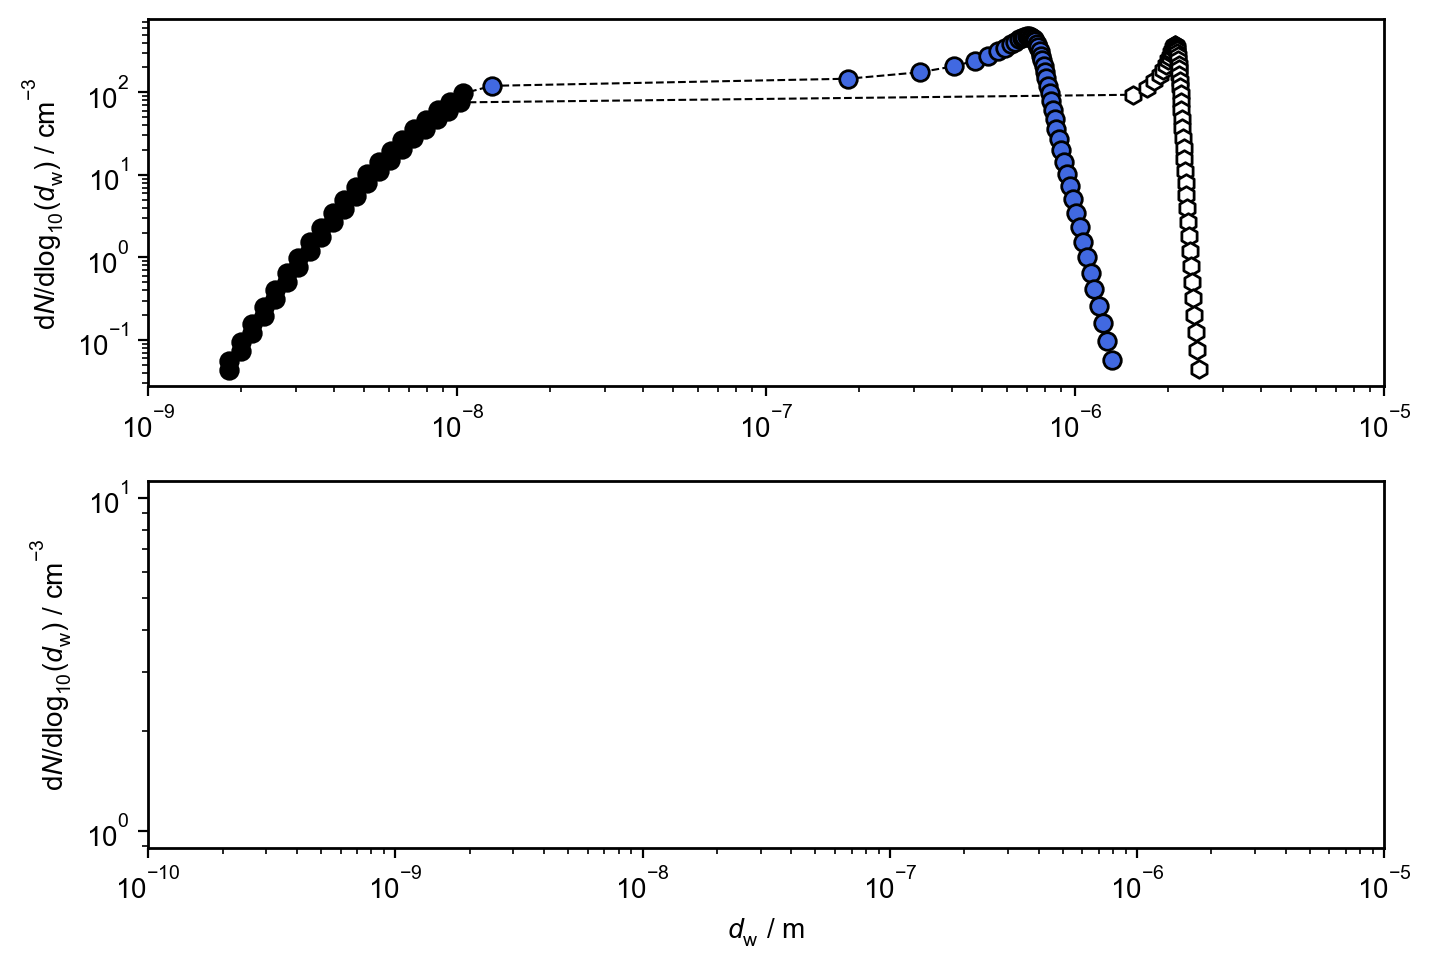

In [114]:
"""VISUALISING AEROSOL, LIQUID AND ICE (PAPER FIGURE PART 2)"""

# plotting

%matplotlib inline
%config InlineBackend.figure_format='retina'

plt.rcParams['mathtext.default'] = 'regular'
plt.rcParams["font.family"] = "Arial"
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['axes.formatter.useoffset'] = False
plt.rcParams["font.size"] = 10

fig, (ax, ax1) = plt.subplots(nrows = 2, ncols = 1, figsize=(7.3, 5))

# size_distribution(parcel_trace, nvPM_trace, nvPM, 250)
# size_distribution(parcel_trace, nvPM_trace, nvPM, 240)
# size_distribution(parcel_trace, nvPM_trace, nvPM, 237)
# size_distribution(parcel_trace, vPM_trace, vPM, 238)
# size_distribution(parcel_trace, nvPM_trace, nvPM, 233.0)
# size_distribution(parcel_trace, nvPM_trace, nvPM, 230)

# size_distribution(parcel_trace, nvPM_trace, nvPM, 234)
# size_distribution(parcel_trace, nvPM_trace, nvPM, 228)
# size_distribution(parcel_trace, vPM_trace, vPM, 250)
# size_distribution(parcel_trace, vPM_trace, vPM, 240)
# size_distribution(parcel_trace, vPM_trace, vPM, 230)

size_distribution(parcel_trace, nvPM_trace, nvPM, 233)

size_distribution(parcel_trace, nvPM_trace, nvPM, 230)

# ax.legend(handletextpad = 0.4, labelspacing = 0.2, frameon = False, loc = "upper left")

import matplotlib as mpl

mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['mathtext.it'] = 'Arial: italic'

ax.set_ylabel("d$\it{N}$/dlog$_{10}$($\it{d}$$_{w}$) / cm$^{-3}$", fontsize = 10)
ax1.set_ylabel("d$\it{N}$/dlog$_{10}$($\it{d}$$_{w}$) / cm$^{-3}$", fontsize = 10)

ax1.set_xlabel("$\it{d}$" "$_{w}$ / m")

ax.set_yscale("log")
ax1.set_yscale("log")

ax.set_xscale("log")
ax1.set_xscale("log")

# ax.set_ylim([1e0, 1e7])
# ax1.set_ylim([1e-5, 1e8])

ax.set_xlim([1e-9, 1e-5])
ax1.set_xlim([1e-10, 1e-5])
# ax.set_xticks([])

# ax.tick_params(labelbottom=False)  
# ax.tick_params(axis="both",direction="out")

plt.tight_layout()

# plt.savefig(f"/Users/jrp21/Desktop/Figure 9 - 10^17 - peak critical supersatuation_{EI_nvPM:.1e}_vPM_{EI_vPM:.1e}.svg", dpi = 1000)

plt.show()

In [38]:
len(parcel_trace)

10000

In [343]:
"""ESTIMATING ICE CRYSTAL NUMBER CONCENTRATION" (PAPER FIGURE - USED TO GENERATE CSV FILES)"""

from pyrcel import binned_activation

# Define contrail properties

T_a = 215 # ambient temperature / K
T_e = 600.0 # exhaust temperature
P0 = 22919.5 # (cruise) pressure, Pa 

# Define particle properties

n_ambient = 600 # number concentration of ambient particles / cm^-3
EI_nvPM = 0 # emission index of nvPM particles, particles per kg of fuel burned
EI_vPM = 0 # emission index of vPM particles, particles per kg of fuel burned

GMD_ambient, GSD_ambient, kappa_ambient = 30.0e-9, 2.2, 0.500001 # must specify the ambient mode with this kappa value otherwise the code will fail
GMD_nvPM, GSD_nvPM, kappa_nvPM = 34.0e-9, 2.0, 0.005
GMD_vPM, GSD_vPM, kappa_vPM = 2.5e-9, 1.4, 0.5
bins_nvPM, bins_ambient, bins_vPM = 50, 50, 250

# Define model properties

T_start = 300.0 # initial model (not the ambient temperature) temperature / K
dt = 0.0002 # timestep / s
t_end = 2 # end time / s

n_0_list = []

EI_nvPM_array = np.logspace(10, 17, 8)

for index, value in enumerate(EI_nvPM_array):

    print(index)

    n = n_droplets(T_a, T_e, P0, 
               n_ambient, GMD_ambient, GSD_ambient, kappa_ambient, bins_ambient, 
               EI_vPM, GMD_vPM, GSD_vPM, kappa_vPM, bins_vPM,
               value, GMD_nvPM, GSD_nvPM, kappa_nvPM, bins_nvPM,
               T_start, dt, t_end)
    
    n_0_list.append(n)

# plotting
    
%matplotlib inline
%config InlineBackend.figure_format='retina'

plt.rcParams['mathtext.default'] = 'regular'
plt.rcParams["font.family"] = "Arial"
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['axes.formatter.useoffset'] = False
plt.rcParams["font.size"] = 10

fig = plt.figure(figsize = (7.5, 4))

ax = fig.add_subplot(1, 1, 1)

ax.plot(EI_nvPM_array, n_0_list, linewidth = 1, color = "black")
ax.scatter(EI_nvPM_array, n_0_list, edgecolor = "black", color = "white", s = 15, linewidth = 1)

ax.set_xscale("log")
ax.set_yscale("log")

ax.set_ylabel("n$_{0, w}$" + " / cm$^{-3}$")
ax.set_xlabel("EI$_{ice}$ / particles (kg-fuel)$^{-1}$")
ax.set_xlabel("EI$_{nvPM}$ / particles (kg-fuel)$^{-1}$")

plt.tight_layout()
plt.show()

import pandas as pd

df = pd.DataFrame({'EInvPM': EI_nvPM_array, 'AEIice': n_0_list})
df.to_csv("/Users/jrp21/Desktop/data_without_vPM.csv", index=False)

0
1
2
3


KeyboardInterrupt: 

In [12]:
"""
Making the code into a function so that the number concentration at peak supersaturation can be output as a function of input parameters 
(including particle properties and contrail mixing properties)
"""

from pyrcel import binned_activation

# Functions for estimating the saturation ratio

def es(T): # pyrcel implementation of es(T)
    return 611.2 * np.exp(17.67 * T / (T + 243.5)) 

def p_i_0(T): # ice saturation
    
    return np.exp(9.550426 - 5723.265/T + 3.53068 * np.log(T) - 0.00728332*T) 

def p_mw(T, T_a): # water vapour pressure along the contrail mixing line 
        
    p_wa = p_i_0(T_a) # assume the mixing line terminates with a water vapour partial pressure = ice saturation
                    
    return p_wa + 1.64 * (T - T_a) 

def Smw(T, T_a): 
        return p_mw(T, T_a)/es(T-273.15)

# Function for estimating the droplet number concentration

def n_droplets(T_a, T_e, P0, 
               n_ambient, GMD_ambient, GSD_ambient, kappa_ambient, bins_ambient, 
               EI_vPM, GMD_vPM, GSD_vPM, kappa_vPM, bins_vPM,
               EI_nvPM, GMD_nvPM, GSD_nvPM, kappa_nvPM, bins_nvPM,
               T_start, dt, t_end):
    
    print(EI_vPM, GMD_vPM)

    # Define the supersaturation at the initial model temperature

    S0 = Smw(T_start, T_a) - 1 # water supersaturation at initial model temperature / K 

    # Initialise particle modes, note that mu = GRD of mode in micrometers

    N0_nvPM = (EI_nvPM * (P0 * 28.96e-3) / (8.3145 * T_e)) / 60 / 1e6 # initial number concentration of soot particles, particles per cm^3
    N0_vPM = (EI_vPM * (P0 * 28.96e-3) / (8.3145 * T_e)) / 60 / 1e6 # initial number concentration of soot particles, particles per cm^3

    ambient =  pm.AerosolSpecies('ambient',
                                pm.Lognorm(mu=GMD_ambient * 0.5e6, sigma=GSD_ambient, N=n_ambient),
                                kappa=kappa_ambient, bins=int(bins_ambient))
                                
    vPM =  pm.AerosolSpecies('vPM',
                                pm.Lognorm(mu=GMD_vPM * 0.5e6, sigma=GSD_vPM, N=N0_vPM),
                                kappa=kappa_vPM, bins=int(bins_vPM))

    nvPM =  pm.AerosolSpecies('nvPM',
                                pm.Lognorm(mu=GMD_nvPM * 0.5e6, sigma=GSD_nvPM, N=N0_nvPM),
                                kappa=kappa_nvPM, bins=int(bins_nvPM))                              

    initial_aerosols = [vPM, nvPM, ambient]

    # Model initialisation and calculation

    model = pm.ParcelModel(initial_aerosols, T_a, T_start, S0, P0, console=False, accom=1.0)
    parcel_trace, aerosol_traces = model.run(t_end, dt, solver='cvode')

    # Maximum supersaturation

    S_max = np.max(parcel_trace['S']) * 100 # maximum plume supersaturation achieved / %
    idxmax = np.argmax(parcel_trace['S']) # index of above

    nvPM_trace = aerosol_traces['nvPM']
    vPM_trace = aerosol_traces['vPM']
    ambient_trace = aerosol_traces['ambient']

    max_n_vPM = binned_activation(parcel_trace['S'].iloc[-1], parcel_trace['T'].iloc[-1], vPM_trace.iloc[-1],  vPM, T_a) # activated fractions at maximum supersaturation
    max_n_nvPM = binned_activation(parcel_trace['S'].iloc[-1], parcel_trace['T'].iloc[-1], nvPM_trace.iloc[-1],  nvPM, T_a) # activated fractions at maximum supersaturation
    max_n_ambient = binned_activation(parcel_trace['S'].iloc[-1], parcel_trace['T'].iloc[-1], ambient_trace.iloc[-1],  ambient, T_a) # activated fractions at maximum supersaturation

    max_n_total = (max_n_nvPM + max_n_vPM + max_n_ambient)

    # fraction_from_volatiles = max_n_vPM/max_n_total
    
    # return fraction_from_volatiles * 100

    return max_n_total/max_n_nvPM

# exploring vPM sensitivity (1/2)
 
import matplotlib.pyplot as plt
import matplotlib as mpl

# Define contrail properties

T_a = 215 # ambient temperature / K
T_e = 600.0 # exhaust temperature
P0 = 22919.5 # (cruise) pressure, Pa 

# Define particle properties

n_ambient = 600 # number concentration of ambient particles / cm^-3
EI_nvPM = 1e13 # emission index of nvPM particles, particles per kg of fuel burned
EI_vPM = 0 # emission index of vPM particles, particles per kg of fuel burned

GMD_ambient, GSD_ambient, kappa_ambient = 30.0e-9, 2.2, 0.500001 # must specify the ambient mode with this kappa value otherwise the code will fail
GMD_nvPM, GSD_nvPM, kappa_nvPM = 34.0e-9, 2.0, 0.005
GMD_vPM, GSD_vPM, kappa_vPM = 2.5e-9, 1.4, 0.5
bins_nvPM, bins_ambient, bins_vPM = 30, 10, 30

# Define model properties

T_start = 350.0 # initial model (not the ambient temperature) temperature / K
dt = 0.0001 # timestep / s
t_end = 0.5 # end time / s

# Dependent variables


EI_vPM_array = np.logspace(14, np.log10(2e17), 4)
GMD_vPM_array = np.linspace(2e-9, 5e-9, 4)


x, y = np.meshgrid(EI_vPM_array, GMD_vPM_array)

f_vectorized = np.vectorize(n_droplets)
z = f_vectorized(T_a, T_e, P0, 
               n_ambient, GMD_ambient, GSD_ambient, kappa_ambient, bins_ambient, 
               x, y, GSD_vPM, kappa_vPM, bins_vPM,
               EI_nvPM, GMD_nvPM, GSD_nvPM, kappa_nvPM, bins_nvPM,
               T_start, dt, t_end)

# fig = plt.figure(figsize = (5, 4))
# ax = fig.add_subplot(1, 1, 1)

# import matplotlib.colors as mcolors
# from matplotlib.ticker import ScalarFormatter

# contour = plt.contourf(x, y/1e-9, z, cmap = "jet")
# fig.colorbar(contour, ax = ax, label = 'EIi/Ei_nvPM')

# ax.set_xlabel('vPM kappa / no units')
# ax.set_ylabel('vPM GMD / nm')

# # ax.set_xlim([])
# # ax.set_ylim([1, 10])

# ax.set_xscale("log")
# # ax.set_yscale("log")

# # ax.set_xticks([1e2, 1e4, 1e6, 1e8, 1e10, 1e12, 1e14, 1e16])
# # ax.set_yticks([1, 10, 100])

# plt.subplots_adjust(left = 0.1, right = 0.94, bottom = 0.17, top = 0.94, wspace = 0.27, hspace = 0.2)
# plt.savefig(f"/Users/jrp21/Desktop/test_13.png", dpi = 300)

# plt.show()

import xarray as xr

xarray = xr.DataArray(z, coords=[('y', GMD_vPM_array), ('x', EI_vPM_array)], name='z')
xarray.to_netcdf('/Users/jrp21/Desktop/datay.nc')

100000000000000.0 2e-09
100000000000000.0 2e-09
1259921049894871.5 2e-09
1.5874010519681952e+16 2e-09
2.0000000000000003e+17 2e-09
100000000000000.0 3.0000000000000004e-09
1259921049894871.5 3.0000000000000004e-09
1.5874010519681952e+16 3.0000000000000004e-09
2.0000000000000003e+17 3.0000000000000004e-09
100000000000000.0 4e-09
1259921049894871.5 4e-09
1.5874010519681952e+16 4e-09
2.0000000000000003e+17 4e-09
100000000000000.0 5e-09
1259921049894871.5 5e-09
1.5874010519681952e+16 5e-09
2.0000000000000003e+17 5e-09


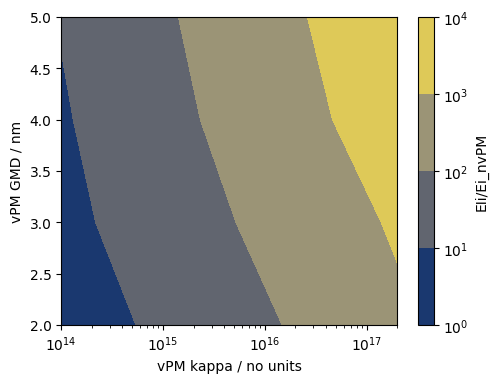

[[2.95074257e+00 2.14178144e+01 1.05834712e+02 4.37979631e+02]
 [6.46713656e+00 4.11206901e+01 2.58491608e+02 1.36039333e+03]
 [8.41467323e+00 6.68458457e+01 5.18603387e+02 3.42436928e+03]
 [1.07913592e+01 9.18105962e+01 8.43533198e+02 3.61577690e+03]]


In [33]:
fig = plt.figure(figsize = (5, 4))
ax = fig.add_subplot(1, 1, 1)

import matplotlib.colors as mcolors
from matplotlib.ticker import ScalarFormatter

# contour = plt.contourf(x, y/1e-9, z, cmap = "jet")
# fig.colorbar(contour, ax = ax, label = 'EIi/Ei_nvPM')

levels = np.arange(0, 4, 0.4)

contour = ax.contourf(x, y/1e-9, z, cmap = "cividis", norm=mpl.colors.LogNorm())
# contour = ax.contourf(x, y/1e-9, np.log10(z), levels = levels, cmap = "cividis")
cbar = plt.colorbar(contour, ax = ax, label = 'EIi/Ei_nvPM')
# cbar.set_ticks(levels)

ax.set_xlabel('vPM kappa / no units')
ax.set_ylabel('vPM GMD / nm')

# ax.set_xlim([])
# ax.set_ylim([1, 10])

ax.set_xscale("log")
# ax.set_yscale("log")

# ax.set_xticks([1e2, 1e4, 1e6, 1e8, 1e10, 1e12, 1e14, 1e16])
# ax.set_yticks([1, 10, 100])

plt.subplots_adjust(left = 0.1, right = 0.94, bottom = 0.17, top = 0.94, wspace = 0.27, hspace = 0.2)
plt.savefig(f"/Users/jrp21/Desktop/test_13.png", dpi = 300)

plt.show()

print(z)

In [12]:
"""
Copied above code but intend to change later (7/8/24)
"""

from pyrcel import binned_activation

# Functions for estimating the saturation ratio

def es(T): # pyrcel implementation of es(T)
    return 611.2 * np.exp(17.67 * T / (T + 243.5)) 

def p_i_0(T): # ice saturation
    
    return np.exp(9.550426 - 5723.265/T + 3.53068 * np.log(T) - 0.00728332*T) 

def p_mw(T, T_a): # water vapour pressure along the contrail mixing line 
        
    p_wa = p_i_0(T_a) # assume the mixing line terminates with a water vapour partial pressure = ice saturation
                    
    return p_wa + 1.64 * (T - T_a) 

def Smw(T, T_a): 
        return p_mw(T, T_a)/es(T-273.15)

# Function for estimating the droplet number concentration

def n_droplets(T_a, T_e, P0, 
               n_ambient, GMD_ambient, GSD_ambient, kappa_ambient, bins_ambient, 
               EI_vPM, GMD_vPM, GSD_vPM, kappa_vPM, bins_vPM,
               EI_nvPM, GMD_nvPM, GSD_nvPM, kappa_nvPM, bins_nvPM,
               T_start, dt, t_end):
    
    print(kappa_vPM, GMD_vPM)

    # Define the supersaturation at the initial model temperature

    S0 = Smw(T_start, T_a) - 1 # water supersaturation at initial model temperature / K 

    # Initialise particle modes, note that mu = GRD of mode in micrometers

    N0_nvPM = (EI_nvPM * (P0 * 28.96e-3) / (8.3145 * T_e)) / 60 / 1e6 # initial number concentration of soot particles, particles per cm^3
    N0_vPM = (EI_vPM * (P0 * 28.96e-3) / (8.3145 * T_e)) / 60 / 1e6 # initial number concentration of soot particles, particles per cm^3

    ambient =  pm.AerosolSpecies('ambient',
                                pm.Lognorm(mu=GMD_ambient * 0.5e6, sigma=GSD_ambient, N=n_ambient),
                                kappa=kappa_ambient, bins=int(bins_ambient))
                                
    vPM =  pm.AerosolSpecies('vPM',
                                pm.Lognorm(mu=GMD_vPM * 0.5e6, sigma=GSD_vPM, N=N0_vPM),
                                kappa=kappa_vPM, bins=int(bins_vPM))

    nvPM =  pm.AerosolSpecies('nvPM',
                                pm.Lognorm(mu=GMD_nvPM * 0.5e6, sigma=GSD_nvPM, N=N0_nvPM),
                                kappa=kappa_nvPM, bins=int(bins_nvPM))                              

    initial_aerosols = [vPM, nvPM, ambient]

    # Model initialisation and calculation

    model = pm.ParcelModel(initial_aerosols, T_a, T_start, S0, P0, console=False, accom=1.0, truncate_aerosols= True)
    parcel_trace, aerosol_traces = model.run(t_end, dt, solver='cvode')

    # Maximum supersaturation

    S_max = np.max(parcel_trace['S']) * 100 # maximum plume supersaturation achieved / %
    idxmax = np.argmax(parcel_trace['S']) # index of above

    nvPM_trace = aerosol_traces['nvPM']
    vPM_trace = aerosol_traces['vPM']
    ambient_trace = aerosol_traces['ambient']

    "recent"

    T_of_interest = 230
    T_x = np.argmin(np.abs(parcel_trace['T'] - 230))

    nvPM_trace = aerosol_traces['nvPM']
    vPM_trace = aerosol_traces['vPM']
    ambient_trace = aerosol_traces['ambient']

    max_n_vPM = binned_activation(parcel_trace['S'].iloc[T_x], parcel_trace['T'].iloc[T_x], vPM_trace.iloc[T_x],  vPM, T_a) # activated fractions at maximum supersaturation
    max_n_nvPM = binned_activation(parcel_trace['S'].iloc[T_x], parcel_trace['T'].iloc[T_x], nvPM_trace.iloc[T_x],  nvPM, T_a) # activated fractions at maximum supersaturation
    max_n_ambient = binned_activation(parcel_trace['S'].iloc[T_x], parcel_trace['T'].iloc[T_x], ambient_trace.iloc[T_x],  ambient, T_a) # activated fractions at maximum supersaturation

    max_n_total = (max_n_nvPM + max_n_vPM + max_n_ambient)
    
    "former"

    # max_n_vPM = binned_activation(parcel_trace['S'].iloc[-1], parcel_trace['T'].iloc[-1], vPM_trace.iloc[-1],  vPM, T_a) # activated fractions at maximum supersaturation
    # max_n_nvPM = binned_activation(parcel_trace['S'].iloc[-1], parcel_trace['T'].iloc[-1], nvPM_trace.iloc[-1],  nvPM, T_a) # activated fractions at maximum supersaturation
    # max_n_ambient = binned_activation(parcel_trace['S'].iloc[-1], parcel_trace['T'].iloc[-1], ambient_trace.iloc[-1],  ambient, T_a) # activated fractions at maximum supersaturation

    # max_n_total = (max_n_nvPM + max_n_vPM + max_n_ambient)

    # fraction_from_volatiles = max_n_vPM/max_n_total
    # return fraction_from_volatiles * 100
    # return max_n_total/max_n_nvPM
    return max_n_total

# exploring vPM sensitivity (1/2)
 
import matplotlib.pyplot as plt
import matplotlib as mpl

# Define contrail properties

T_a = 213 # ambient temperature / K
T_e = 600.0 # exhaust temperature
P0 = 22919.5 # (cruise) pressure, Pa 

# Define particle properties

n_ambient = 600 # number concentration of ambient particles / cm^-3 # Kärcher 2015
# n_ambient = 1000 # number concentration of ambient particles / cm^-3 # Yu 2024

EI_nvPM = 1e16 # emission index of nvPM particles, particles per kg of fuel burned
EI_vPM = 1e17 # emission index of vPM particles, particles per kg of fuel burned

GMD_ambient, GSD_ambient, kappa_ambient = 30.0e-9, 2.2, 0.500001 # must specify the ambient mode with this kappa value otherwise the code will fail # Kärcher 2015
# GMD_ambient, GSD_ambient, kappa_ambient = 10e-9, 1.6, 0.500001 # must specify the ambient mode with this kappa value otherwise the code will fail # Yu 2024

GMD_nvPM, GSD_nvPM, kappa_nvPM = 35.0e-9, 2.0, 0.005
GMD_vPM, GSD_vPM, kappa_vPM = 2.5e-9, 1.3, 0.5
bins_nvPM, bins_ambient, bins_vPM = 50, 50, 200

# Define model properties

T_start = 300.0 # initial model (not the ambient temperature) temperature / K
dt = 0.0001 # timestep / s
t_end = 0.5 # end time / s

# Dependent variables

# kappa_vPM_array = np.logspace(-4, 0, 4)
# GMD_vPM_array = np.linspace(2e-9, 9e-9, 4)[::-1]

# kappa_vPM_array = np.array([0.001])
# GMD_vPM_array = np.array([1e-9])

kappa_vPM_array = np.logspace(-4, 0, 9)
GMD_vPM_array = np.linspace(1e-9, 4e-9, 7)

x, y = np.meshgrid(kappa_vPM_array, GMD_vPM_array)

f_vectorized = np.vectorize(n_droplets)
z = f_vectorized(T_a, T_e, P0, 
               n_ambient, GMD_ambient, GSD_ambient, kappa_ambient, bins_ambient, 
               EI_vPM, y, GSD_vPM, x, bins_vPM,
               EI_nvPM, GMD_nvPM, GSD_nvPM, kappa_nvPM, bins_nvPM,
               T_start, dt, t_end)

0.0001 1e-09
0.0001 1e-09
0.00031622776601683794 1e-09
0.001 1e-09
0.0031622776601683794 1e-09
0.01 1e-09
0.03162277660168379 1e-09
0.1 1e-09
0.31622776601683794 1e-09
1.0 1e-09
0.0001 1.5000000000000002e-09
0.00031622776601683794 1.5000000000000002e-09
0.001 1.5000000000000002e-09
0.0031622776601683794 1.5000000000000002e-09
0.01 1.5000000000000002e-09
0.03162277660168379 1.5000000000000002e-09
0.1 1.5000000000000002e-09
0.31622776601683794 1.5000000000000002e-09
1.0 1.5000000000000002e-09
0.0001 2e-09
0.00031622776601683794 2e-09
0.001 2e-09
0.0031622776601683794 2e-09
[CVode Warning] b'Internal t = 0.249293 and h = 9.69568e-18 are such that t + h = t on the next step. The solver will continue anyway.'
[CVode Warning] b'Internal t = 0.249293 and h = 9.69568e-18 are such that t + h = t on the next step. The solver will continue anyway.'
[CVode Warning] b'Internal t = 0.249293 and h = 6.0598e-18 are such that t + h = t on the next step. The solver will continue anyway.'
[CVode Warning]

ParcelModelError: 'Something failed during model integration.'

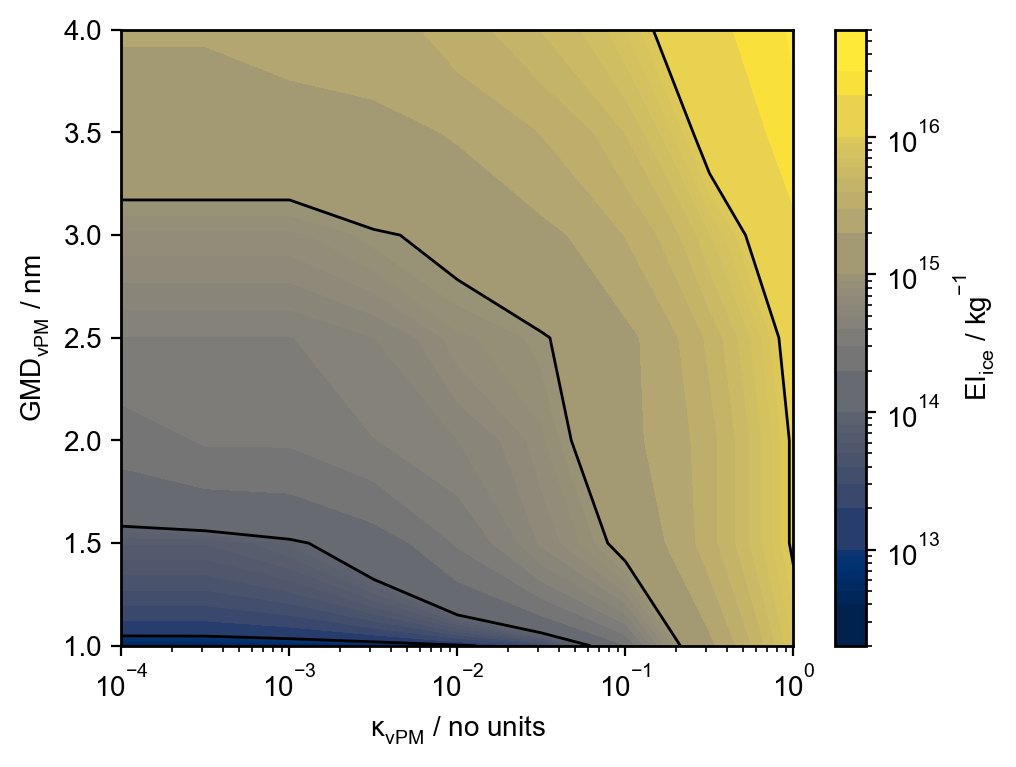

In [5]:
"""PLOTTING THE ABOVE"""

%matplotlib inline
%config InlineBackend.figure_format='retina'

plt.rcParams['mathtext.default'] = 'regular'
plt.rcParams["font.family"] = "Arial"
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['axes.formatter.useoffset'] = False
plt.rcParams["font.size"] = 10

x, y = np.meshgrid(kappa_vPM_array, GMD_vPM_array)

fig = plt.figure(figsize = (5, 4))
ax = fig.add_subplot(1, 1, 1)

import matplotlib.colors as mcolors
from matplotlib.ticker import ScalarFormatter

z_max = np.max(z)
z_min = np.min(z)

levels = np.array([1e12, 2e12, 3e12, 4e12, 5e12, 6e12, 7e12, 8e12, 9e12,
                   1e13, 2e13, 3e13, 4e13, 5e13, 6e13, 7e13, 8e13, 9e13,
                   1e14, 2e14, 3e14, 4e14, 5e14, 6e14, 7e14, 8e14, 9e14,
                   1e15, 2e15, 3e15, 4e15, 5e15, 6e15, 7e15, 8e15, 9e15,
                   1e16, 2e16, 3e16, 4e16, 5e16, 6e16, 7e16, 8e16, 9e16, 
                   1e17])

levels = levels[(levels > z_min/2) & (levels < z_max * 2)]  # Trim levels to be within [z_min, z_max]
log_norm = mcolors.LogNorm(vmin=z_min, vmax=z_max)

contour_lines = plt.contour(x, y/1e-9, z, levels=[1e13, 1e14, 1e15, 1e16], colors='black', linewidths=1)

plt.contourf(x, y/1e-9, z, levels=levels, norm=log_norm, cmap='cividis')


cbar = plt.colorbar(label = 'EI$_{ice}$ / kg$^{-1}$')
cbar.set_ticks([1e13, 1e14, 1e15, 1e16])
cbar.set_ticklabels([r'$10^{13}$', r'$10^{14}$', r'$10^{15}$', r'$10^{16}$'])  # Use scientific notation

cbar.ax.minorticks_on()

ax.set_xlabel('$\kappa$$_{vPM}$ / no units')
ax.set_ylabel('GMD$_{vPM}$ / nm')

# ax.set_xlim([])
# ax.set_ylim([1, 10])

ax.set_xscale("log")
# ax.set_yscale("log")

# ax.set_xticks([1e2, 1e4, 1e6, 1e8, 1e10, 1e12, 1e14, 1e16])
# ax.set_yticks([1, 10, 100])

plt.subplots_adjust(left = 0.1, right = 0.94, bottom = 0.17, top = 0.94, wspace = 0.27, hspace = 0.2)
plt.savefig(f"/Users/jrp21/Desktop/second.svg", dpi = 1000)

plt.show()

import xarray as xr

xarray = xr.DataArray(z, coords=[('y', GMD_vPM_array), ('x', kappa_vPM_array)], name='z')
xarray.to_netcdf('/Users/jrp21/Desktop/second.nc')

In [495]:
GMD_vPM_array = np.linspace(1e-9, 4e-9, 4)

print(GMD_vPM_array)

[1.e-09 2.e-09 3.e-09 4.e-09]


In [29]:
"""EXPLORING DEPENDENCE ON VPM PARAMETERS (2)"""

import matplotlib.pyplot as plt
import matplotlib.colors

import matplotlib as mpl

%matplotlib inline
%config InlineBackend.figure_format='retina'

plt.rcParams['mathtext.default'] = 'regular'
plt.rcParams["font.family"] = "Arial"
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['axes.formatter.useoffset'] = False
plt.rcParams["font.size"] = 24

EI_vPM_array = np.logspace(15, 17, 10)
Dp_vPM_array = np.linspace(1e-9, 10e-9, 10)
# Dp_vPM_array = np.logspace(-9, -7, 50)

x, y = np.meshgrid(EI_vPM_array, Dp_vPM_array)

f_vectorized = np.vectorize(f_EIi)
z = f_vectorized(x, y)

fig = plt.figure(figsize = (7.5, 4.7))
ax = fig.add_subplot(1, 1, 1)

from cmcrameri import cm
cmap = cm.devon_r

regular_contour_lines = np.arange(1.5, np.ceil(np.nanmax(z)), 0.5)
specific_contour_lines = np.arange(0.6, 1.1, 0.1)
contour_lines = np.concatenate([specific_contour_lines, regular_contour_lines])

simple_contour_lines = np.arange(0, 20, 0.5)
white_contour = plt.contour(x, y/1e-9, z, levels = np.array([50]), colors='white', linewidths=1.5, font = "arial")
label = plt.clabel(white_contour, fmt='%.0f', colors='white', inline=True, fontsize=24)

for l in label:
    l.set_rotation(0)

contour = plt.contourf(x, y/1e-9, z, levels = np.arange(0, np.nanmax(z) + 10, 10), cmap = cmap)
cbar = fig.colorbar(contour, ax = ax, label = 'ice-residuals$_{vPM}$ / %', format='%.0f')

ax.set_ylim([1, 10])
ax.set_yticks([1, 3, 5, 7, 9])

ax.set_xscale("log")
ax.set_xscale("log")

plt.tick_params(which='minor', width=1.5, length = 2)
plt.tick_params(which='major', width=1.5, length = 5)
cbar.ax.tick_params(width = 1.5)

"""AXIS PARAMETERS"""

import matplotlib as mpl

mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['mathtext.it'] = 'Arial: italic'

plt.ylabel("$\it{d}$$_{p, vPM}$ / nm", fontsize = 24)
plt.xlabel("EI$_{vPM}$" + " / (kg-fuel)$^{-1}$")

plt.tight_layout()
plt.savefig(f"/Users/jrp21/Desktop/213 K - 1e13.png", dpi = 600)
plt.show()

NameError: name 'f_EIi' is not defined

In [8]:
"""
Making the code into a function so that the number concentration at peak supersaturation can be output as a function of input parameters 
(including particle properties and contrail mixing properties)
"""

from pyrcel import binned_activation

# Functions for estimating the saturation ratio

def es(T): # pyrcel implementation of es(T)
    return 611.2 * np.exp(17.67 * T / (T + 243.5)) 

def p_i_0(T): # ice saturation
    
    return np.exp(9.550426 - 5723.265/T + 3.53068 * np.log(T) - 0.00728332*T) 

def p_mw(T, T_a): # water vapour pressure along the contrail mixing line 
        
    p_wa = p_i_0(T_a) * 1.1 # assume the mixing line terminates with a water vapour partial pressure = ice saturation
                    
    return p_wa + 1.64 * (T - T_a) 

def Smw(T, T_a): 
        return p_mw(T, T_a)/es(T-273.15)

# Function for estimating the droplet number concentration

def n_droplets(T_a, T_e, P0, 
               n_ambient, GMD_ambient, GSD_ambient, kappa_ambient, bins_ambient, 
               EI_vPM, GMD_vPM, GSD_vPM, kappa_vPM, bins_vPM,
               EI_nvPM, GMD_nvPM, GSD_nvPM, kappa_nvPM, bins_nvPM,
               T_start, dt, t_end, RHi, G):

    # Define the supersaturation at the initial model temperature

    print(G, T_a)

    S0 = Smw(T_start, T_a) - 1 # water supersaturation at initial model temperature / K 

    # Initialise particle modes, note that mu = GRD of mode in micrometers

    N0_nvPM = (EI_nvPM * (P0 * 28.96e-3) / (8.3145 * T_e)) / 60 / 1e6 # initial number concentration of soot particles, particles per cm^3
    N0_vPM = (EI_vPM * (P0 * 28.96e-3) / (8.3145 * T_e)) / 60 / 1e6 # initial number concentration of soot particles, particles per cm^3

    ambient =  pm.AerosolSpecies('ambient',
                                pm.Lognorm(mu=GMD_ambient * 0.5e6, sigma=GSD_ambient, N=n_ambient),
                                kappa=kappa_ambient, bins=int(bins_ambient))
                                
    vPM =  pm.AerosolSpecies('vPM',
                                pm.Lognorm(mu=GMD_vPM * 0.5e6, sigma=GSD_vPM, N=N0_vPM),
                                kappa=kappa_vPM, bins=int(bins_vPM))

    nvPM =  pm.AerosolSpecies('nvPM',
                                pm.Lognorm(mu=GMD_nvPM * 0.5e6, sigma=GSD_nvPM, N=N0_nvPM),
                                kappa=kappa_nvPM, bins=int(bins_nvPM))                              

    initial_aerosols = [vPM, nvPM, ambient]

    # Model initialisation and calculation

    model = pm.ParcelModel(initial_aerosols, np.array([T_a, P0, RHi, G, T_e]), T_start, S0, P0, console=False, accom=1.0, truncate_aerosols=True) # array for Ta gives room for any parameters to be passed into the model i.e., 

    parcel_trace, aerosol_traces = model.run(t_end, dt, solver='cvode')

    # Maximum supersaturation

    S_max = np.max(parcel_trace['S']) * 100 # maximum plume supersaturation achieved / %
    idxmax = np.argmax(parcel_trace['S']) # index of above

    "recent"

    T_of_interest = 230
    T_x = np.argmin(np.abs(parcel_trace['T'] - 230))

    nvPM_trace = aerosol_traces['nvPM']
    vPM_trace = aerosol_traces['vPM']
    ambient_trace = aerosol_traces['ambient']

    max_n_vPM = binned_activation(parcel_trace['S'].iloc[T_x], parcel_trace['T'].iloc[T_x], vPM_trace.iloc[T_x],  vPM, T_a, P0, T_e) # activated fractions at maximum supersaturation
    max_n_nvPM = binned_activation(parcel_trace['S'].iloc[T_x], parcel_trace['T'].iloc[T_x], nvPM_trace.iloc[T_x],  nvPM, T_a, P0, T_e) # activated fractions at maximum supersaturation
    max_n_ambient = binned_activation(parcel_trace['S'].iloc[T_x], parcel_trace['T'].iloc[T_x], ambient_trace.iloc[T_x],  ambient, T_a, P0, T_e) # activated fractions at maximum supersaturation

    max_n_total = (max_n_nvPM + max_n_vPM + max_n_ambient)

    return max_n_total

# exploring vPM sensitivity (1/2)
 
import matplotlib.pyplot as plt
import matplotlib as mpl

# Define contrail properties

T_a = 213 # ambient temperature / K
T_e = 600.0 # exhaust temperature
P0 = 22919.5 # (cruise) pressure, Pa 

RHi = 1.0
G = 1.64

# Define particle properties

n_ambient = 600 # number concentration of ambient particles / cm^-3 # Kärcher 2015

EI_nvPM = 1e12 # emission index of nvPM particles, particles per kg of fuel burned
EI_vPM = 1e17 # emission index of vPM particles, particles per kg of fuel burned

GMD_ambient, GSD_ambient, kappa_ambient = 30.0e-9, 2.2, 0.500001 # must specify the ambient mode with this kappa value otherwise the code will fail # Kärcher 2015
GMD_nvPM, GSD_nvPM, kappa_nvPM = 35.0e-9, 2.0, 0.005
GMD_vPM, GSD_vPM, kappa_vPM = 2.5e-9, 1.3, 0.5
bins_nvPM, bins_ambient, bins_vPM = 50, 50, 250

# Define model properties

T_start = 300.0 # initial model (not the ambient temperature) temperature / K
dt = 0.0001 # timestep / s
t_end = 0.5 # end time / s

# Dependent variables

# G_array = np.linspace(1.1, 2.2, 5)
# T_array = np.linspace(213, 223, 5)

# final test before mid-save file 

# G_array = np.arange(1.0, 2.2, 0.2)
# T_array = np.array([213, 215, 217, 219, 221, 223])[::-1]

# new test with mid-save file

G_array = np.arange(1.0, 2.3, 0.1)
# T_array = np.arange(213, 224, 1)[::-1]

# Additional temperatures to insert
T_array = np.array([220.5, 221.5, 222.5, 223.5])

# extremal test

# G_array = np.array([1.1, 2.2])
# T_array = np.array([213, 221])

x, y = np.meshgrid(G_array, T_array)

# f_vectorized = np.vectorize(n_droplets)
# z = f_vectorized(y, T_e, P0, 
#                n_ambient, GMD_ambient, GSD_ambient, kappa_ambient, bins_ambient, 
#                EI_vPM, GMD_vPM, GSD_vPM, kappa_vPM, bins_vPM,
#                EI_nvPM, GMD_nvPM, GSD_nvPM, kappa_nvPM, bins_nvPM,
#                T_start, dt, t_end, RHi, x)

T_array

array([220.5, 221.5, 222.5, 223.5])

In [9]:
# original code for updating as we go

import numpy as np
import os

# Path to save progress
checkpoint_file = "/Users/jrp21/Desktop/test.npy"

# Initialize or load the checkpointed `z` array
if os.path.exists(checkpoint_file):
    z = np.load(checkpoint_file)
    print("Checkpoint loaded.")
else:
    z = np.full((len(T_array), len(G_array)), np.nan)  # Fill with NaNs initially

# Loop through elements of the meshgrid
for i, temp in enumerate(T_array):
    for j, G in enumerate(G_array):
        if np.isnan(z[i, j]):  # Skip already-computed values
            try:
                z[i, j] = n_droplets(
                    temp, T_e, P0, 
                    n_ambient, GMD_ambient, GSD_ambient, kappa_ambient, bins_ambient, 
                    EI_vPM, GMD_vPM, GSD_vPM, kappa_vPM, bins_vPM,
                    EI_nvPM, GMD_nvPM, GSD_nvPM, kappa_nvPM, bins_nvPM,
                    T_start, dt, t_end, RHi, G
                )
                # Save progress after each computation
                np.save(checkpoint_file, z)
            except Exception as e:
                print(f"Failed at T={temp}, G={G}: {e}")

def safe_compute(func, retries=3, **kwargs):
    for attempt in range(retries):
        try:
            return func(**kwargs)
        except Exception as e:
            print(f"Attempt {attempt + 1} failed: {e}")
    print("Max retries reached. Skipping computation.")
    return np.nan  # Mark as missing


1.0 220.5


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


1.1 220.5
1.2000000000000002 220.5
1.3000000000000003 220.5
1.4000000000000004 220.5
1.5000000000000004 220.5
1.6000000000000005 220.5
1.7000000000000006 220.5
1.8000000000000007 220.5
1.9000000000000008 220.5
2.000000000000001 220.5
2.100000000000001 220.5
2.200000000000001 220.5
1.0 221.5
1.1 221.5
1.2000000000000002 221.5
1.3000000000000003 221.5
1.4000000000000004 221.5
1.5000000000000004 221.5
1.6000000000000005 221.5
1.7000000000000006 221.5
1.8000000000000007 221.5
1.9000000000000008 221.5
2.000000000000001 221.5
2.100000000000001 221.5
2.200000000000001 221.5
1.0 222.5
1.1 222.5
1.2000000000000002 222.5
1.3000000000000003 222.5
1.4000000000000004 222.5
1.5000000000000004 222.5
1.6000000000000005 222.5
1.7000000000000006 222.5
1.8000000000000007 222.5
1.9000000000000008 222.5
2.000000000000001 222.5
2.100000000000001 222.5
2.200000000000001 222.5
1.0 223.5
1.1 223.5
1.2000000000000002 223.5
1.3000000000000003 223.5
1.4000000000000004 223.5
1.5000000000000004 223.5
1.600000000000

In [10]:
import xarray as xr

G_array = np.arange(1.0, 2.3, 0.1)
T_array = np.arange(213, 224, 1)[::-1]

print(G_array, T_array)

xarray = xr.DataArray(z, coords=[('y', T_array), ('x', G_array)], name='z')
xarray.to_netcdf('/Users/jrp21/Desktop/modelling_conditions_G_Ta_sensitivity_data.nc')

[1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7 1.8 1.9 2.  2.1 2.2] [223 222 221 220 219 218 217 216 215 214 213]


ValueError: conflicting sizes for dimension 'y': length 2 on the data but length 11 on coordinate 'y'

ValueError: Invalid vmin or vmax

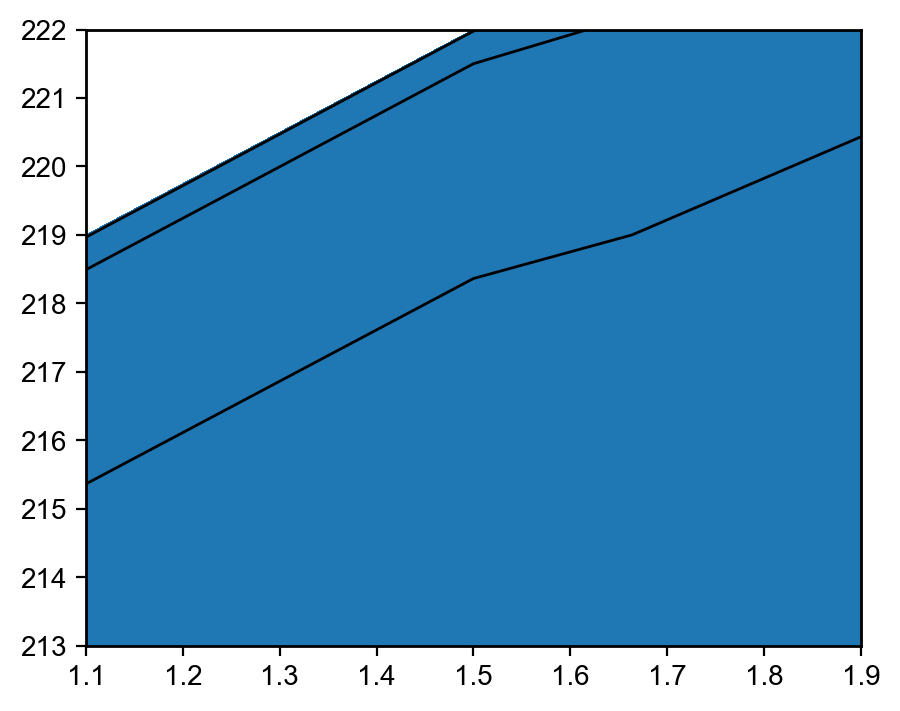

In [7]:
"""PLOTTING THE ABOVE"""

%matplotlib inline
%config InlineBackend.figure_format='retina'

plt.rcParams['mathtext.default'] = 'regular'
plt.rcParams["font.family"] = "Arial"
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['axes.formatter.useoffset'] = False
plt.rcParams["font.size"] = 10

fig = plt.figure(figsize = (5, 4))
ax = fig.add_subplot(1, 1, 1)

import matplotlib.colors as mcolors
from matplotlib.ticker import ScalarFormatter

z_max = np.nanmax(z)
z_min = np.nanmin(z)

levels = np.array([1e12, 2e12, 3e12, 4e12, 5e12, 6e12, 7e12, 8e12, 9e12,
                   1e13, 2e13, 3e13, 4e13, 5e13, 6e13, 7e13, 8e13, 9e13,
                   1e14, 2e14, 3e14, 4e14, 5e14, 6e14, 7e14, 8e14, 9e14,
                   1e15, 2e15, 3e15, 4e15, 5e15, 6e15, 7e15, 8e15, 9e15,
                   1e16, 2e16, 3e16, 4e16, 5e16, 6e16, 7e16, 8e16, 9e16, 
                   1e17])

levels = levels[(levels > z_min/2) & (levels < z_max * 2)]  # Trim levels to be within [z_min, z_max]
log_norm = mcolors.LogNorm(vmin=z_min, vmax=z_max)

contour_lines = plt.contour(x, y, z, levels=[1e13, 1e14, 1e15, 1e16], colors='black', linewidths=1)

plt.contourf(x, y, z, levels=levels, norm=log_norm, cmap='cividis')

cbar = plt.colorbar(label = 'EI$_{ice}$ / kg$^{-1}$')
cbar.set_ticks([1e13, 1e14, 1e15, 1e16])
cbar.set_ticklabels([r'$10^{13}$', r'$10^{14}$', r'$10^{15}$', r'$10^{16}$'])  # Use scientific notation

cbar.ax.minorticks_on()

ax.set_xlabel('G / no units')
ax.set_ylabel('T / K')

plt.subplots_adjust(left = 0.1, right = 0.94, bottom = 0.17, top = 0.94, wspace = 0.27, hspace = 0.2)
plt.savefig(f"/Users/jrp21/Desktop/second.svg", dpi = 1000)

plt.show()

import xarray as xr

xarray = xr.DataArray(z, coords=[('y', T_array), ('x', G_array)], name='z')
xarray.to_netcdf('/Users/jrp21/Desktop/d.nc')

In [130]:
G_array = np.arange(1.1, 2.3, 0.1)
T_array = np.arange(213, 224, 1)

T_array

array([213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223])

In [70]:
nvPM_trace = aerosol_traces['nvPM']
vPM_trace = aerosol_traces['vPM']

N0_nvPM = (EI_nvPM * (P0 * 28.96e-3) / (8.3145 * T_e)) / 60 / 1e6 # initial number concentration of soot particles, particles per cm^3
N0_vPM = (EI_vPM * (P0 * 28.96e-3) / (8.3145 * T_e)) / 60 / 1e6 # initial number concentration of soot particles, particles per cm^3

vPM =  pm.AerosolSpecies('vPM',
                            pm.Lognorm(mu=GMD_vPM * 0.5e6, sigma=GSD_vPM, N=N0_vPM),
                            kappa=kappa_vPM, bins=int(bins_vPM))

nvPM =  pm.AerosolSpecies('nvPM',
                            pm.Lognorm(mu=GMD_nvPM * 0.5e6, sigma=GSD_nvPM, N=N0_nvPM),
                            kappa=kappa_nvPM, bins=int(bins_nvPM))   

aerosol_mode_vPM = []
liquid_mode_vPM = []
ice_mode_vPM = []

aerosol_mode_nvPM = []
liquid_mode_nvPM = []
ice_mode_nvPM = []

T_vals = []

S_max_index = np.argmax(parcel_trace['S'])

for i in np.arange(1, len(parcel_trace['S']), 20):

    aerosol_mode_conc, aerosol_mode_radius, liquid_mode_conc, liquid_mode_radius, ice_mode_conc, ice_mode_radius = binned_activation(parcel_trace['S'].iloc[i], parcel_trace['T'].iloc[i], nvPM_trace.iloc[i],  nvPM, T_a)
    aerosol_mode_conc1, aerosol_mode_radius1, liquid_mode_conc1, liquid_mode_radius1, ice_mode_conc1, ice_mode_radius1 = binned_activation(parcel_trace['S'].iloc[i], parcel_trace['T'].iloc[i], vPM_trace.iloc[i],  vPM, T_a)

    aerosol_mode_nvPM.append(np.sum(aerosol_mode_conc))
    liquid_mode_nvPM.append(np.sum(liquid_mode_conc))
    ice_mode_nvPM.append(np.sum(ice_mode_conc))

    aerosol_mode_vPM.append(np.sum(aerosol_mode_conc1))
    liquid_mode_vPM.append(np.sum(liquid_mode_conc1))
    ice_mode_vPM.append(np.sum(ice_mode_conc1))
    
    T_vals.append(parcel_trace['T'].iloc[i])

aerosol_mode_array_vPM = np.array(aerosol_mode_vPM)
liquid_mode_array_vPM = np.array(liquid_mode_vPM)
ice_mode_array_vPM = np.array(ice_mode_vPM)

aerosol_mode_array_nvPM = np.array(aerosol_mode_nvPM)
liquid_mode_array_nvPM = np.array(liquid_mode_nvPM)
ice_mode_array_nvPM = np.array(ice_mode_nvPM)

T_vals_array = np.array(T_vals)

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
58258985654075.88
3521429623423547.0
8235928445105637.0
9182346400161696.0
9182346400161692.0
9182346400161692.0
9182346400161696.0
9182346400161692.0
9182346400161694.0
9182346400161692.0
9182346400161694.0
9182346400161694.0
9182346400161692.0
9182346400161692.0
9182346400161692.0
9182346400161692.0
9182346400161692.0
9182346400161692.0
9182346400161694.0
9182346400161690.0
9182346400161694.0
9182346400161694.0
9182346400161694.0
9182346400161692.0
9182346400161694.0
9182346400161692.0
9182346400161692.0
9182346400161694.0
9182346400161694.0
9182346400161694.0
9182346400161692.0
9182346400161692.0
9182346400161692.0
9182346400161692.0
9182346400161692.0
9182346400161694.0
9182346400161694.0
9182346400161694.0
9182346400161692.0
9182346400161692.0
9182346400161692.0
9182346400161696.0
9182346400161694.0
91823464

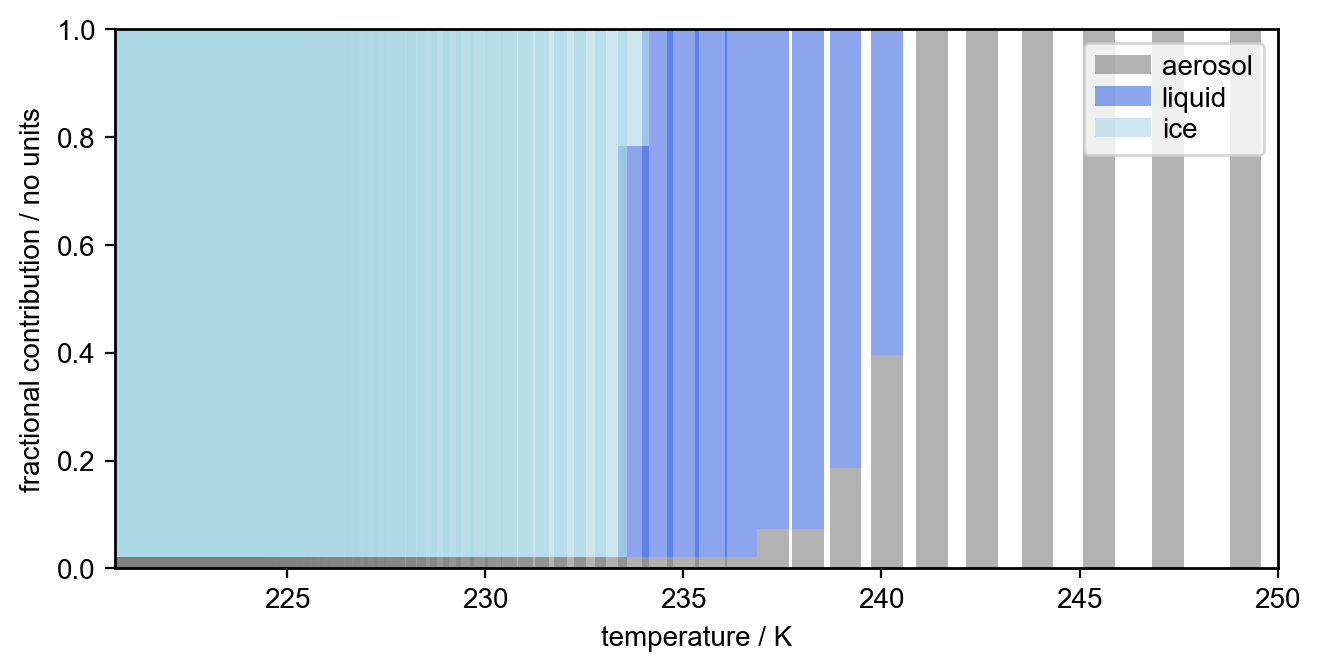

In [47]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

plt.rcParams['mathtext.default'] = 'regular'
plt.rcParams["font.family"] = "Arial"
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['axes.formatter.useoffset'] = False
plt.rcParams["font.size"] = 10

fig = plt.figure(figsize = (7.5, 3.5))

ax = fig.add_subplot(1, 1, 1)

# Example arrays with fractional values
array1 = aerosol_mode_array_nvPM
array2 = liquid_mode_array_nvPM
array3 = ice_mode_array_nvPM

# Normalize each array by dividing by the sum of all arrays for each category
total_sum = array1 + array2 + array3
array1_normalized = array1 / total_sum
array2_normalized = array2 / total_sum
array3_normalized = array3 / total_sum

# Stacked bar plot
ax.bar(T_vals_array, array1_normalized, label='aerosol', color = "grey", alpha = 0.6)
ax.bar(T_vals_array, array2_normalized, bottom=array1_normalized, label='liquid', color = "royalblue", alpha = 0.6)
ax.bar(T_vals_array, array3_normalized, bottom=array1_normalized+array2_normalized, label='ice', color = "lightblue", alpha = 0.6)

ax.set_ylabel('fractional contribution / no units')
ax.set_xlabel('temperature / K')

ax.set_xlim([min(np.array(parcel_trace["T"])), 250])

# ax.set_yscale("log")
# ax.set_ylim([0.9, 1])

ax.legend(handletextpad = 0.4, labelspacing = 0.2)

plt.savefig(f"/Users/jrp21/Desktop/stacked_bar_chart_{EI_nvPM:.1e}_vPM_{EI_vPM:.1e}_205_vPM_vPM_only.png", dpi = 500)
plt.show()

In [7]:
# iterating to find the droplet number concentration at peak supersaturation as a function of EI nvPM, including vPM in the calculations

from pyrcel import binned_activation

# Define contrail properties

T_a = 217 # ambient temperature / K
T_e = 600.0 # exhaust temperature
P0 = 22919.5 # (cruise) pressure, Pa 

# Define particle properties

n_ambient = 600 # number concentration of ambient particles / cm^-3
EI_nvPM = 1e15 # emission index of nvPM particles, particles per kg of fuel burned
EI_vPM = 1e17 # emission index of vPM particles, particles per kg of fuel burned

GMD_ambient, GSD_ambient, kappa_ambient = 30.0e-9, 1.6, 0.500001 # must specify the ambient mode with this kappa value otherwise the code will fail
GMD_nvPM, GSD_nvPM, kappa_nvPM = 30.0e-9, 2.0, 0.005
GMD_vPM, GSD_vPM, kappa_vPM = 2e-9, 1.4, 0.005
bins_nvPM, bins_ambient, bins_vPM = 50, 30, 50

# Define model properties

T_start = 400.0 # initial model (not the ambient temperature) temperature / K
dt = 0.001 # timestep / s
t_end = 0.8 # end time / s

n_0_list = []

EI_nvPM_array = np.logspace(10, 14, 10)

for index, value in enumerate(EI_nvPM_array):

    print(index)

    n = n_droplets(T_a, T_e, P0, 
               n_ambient, GMD_ambient, GSD_ambient, kappa_ambient, bins_ambient, 
               EI_vPM, GMD_vPM, GSD_vPM, kappa_vPM, bins_vPM,
               value, GMD_nvPM, GSD_nvPM, kappa_nvPM, bins_nvPM,
               T_start, dt, t_end)
    
    n_0_list.append(n)

# plotting

%matplotlib inline
%config InlineBackend.figure_format='retina'

plt.rcParams['mathtext.default'] = 'regular'
plt.rcParams["font.family"] = "Arial"
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['axes.formatter.useoffset'] = False
plt.rcParams["font.size"] = 10

fig = plt.figure(figsize = (7.5, 4))

ax = fig.add_subplot(1, 1, 1)

ax.plot(EI_nvPM_array, n_0_list, linewidth = 1, color = "black")
ax.plot(EI_nvPM_array, EI_nvPM_array, linewidth = 1, color = "black", linestyle = "--")

ax.scatter(EI_nvPM_array, n_0_list, edgecolor = "black", color = "white", s = 15, linewidth = 1)

ax.set_xscale("log")
ax.set_yscale("log")

ax.set_ylim([1e12, 1e18])

# ax.set_ylabel("n$_{0, w}$" + " / cm$^{-3}$")
ax.set_ylabel("EI$_{ice}$ / particles (kg-fuel)$^{-1}$")
ax.set_xlabel("EI$_{nvPM}$ / particles (kg-fuel)$^{-1}$")

plt.tight_layout()

plt.savefig("/Users/jrp21/Desktop/218.png", dpi = 500)

plt.show()

0


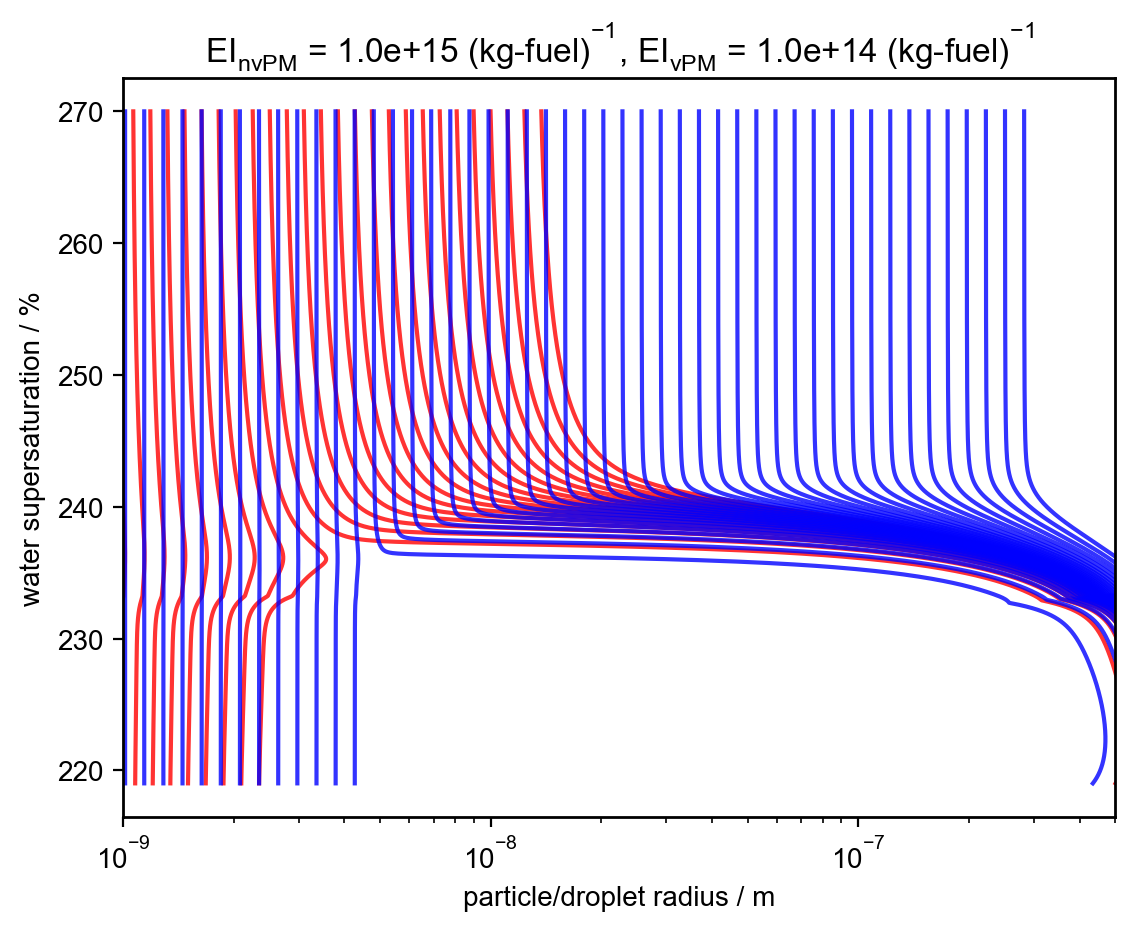

In [94]:
# looking at radial growth (3/Y)

# 100 * (parcel_trace["S"] + 1) is in units of % RH i.e., a value of 100 is water-saturated conditions 

# idxmax = np.argmax(parcel_trace['S']) + 1300
idxmax = len(parcel_trace['S'])

nvPM_array = aerosol_traces['nvPM'].values # this is an array of the form [[a], [b], [c], ... [n]] where n is the number of particle size bins. In other words we have an array that gives the particle radius in each bin
vPM_array = aerosol_traces['vPM'].values

S_array = 100 * (np.array(parcel_trace["S"]))
T_array = np.array(parcel_trace["T"])

def filter_to_s_max(arr, idxmax):
    return arr[0:idxmax]

nvPM_array, vPM_array, S_array, T_array = filter_to_s_max(nvPM_array, idxmax), filter_to_s_max(vPM_array, idxmax), filter_to_s_max(S_array, idxmax), filter_to_s_max(T_array, idxmax)

plt.plot(vPM_array[:, ::1], T_array,  color = "red", alpha = 0.8)
plt.plot(nvPM_array[:, ::1], T_array, color = "blue", alpha = 0.8)

plt.xlabel("particle/droplet radius / m")
plt.ylabel("water supersaturation / %")

# plt.ylim([-100, 100])
plt.xlim([1e-9, 5e-7])

plt.xscale("log")

plt.title(f"EI$_{{nvPM}}$ = {EI_nvPM:.1e} (kg-fuel)$^{{-1}}$, EI$_{{vPM}}$ = {EI_vPM:.1e} (kg-fuel)$^{{-1}}$")
plt.savefig(f"/Users/jrp21/Desktop/line_graph_nvPM_{EI_nvPM:.1e}_vPM_{EI_vPM:.1e}.png", dpi = 500)

plt.show()

In [95]:
# preparing number concentration of various particle modes during dilution - note the units on the particle number concentrations

N0_nvPM = (EI_nvPM * (P0 * 28.96e-3) / (8.3145 * T_e)) / 60 / 1e6 # initial number concentration of soot particles, particles per m^3
N0_vPM = (EI_vPM * (P0 * 28.96e-3) / (8.3145 * T_e)) / 60 / 1e6 # initial number concentration of soot particles, particles per m^3
                            
vPM =  pm.AerosolSpecies('vPM',
                            pm.Lognorm(mu=GMD_vPM * 0.5e6, sigma=GSD_vPM, N=N0_vPM),
                            kappa=kappa_vPM, bins=int(bins_vPM))

nvPM =  pm.AerosolSpecies('nvPM',
                            pm.Lognorm(mu=GMD_nvPM * 0.5e6, sigma=GSD_nvPM, N=N0_nvPM),
                            kappa=kappa_nvPM, bins=int(bins_nvPM))         

nvPM_Ni0 = nvPM.Nis # this is the initial number concentration in each bin in /m^3 
vPM_Ni0 = vPM.Nis 

S = S_array
T = T_array

def es(T):
    return 611.2 * np.exp(17.67 * T / (T + 243.5))

P = P0
pv_sat = es(T - 273.15)  # saturation vapor pressure
e = (1.0 + S/100) * pv_sat  # water vapor pressure
rho_air_dry = (P - e) / (8.314/(28.9/1e3))/ T

expansion_time = 10e-3 * ((T_e - T_a) / (T - T_a)) ** (1/0.9)
dilution_parameter = np.where(expansion_time > 10e-3, (10e-3/expansion_time) ** 0.9, 1) # dilution parameter as a function of expansion time
dilution_factor = dilution_parameter * (rho_air_dry)/((22919.5 * 28.96e-3) / (8.3145 * T_e))

nvPM_Ni_diluted = (np.outer(dilution_factor, nvPM_Ni0))
vPM_Ni_diluted = (np.outer(dilution_factor, vPM_Ni0))

nvPM_Ni_diluted_external = np.sum(nvPM_Ni_diluted, axis = 1)
vPM_Ni_diluted_external = np.sum(vPM_Ni_diluted, axis = 1)

In [96]:
from scipy import interpolate

def interpolating_with_break_point(x, y, break_point_x_value, interpolation_r):

    # interpolation_r is the y_output

    x_mask_lower = (x < break_point_x_value)

    x_lower = x[x_mask_lower]
    y_lower = y[x_mask_lower]

    # make a mask for the interpolation range

    interpolated_r_mask_lower = (interpolation_r >= np.min(x_lower)) & (interpolation_r <= np.max(x_lower))
    interpolation_r_lower = interpolation_r[interpolated_r_mask_lower]

    # perform the interpolation

    interp_func_lower = interpolate.interp1d(x_lower, y_lower, kind='linear')
    vals_lower = interp_func_lower(interpolation_r_lower)   # use interpolation function returned by `interp1d`

    # made the nvPM confined between 1e-8 and max(x)

    x_mask_higher = (x >= 1e-8)

    x_higher = x[x_mask_higher]
    y_higher = y[x_mask_higher]

    # make a mask for the interpolation range

    interpolated_r_mask_higher = (interpolation_r >= np.min(x_higher)) & (interpolation_r <= np.max(x_higher))
    interpolation_r_higher = interpolation_r[interpolated_r_mask_higher]

    # perform the interpolation

    interp_func_higher = interpolate.interp1d(x_higher, y_higher, kind='linear')
    vals_higher = interp_func_higher(interpolation_r_higher)   # use interpolation function returned by `interp1d`

    # stitching the two segments together

    # define empty (zeros) concentration values

    original_vals = np.zeros_like(interpolation_r)

    # populate the empty list with the lower set

    lower_set_min = np.searchsorted(interpolation_r, interpolation_r_lower[0])
    lower_set_max = np.searchsorted(interpolation_r, interpolation_r_lower[-1])

    original_vals[lower_set_min:lower_set_max+1] = vals_lower

    # populate the empty list with the higher set

    # first, check that there is a droplet/ice crystal mode i.e., a higher interpolation set

    if len(interpolation_r_higher) > 0:

        higher_set_min = np.searchsorted(interpolation_r, interpolation_r_higher[0])
        higher_set_max = np.searchsorted(interpolation_r, interpolation_r_higher[-1])

        original_vals[higher_set_min:higher_set_max+1] = vals_higher

    return original_vals

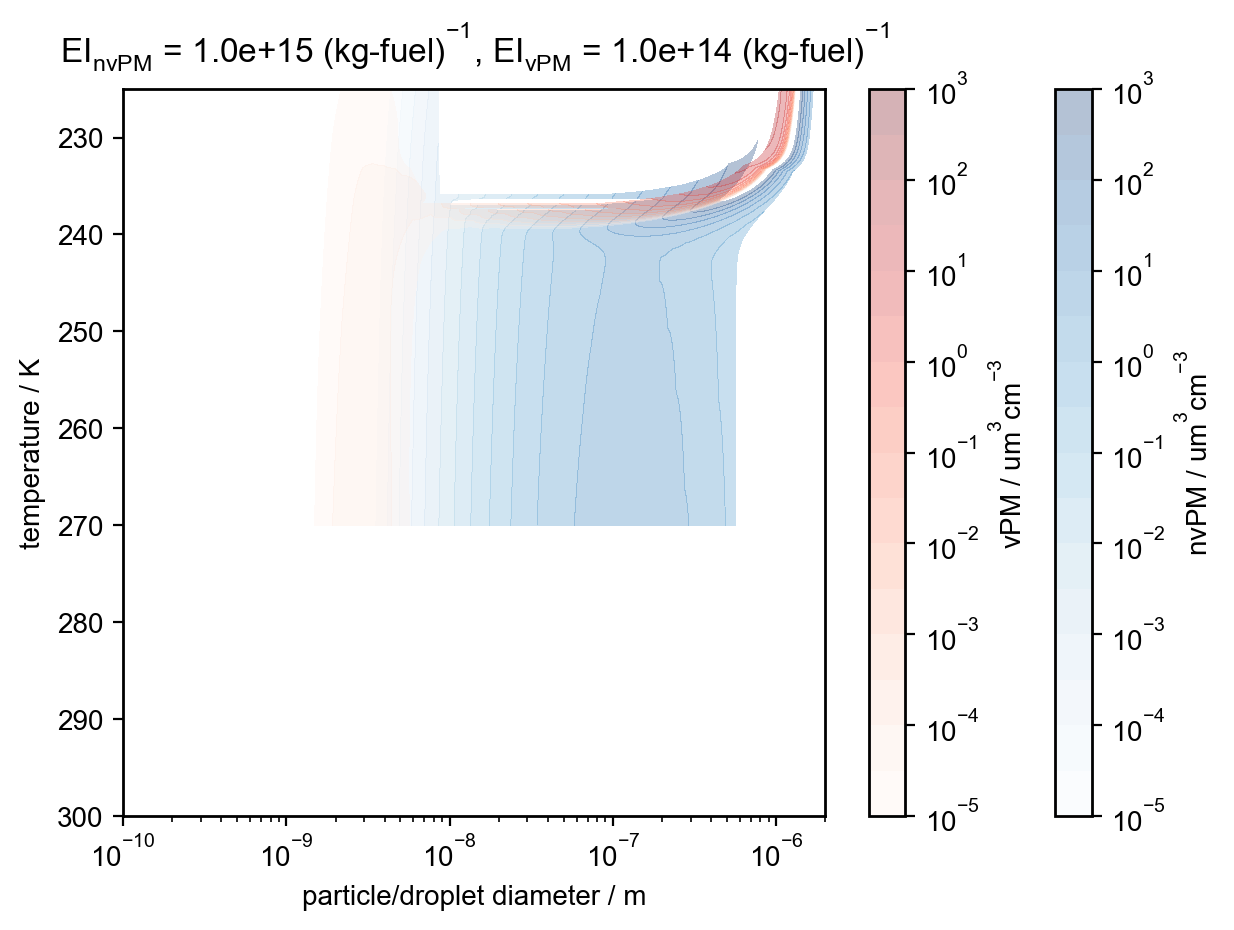

In [97]:
# volume - multiple modes separately

interpolation_r = np.logspace(-12, -5, 10000)

V_vPM_list = []
V_nvPM_list = []

for index, array in enumerate(nvPM_array):

    x_nvPM = nvPM_array[index]
    y_nvPM = nvPM_Ni_diluted[index]

    y_new_nvPM = interpolating_with_break_point(x_nvPM, y_nvPM, 4e-8, interpolation_r)
    V_nvPM = y_new_nvPM * 4/3 * np.pi * interpolation_r ** 3

    x_vPM = vPM_array[index]
    y_vPM = vPM_Ni_diluted[index]

    y_new_vPM = interpolating_with_break_point(x_vPM, y_vPM, 4e-8, interpolation_r)
    V_vPM = y_new_vPM * 4/3 * np.pi * interpolation_r ** 3

    V_vPM_list.append(V_vPM)
    V_nvPM_list.append(V_nvPM)

V_nvPM_array = np.array(V_nvPM_list) 
V_vPM_array = np.array(V_vPM_list) 

# plotting

from matplotlib import ticker, cm
from matplotlib.colors import Normalize

new_x = interpolation_r
new_y = T_array

new_z1 = np.log10(V_nvPM_array * 1e12) # conversion between m^3/m^3 and um^3/cm^3
new_z2 = np.log10(V_vPM_array * 1e12) 

# plotting

contour1 = plt.contourf(new_x * 2, new_y, new_z1, levels = np.arange(-5, 3.5, 0.5),   cmap = "Blues", alpha = 0.3)
contour2 = plt.contourf(new_x * 2, new_y, new_z2, levels = np.arange(-5, 3.5, 0.5),   cmap = "Reds", alpha = 0.3)

# middling_contour = plt.contour(new_x * 2, new_y, (10 ** new_z1)/(10 ** new_z2), levels = np.array([0.5]), colors='black', linewidths = 1, font = "arial", alpha = 0.5)
# label = plt.clabel(middling_contour, fmt = '%1.1f', colors = 'black', inline = True, fontsize=8)

# for l in label:
#     l.set_rotation(0)

plt.axhline(y = 0, color = "black", linewidth = 1, alpha = 0.1)
plt.axhline(y = 100 * np.max(parcel_trace['S']), color = "black", linewidth = 1, alpha = 0.5)

cbar1 = plt.colorbar(contour1)
cbar1.set_label('nvPM / um$^{{3}}cm^{{-3}}$')
cbar1.set_ticklabels([])

cbar2 = plt.colorbar(contour2)
cbar2.set_label('vPM / um$^{{3}}cm^{{-3}}$')
cbar2.set_ticklabels([])

cbar1.set_ticks(np.arange(-5, 3.5, 1))
cbar1.set_ticklabels(np.array([f"10$^{{-5}}$", f"10$^{{-4}}$", f"10$^{{-3}}$",f"10$^{{-2}}$",f"10$^{{-1}}$",f"10$^{0}$",f"10$^{1}$",f"10$^{2}$",f"10$^{3}$"]))

cbar2.set_ticks(np.arange(-5, 3.5, 1))
cbar2.set_ticklabels(np.array([f"10$^{{-5}}$", f"10$^{{-4}}$", f"10$^{{-3}}$",f"10$^{{-2}}$",f"10$^{{-1}}$",f"10$^{0}$",f"10$^{1}$",f"10$^{2}$",f"10$^{3}$"]))

plt.xscale("log")

plt.xlim([1e-10, 2e-6])
plt.ylim([300, 225])

plt.xlabel("particle/droplet diameter / m")
plt.ylabel("temperature / K")

plt.title(f"EI$_{{nvPM}}$ = {EI_nvPM:.1e} (kg-fuel)$^{{-1}}$, EI$_{{vPM}}$ = {EI_vPM:.1e} (kg-fuel)$^{{-1}}$", pad = 10)
plt.tight_layout()
plt.savefig(f"/Users/jrp21/Desktop/volume_modes_apart_{EI_nvPM:.1e}_vPM_{EI_vPM:.1e}.png", dpi = 500)
plt.show()

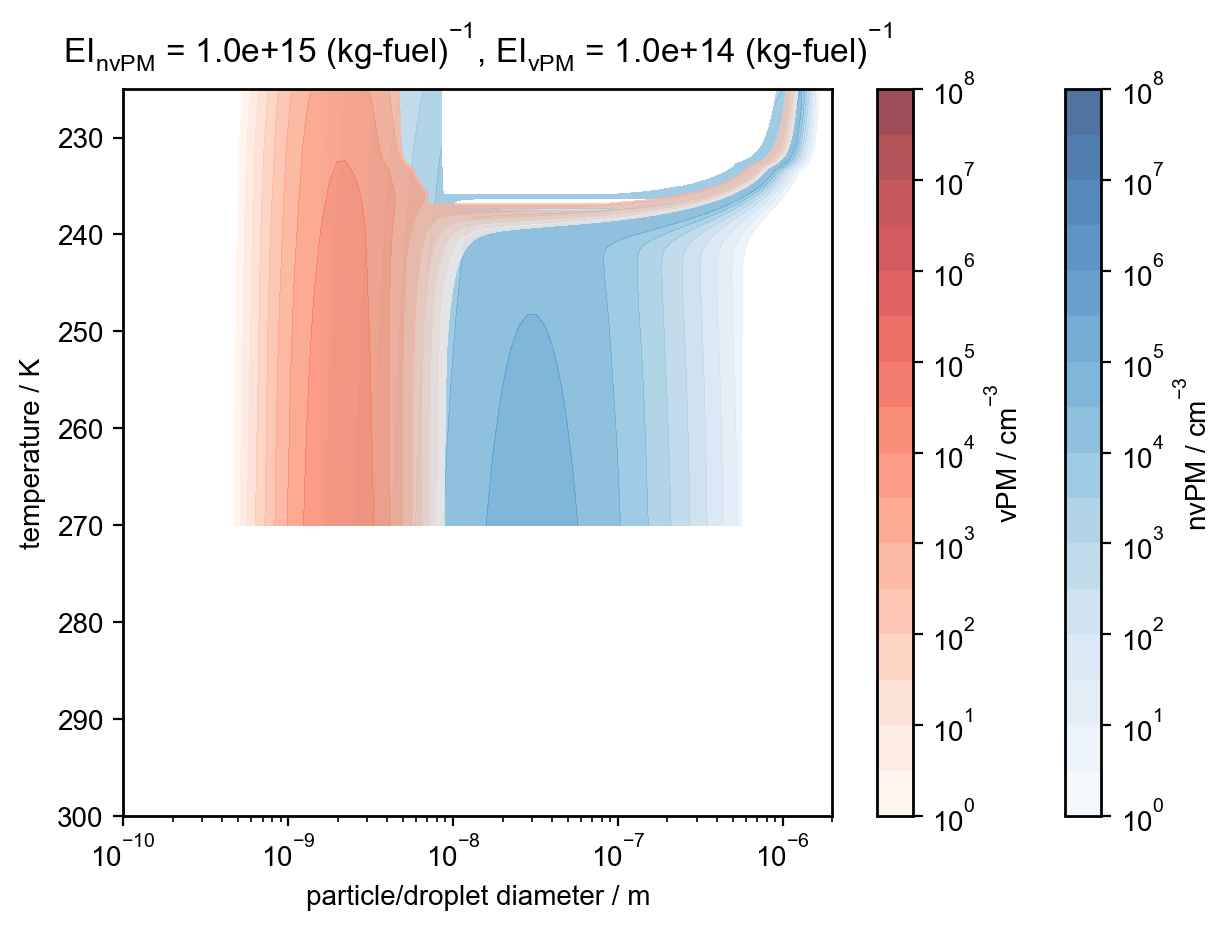

In [98]:
# conc - multiple modes separately

interpolation_r = np.logspace(-12, -5, 10000)

from scipy import interpolate

N_vPM_list = []
N_nvPM_list = []

for index, array in enumerate(nvPM_array):

    x_nvPM = nvPM_array[index]
    y_nvPM = nvPM_Ni_diluted[index]

    y_new_nvPM = interpolating_with_break_point(x_nvPM, y_nvPM, 4e-8, interpolation_r)

    x_vPM = vPM_array[index]
    y_vPM = vPM_Ni_diluted[index]

    y_new_vPM = interpolating_with_break_point(x_vPM, y_vPM, 4e-8, interpolation_r)

    N_vPM_list.append(y_new_vPM)
    N_nvPM_list.append(y_new_nvPM)

N_nvPM_array = np.array(N_nvPM_list) 
N_vPM_array = np.array(N_vPM_list) 

# plotting

from matplotlib import ticker, cm
from matplotlib.colors import Normalize

new_x = interpolation_r
new_y = T_array

new_z1 = np.log10(N_nvPM_array/1e6) # conversion from m^-3 (required for volume calculations) and cm^-3
new_z2 = np.log10(N_vPM_array/1e6)

# plotting

# contour1 = plt.contourf(new_x * 2, new_y, np.log10(10 ** new_z1 * new_x ** 2),  levels = 100, cmap = "Blues", alpha = 0.7)
# contour1 = plt.contourf(new_x * 2, new_y, np.log10(10 ** new_z1),  levels = 100, cmap = "Blues", alpha = 0.7)

contour1 = plt.contourf(new_x * 2, new_y, new_z1, levels = np.arange(0, 8.5, 0.5),   cmap = "Blues", alpha = 0.7)
contour2 = plt.contourf(new_x * 2, new_y, new_z2, levels = np.arange(0, 8.5, 0.5),   cmap = "Reds", alpha = 0.7)

# middling_contour = plt.contour(new_x * 2, new_y, (10 ** new_z1)/(10 ** new_z2), levels = np.array([0.5]), colors='black', linewidths = 1, font = "arial", alpha = 0.5)
# label = plt.clabel(middling_contour, fmt = '%1.1f', colors = 'black', inline = True, fontsize=8)

# for l in label:
#     l.set_rotation(0)

plt.axhline(y = 0, color = "black", linewidth = 1, alpha = 0.1)
plt.axhline(y = 100 * np.max(parcel_trace['S']), color = "black", linewidth = 1, alpha = 0.5)

cbar1 = plt.colorbar(contour1)
cbar1.set_label('nvPM / cm$^{{-3}}$')
# cbar1.set_ticklabels([])

cbar2 = plt.colorbar(contour2)
cbar2.set_label('vPM / cm$^{{-3}}$')
# cbar2.set_ticklabels([])

cbar1.set_ticks(np.arange(0, 8.5, 1))
cbar1.set_ticklabels(np.array([f"10$^{{0}}$", f"10$^{{1}}$", f"10$^{{2}}$",f"10$^{{3}}$",f"10$^{{4}}$",f"10$^{{5}}$",f"10$^{{6}}$",f"10$^{{7}}$",f"10$^{{8}}$"]))

cbar2.set_ticks(np.arange(0, 8.5, 1))
cbar2.set_ticklabels(np.array([f"10$^{{0}}$", f"10$^{{1}}$", f"10$^{{2}}$",f"10$^{{3}}$",f"10$^{{4}}$",f"10$^{{5}}$",f"10$^{{6}}$",f"10$^{{7}}$",f"10$^{{8}}$"]))

plt.xscale("log")

plt.xlim([1e-10, 2e-6])
plt.ylim([300, 225])

plt.xlabel("particle/droplet diameter / m")
plt.ylabel("temperature / K")

plt.title(f"EI$_{{nvPM}}$ = {EI_nvPM:.1e} (kg-fuel)$^{{-1}}$, EI$_{{vPM}}$ = {EI_vPM:.1e} (kg-fuel)$^{{-1}}$", pad = 10)
plt.tight_layout()
plt.savefig(f"/Users/jrp21/Desktop/conc_modes_apart_{EI_nvPM:.1e}_vPM_{EI_vPM:.1e}_test.png", dpi = 500)
plt.show()


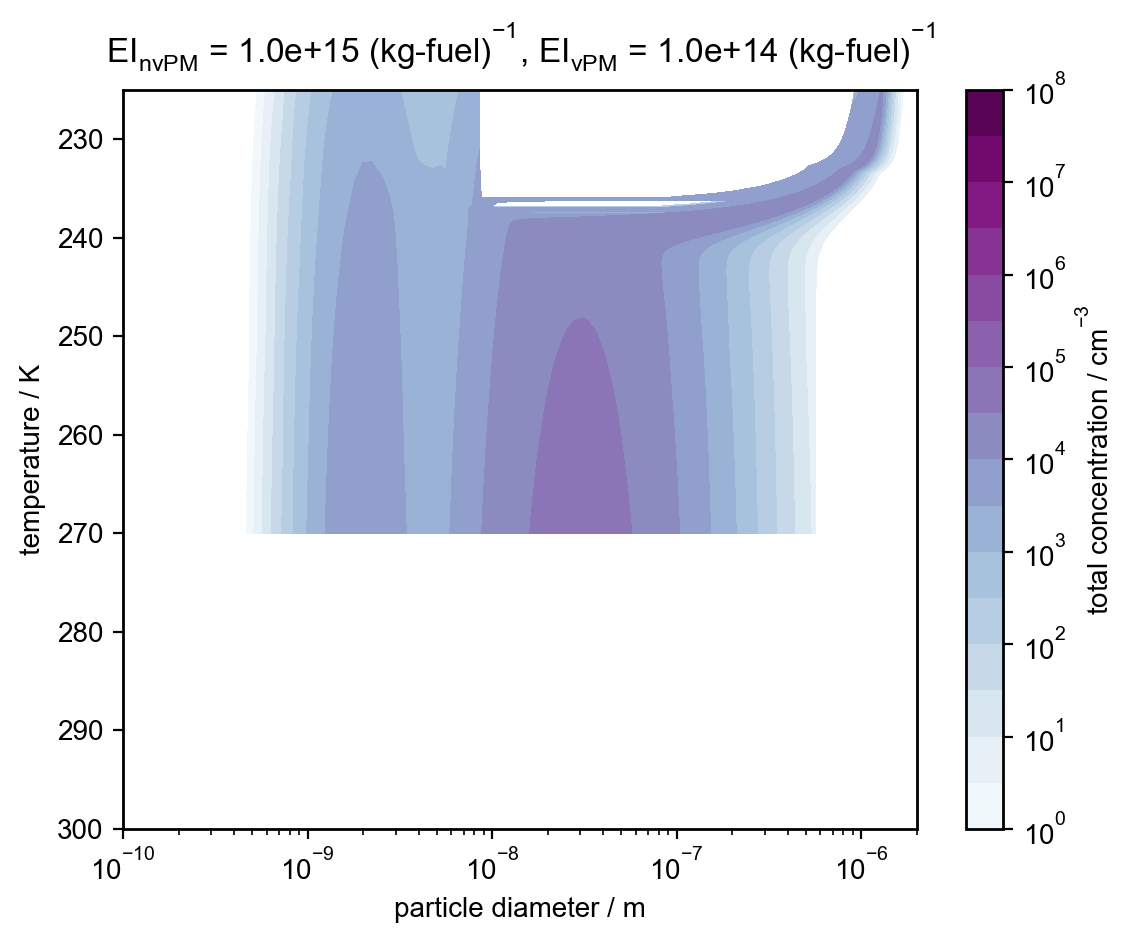

In [99]:
# conc - multiple modes together

# multiple modes individually

# Apply the custom formatter to the colorbar

interpolation_r = np.logspace(-12, -5, 10000)

from scipy import interpolate

N_total_list = []
V_total_list = []

for index, array in enumerate(nvPM_array):

    x_nvPM = nvPM_array[index]
    y_nvPM = nvPM_Ni_diluted[index]

    y_new_nvPM = interpolating_with_break_point(x_nvPM, y_nvPM, 4e-8, interpolation_r)

    x_vPM = vPM_array[index]
    y_vPM = vPM_Ni_diluted[index]

    y_new_vPM = interpolating_with_break_point(x_vPM, y_vPM, 4e-8, interpolation_r)

    N_total = y_new_nvPM + y_new_vPM
    N_total_list.append(N_total)

N_total_array = np.array(N_total_list)

# plotting

from matplotlib import ticker, cm
from matplotlib.colors import Normalize

new_x = interpolation_r
new_y = T_array

new_z = np.log10(N_total_array/1e6) # see conversion explanation above
# plotting

contour = plt.contourf(new_x * 2, new_y, new_z, levels = np.arange(0, 8.5, 0.5),   cmap = "BuPu", alpha = 1)

# middling_contour = plt.contour(new_x * 2, new_y, (10 ** new_z1)/(10 ** new_z2), levels = np.array([1]), colors='black', linewidths = 1, font = "arial", alpha = 0.5)
# label = plt.clabel(middling_contour, fmt = '%.2f', colors = 'black', inline = True, fontsize=8, inline_spacing = 0)
# for l in label:
#     l.set_rotation(0)

plt.axhline(y = 0, color = "black", linewidth = 1, alpha = 0.1)
plt.axhline(y = 100 * np.max(parcel_trace['S']), color = "black", linewidth = 1, alpha = 0.5)

cbar = plt.colorbar(contour)

cbar.set_label(f"total concentration / cm$^{{-3}}$")
cbar.set_ticks(np.arange(0, 8.5, 1))
cbar.set_ticklabels(np.array([f"10$^{{0}}$", f"10$^{{1}}$", f"10$^{{2}}$",f"10$^{{3}}$",f"10$^{{4}}$",f"10$^{{5}}$",f"10$^{{6}}$",f"10$^{{7}}$",f"10$^{{8}}$"]))

plt.xscale("log")

plt.xlim([1e-10, 2e-6])
plt.ylim([300, 225])
plt.xlabel("particle diameter / m")
plt.ylabel("temperature / K")

plt.title(f"EI$_{{nvPM}}$ = {EI_nvPM:.1e} (kg-fuel)$^{{-1}}$, EI$_{{vPM}}$ = {EI_vPM:.1e} (kg-fuel)$^{{-1}}$", pad = 10)
plt.savefig(f"/Users/jrp21/Desktop/conc_modes_together_{EI_nvPM:.1e}_vPM_{EI_vPM:.1e}-test.png", dpi = 500)
plt.show()

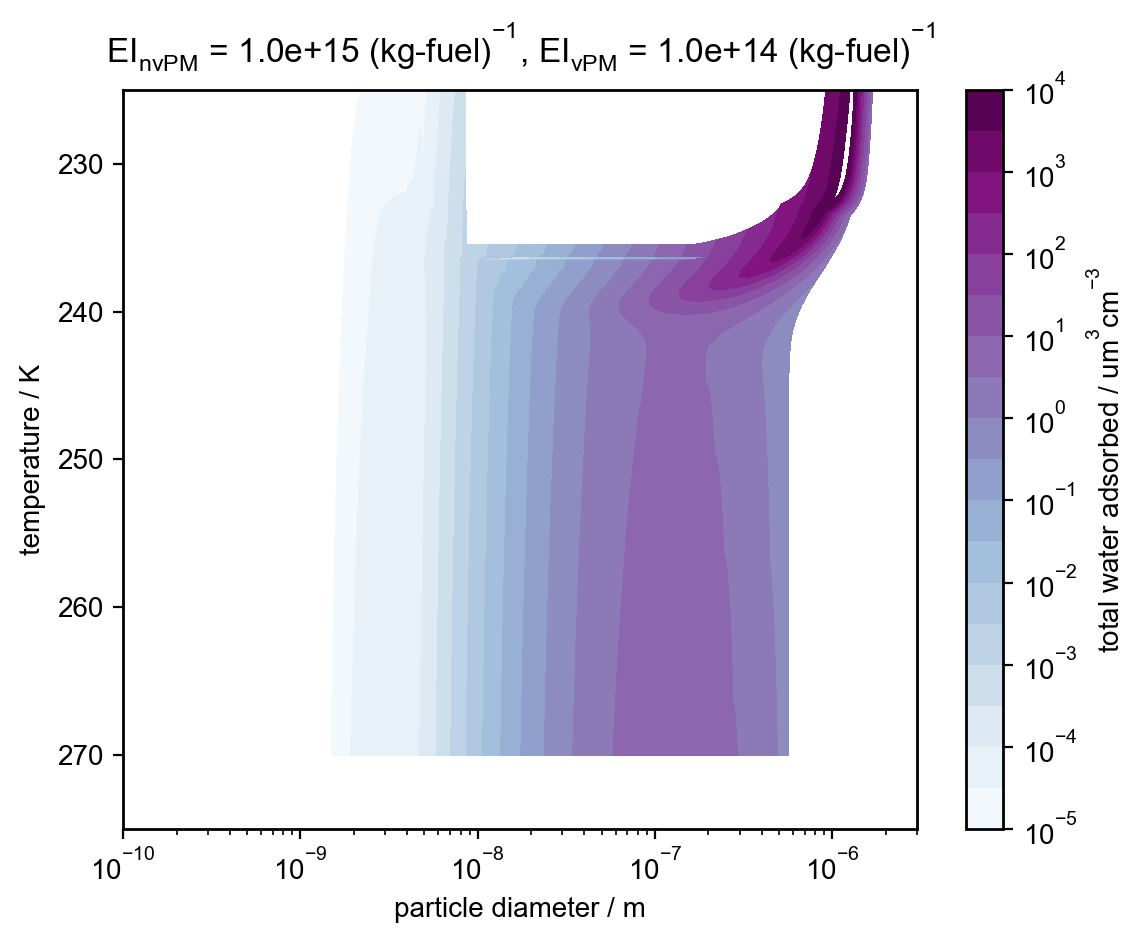

In [100]:
# volume - multiple modes together

# multiple modes individually

# Apply the custom formatter to the colorbar

interpolation_r = np.logspace(-12, -4, 10000)

from scipy import interpolate

N_total_list = []
V_total_list = []

for index, array in enumerate(nvPM_array):

    x_nvPM = nvPM_array[index]
    y_nvPM = nvPM_Ni_diluted[index]

    y_new_nvPM = interpolating_with_break_point(x_nvPM, y_nvPM, 8e-8, interpolation_r)
    V_nvPM = y_new_nvPM * 4/3 * np.pi * interpolation_r ** 3 

    x_vPM = vPM_array[index]
    y_vPM = vPM_Ni_diluted[index]

    y_new_vPM = interpolating_with_break_point(x_vPM, y_vPM, 8e-8, interpolation_r)
    V_vPM = y_new_vPM * 4/3 * np.pi * interpolation_r ** 3 

    V_total_list.append(V_vPM + V_nvPM)

    # if index == 800:
    #     print(T_array[index])

    #     plt.scatter(interpolation_r, V_nvPM, color = "red", s = 10)
    #     plt.scatter(interpolation_r, V_vPM, color = "blue", s = 10)
    #     plt.plot(interpolation_r, V_total_list[800])
    #     plt.xscale("log")
    #     plt.yscale("log")

    #     plt.xlim([1e-7, 1e-6])

V_total_array = np.array(V_total_list) 

from matplotlib import ticker, cm
from matplotlib.colors import Normalize

new_x = interpolation_r
new_y = T_array
new_z = np.log10(V_total_array * 1e12) # conversion between m^3/m^3 and um^3/cm^3

# plotting

contour = plt.contourf(new_x * 2, new_y, new_z, levels = np.arange(-5, 4.5, 0.5),   cmap = "BuPu", alpha = 1)

# middling_contour = plt.contour(new_x * 2, new_y, (10 ** new_z1)/(10 ** new_z2), levels = np.array([1]), colors='black', linewidths = 1, font = "arial", alpha = 0.5)
# label = plt.clabel(middling_contour, fmt = '%.2f', colors = 'black', inline = True, fontsize=8, inline_spacing = 0)
# for l in label:
#     l.set_rotation(0)

plt.axhline(y = 0, color = "black", linewidth = 1, alpha = 0.1)
plt.axhline(y = 100 * np.max(parcel_trace['S']), color = "black", linewidth = 1, alpha = 0.5)

plt.xlim([1e-10, 3e-6])
plt.ylim([275, 225])

plt.xscale("log")

cbar = plt.colorbar(contour)

cbar.set_label(f"total water adsorbed / um$^{{3}}cm^{{-3}}$")
cbar.set_ticks(np.arange(-5, 4.5, 1))
cbar.set_ticklabels(np.array([f"10$^{{-5}}$", f"10$^{{-4}}$", f"10$^{{-3}}$",f"10$^{{-2}}$",f"10$^{{-1}}$",f"10$^{0}$",f"10$^{1}$",f"10$^{2}$",f"10$^{3}$", f"10$^{4}$"]))

plt.xlabel("particle diameter / m")
plt.ylabel("temperature / K")

plt.title(f"EI$_{{nvPM}}$ = {EI_nvPM:.1e} (kg-fuel)$^{{-1}}$, EI$_{{vPM}}$ = {EI_vPM:.1e} (kg-fuel)$^{{-1}}$", pad = 10)
plt.savefig(f"/Users/jrp21/Desktop/volume_modes_together_{EI_nvPM:.1e}_vPM_{EI_vPM:.1e}_test.png", dpi = 500)
plt.show()

In [45]:
# looking at volume derivative over time (J/Y)

# plotting

from matplotlib import ticker, cm
from matplotlib.colors import Normalize

dV_dt = np.gradient(V_total_array)[0]/0.001

new_x = interpolation_r
new_y = T_array
new_z = dV_dt

new_z = new_z[new_z > 0]
new_z = np.log10(dV_dt)

# new_z_plus = new_z[new_z > 0]
# new_z_minus = new_z[new_z < 0]

# new_z_plus = new_z[new_z > 0]
# new_z_minus = new_z[new_z < 0]

# min_x = 5e-10
# max_x = 1e-6

# min_x_index = np.argmin(np.abs(interpolation_r - min_x))
# max_x_index = np.argmin(np.abs(interpolation_r - max_x))

# new_x = new_x[min_x_index:max_x_index+1]
# new_z = new_z[:, min_x_index:max_x_index+1]

# plotting

# contour_plus = plt.contourf(new_x * 2, new_y, new_z, levels = np.arange(-100, 10, 1),   cmap = "cividis_r", alpha = 1)
contour = plt.contourf(new_x * 2, new_y, new_z, levels = np.arange(-4, 5.5, 1),   cmap = "cividis_r", alpha = 1, extend='min')


plt.axhline(y = 0, color = "black", linewidth = 1, alpha = 0.1)
plt.axhline(y = 100 * np.max(parcel_trace['S']), color = "black", linewidth = 1, alpha = 0.5)

cbar = plt.colorbar(contour)

cbar.set_label(f"log$_{{10}}$(dV/dt / um$^{{3}}$$s^{{-1}}$)")
# cbar.set_label(f"V$_{{water}}$ / um$^{{3}}$")

# cbar.set_ticks(np.arange(-5, 3.5, 1))
# cbar.set_ticklabels(10 ** np.arange(-4, 3.5, 1))
# cbar.set_ticklabels(np.array([f"10$^{{-5}}$", f"10$^{{-4}}$", f"10$^{{-3}}$",f"10$^{{-2}}$",f"10$^{{-1}}$",f"10$^{0}$",f"10$^{1}$",f"10$^{2}$",f"10$^{3}$"]))

plt.xscale("log")

plt.xlim([1e-9, 5e-7])
# plt.ylim([-120, 50])
plt.ylim([280, 220])

plt.xlabel("particle diameter / m")
plt.ylabel("water supersaturation / %")

plt.title(f"EI$_{{nvPM}}$ = {EI_nvPM:.1e} (kg-fuel)$^{{-1}}$, EI$_{{vPM}}$ = {EI_vPM:.1e} (kg-fuel)$^{{-1}}$", pad = 10)
plt.savefig(f"/Users/jrp21/Desktop/dV_dt_nvPM_{EI_nvPM:.1e}_vPM_{EI_vPM:.1e}_test.png", dpi = 500)

NameError: name 'V_total_array' is not defined

1400


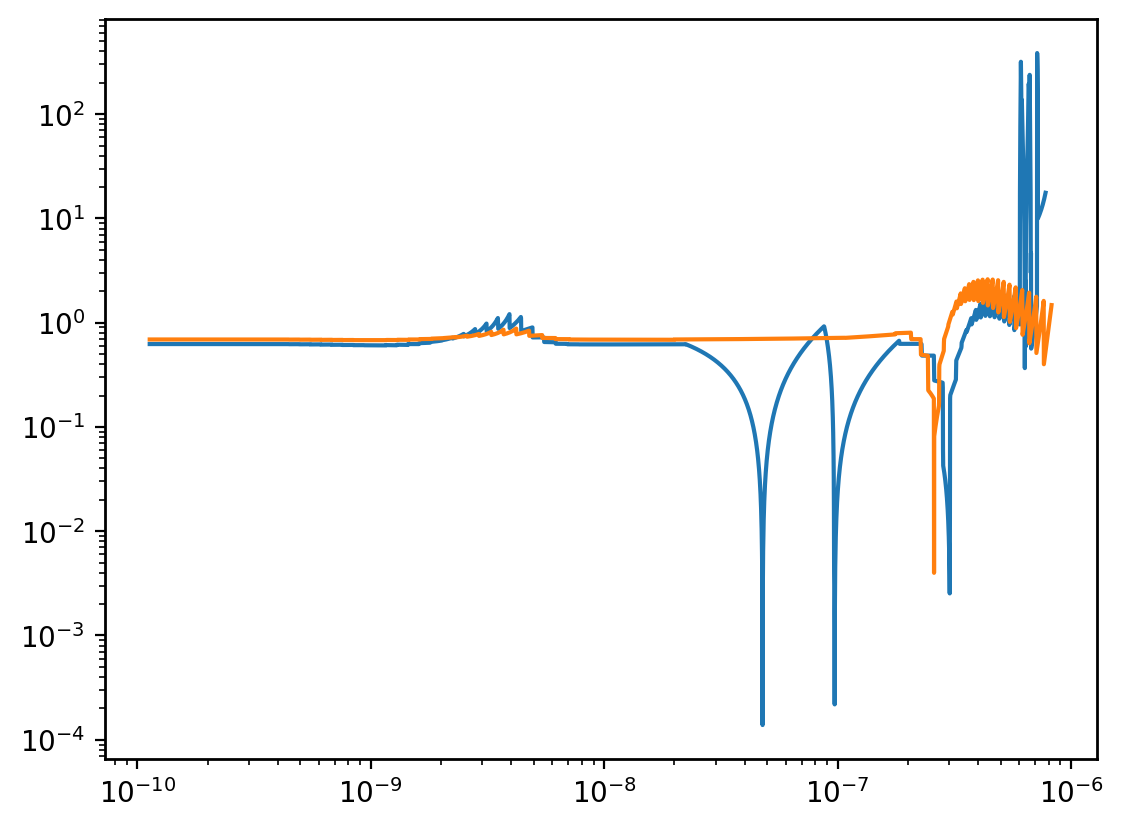

In [65]:
# looking at radial/volume growth - size distribution over time (8/Y)

x = np.tile(interpolation_r, (200, 1))
y = np.log10(V_total_array)
dV_dt = np.gradient(y)[0]/0.001

index_229 = np.argmin(np.abs(T_array - 229))
index_231 = np.argmin(np.abs(T_array - 231))



from matplotlib.cm import ScalarMappable

# Number of data sets
num_data_sets = np.shape(dV_dt)[0]

print(num_data_sets)

# Creating a ScalarMappable object to map scalar data to colors using a colormap
# norm = Normalize(vmin=0, vmax=num_data_sets - 1)
# cmap = plt.get_cmap('jet')
# sm = ScalarMappable(norm=norm, cmap="jet")

# # Plotting each pair of x and y with a darker shade of red according to the colormap
# for i in range(num_data_sets):

#     color = sm.to_rgba(i)

#     # plt.plot(x1[i], y1[i], color=color, label=f'data {i+1}')
#     # plt.plot(x2[i], y2[i], color=color, label=f'data {i+1}')
#     plt.plot(2 * interpolation_r, dV_dt[i], color=color, label=f'data {i+1}')

plt.plot(2 * interpolation_r, np.abs(dV_dt[index_229]))
plt.plot(2 * interpolation_r, np.abs(dV_dt[index_231]))


plt.xscale("log")
plt.yscale("log")

# plt.ylim([-250, 250])
plt.savefig(f"/Users/jrp21/Desktop/Test.png", dpi = 500)
plt.show()


In [ ]:
# looking at the homogeneous freezing temperature (1/Y)

"""HOMOGENEOUS FREEZING PARAMETRIZATION FROM BIER 2021"""

def T_hom_Bier(cooling_rate_per_sec, radius):
    
    a1 = -3.574 # K^-1 
    a2 = 858.72
    
    return 1/a1 * (np.log((3e-6 * a1 * cooling_rate_per_sec) / (4 * np.pi * radius ** 3)) - a2)
    
# need to vectorize T_hom_Bier for various T and cooling rate

x = np.gradient(T)/dt
y = interpolation_r

X, Y = np.meshgrid(x, y)

f_vectorized = np.vectorize(T_hom_Bier)
z = f_vectorized(X, Y)

In [28]:
# Unpacking the quenching effect - looking at vPM alone, nvPM alone and vPM and nvPM (1/Z)

# Define contrail properties

T_a = 215.0 # ambient temperature / K
T_e = 600.0 # exhaust temperature
P0 = 22919.5 # (cruise) pressure, Pa 

# Define particle properties

GMD_ambient, GSD_ambient, kappa_ambient = 30e-9, 1.6, 0.500001 # must specify the ambient mode with this kappa value otherwise the code will fail
GMD_nvPM, GSD_nvPM, kappa_nvPM = 30e-9, 2.0, 0.005
GMD_vPM, GSD_vPM, kappa_vPM = 2e-9, 1.4, 0.5
bins_nvPM, bins_ambient, bins_vPM = 50, 50, 100

# Define model properties

T_start = 300.0 # initial model (not the ambient temperature) temperature / K
dt = 0.001 # timestep / s
t_end = 2 # end time / s

In [29]:
# Unpacking the quenching effect - looking at vPM alone, nvPM alone and vPM and nvPM (2/Z)

n_ambient = 0 # number concentration of ambient particles / cm^-3
EI_nvPM = 1e15 # emission index of nvPM particles, particles per kg of fuel burned (when present
EI_vPM = 1e17 # emission index of vPM particles, particles per kg of fuel burned (when present)

# defining the particle and aerosol traces

parcel_trace_NN, aerosol_traces_NN = n_droplets(T_a, T_e, P0, 
               n_ambient, GMD_ambient, GSD_ambient, kappa_ambient, bins_ambient, 
               0, GMD_vPM, GSD_vPM, kappa_vPM, bins_vPM,
               0, GMD_nvPM, GSD_nvPM, kappa_nvPM, bins_nvPM,
               T_start, dt, t_end)

parcel_trace_NY, aerosol_traces_NY = n_droplets(T_a, T_e, P0, 
               n_ambient, GMD_ambient, GSD_ambient, kappa_ambient, bins_ambient, 
               0, GMD_vPM, GSD_vPM, kappa_vPM, bins_vPM,
               EI_nvPM, GMD_nvPM, GSD_nvPM, kappa_nvPM, bins_nvPM,
               T_start, dt, t_end)

parcel_trace_YN, aerosol_traces_YN = n_droplets(T_a, T_e, P0, 
               n_ambient, GMD_ambient, GSD_ambient, kappa_ambient, bins_ambient, 
               EI_vPM, GMD_vPM, GSD_vPM, kappa_vPM, bins_vPM,
               0, GMD_nvPM, GSD_nvPM, kappa_nvPM, bins_nvPM,
               T_start, dt, t_end)

parcel_trace_YY, aerosol_traces_YY = n_droplets(T_a, T_e, P0, 
               n_ambient, GMD_ambient, GSD_ambient, kappa_ambient, bins_ambient, 
               EI_vPM, GMD_vPM, GSD_vPM, kappa_vPM, bins_vPM,
               EI_nvPM, GMD_nvPM, GSD_nvPM, kappa_nvPM, bins_nvPM,
               T_start, dt, t_end)

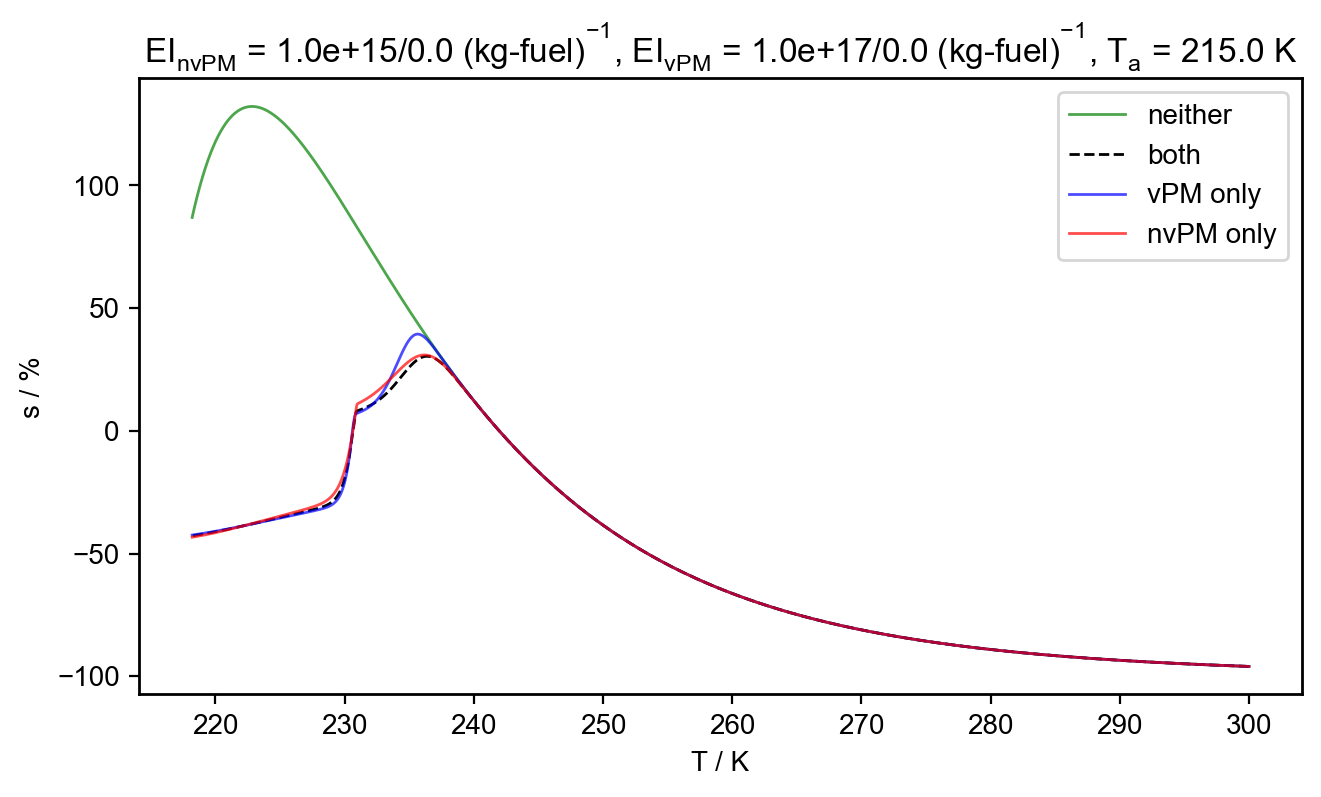

In [32]:
# Unpacking the quenching effect - looking at vPM alone, nvPM alone and vPM and nvPM (3/Z)

%matplotlib inline
%config InlineBackend.figure_format='retina'

plt.rcParams['mathtext.default'] = 'regular'
plt.rcParams["font.family"] = "Arial"
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['axes.formatter.useoffset'] = False
plt.rcParams["font.size"] = 10

fig = plt.figure(figsize = (7.5, 4))

ax = fig.add_subplot(1, 1, 1)

ax.plot(parcel_trace_NN['T'], 100 * (parcel_trace_NN['S']), linewidth = 1, color = "green", label = "neither", alpha = 0.7)
ax.plot(parcel_trace_YY['T'], 100 * (parcel_trace_YY['S']), linewidth = 1, linestyle = "--", color = "black", label = "both")
ax.plot(parcel_trace_YN['T'], 100 * (parcel_trace_YN['S']), linewidth = 1, color = "blue", label = "vPM only", alpha = 0.7)
ax.plot(parcel_trace_NY['T'], 100 * (parcel_trace_NY['S']), linewidth = 1, color = "red", label = "nvPM only", alpha = 0.7)

# ax.plot(parcel_trace_NY['T'], 100 * np.sqrt((parcel_trace_NY['S'] + 1) * (parcel_trace_YN['S'] + 1)), linewidth = 1, color = "black", linestyle = "--", label = "geometric mean", alpha = 0.2)
# ax.plot(parcel_trace_NY['T'], 100 * ((1/(parcel_trace_NY['S'] + 1) + 1/(parcel_trace_YN['S'] + 1))/2) ** (-1), linewidth = 1, color = "black", linestyle = ":", label = "harmonic mean", alpha = 0.2)
# ax.plot(parcel_trace_NY['T'], 100/2 * ((parcel_trace_NY['S'] + 1) + (parcel_trace_YN['S'] + 1)), linewidth = 1, color = "black", linestyle = "dashdot", label = "arithmetic mean", alpha = 0.2)
# ax.plot(parcel_trace_NY['T'], 100 * np.sqrt(((parcel_trace_NY['S'] + 1) ** 2 + (parcel_trace_YN['S'] + 1) ** 2)/2), linewidth = 1, color = "black", linestyle = "-", label = "quadratic mean", alpha = 0.2)

plt.legend()

ax.set_ylabel("s / %")
ax.set_xlabel("T / K")

plt.title(f"EI$_{{nvPM}}$ = {EI_nvPM:.1e}/0.0 (kg-fuel)$^{{-1}}$, EI$_{{vPM}}$ = {EI_vPM:.1e}/0.0 (kg-fuel)$^{{-1}}$, T$_{{a}}$ = {T_a:.1f} K")
plt.savefig(f"/Users/jrp21/Desktop/quenching_test_nvPM_{EI_nvPM:.1e}_vPM_{EI_vPM:.1e}_Ta_{T_a:.1f}.png", dpi = 500)

plt.show()

In [ ]:
# Unpacking the quenching effect - looking at vPM alone, nvPM alone and vPM and nvPM (4/Z)

# determining number concentration of each species at the peak supersaturation in the plume

from pyrcel import binned_activation

a_trace = aerosol_traces_YY
p_trace = parcel_trace_YY

ambient_trace = a_trace['ambient']
nvPM_trace = a_trace['nvPM']
vPM_trace = a_trace['vPM']

N0_nvPM = (EI_nvPM * (P0 * 28.96e-3) / (8.3145 * T_e)) / 60 / 1e6 # initial number concentration of soot particles, particles per cm^3
N0_vPM = (EI_vPM * (P0 * 28.96e-3) / (8.3145 * T_e)) / 60 / 1e6 # initial number concentration of soot particles, particles per cm^3

ambient =  pm.AerosolSpecies('ambient',
                            pm.Lognorm(mu=GMD_ambient * 0.5e6, sigma=GSD_ambient, N=n_ambient),
                            kappa=kappa_ambient, bins=int(bins_ambient))
                            
vPM =  pm.AerosolSpecies('ambient',
                            pm.Lognorm(mu=GMD_vPM * 0.5e6, sigma=GSD_vPM, N=N0_vPM),
                            kappa=kappa_vPM, bins=int(bins_vPM))

nvPM =  pm.AerosolSpecies('ambient',
                            pm.Lognorm(mu=GMD_nvPM * 0.5e6, sigma=GSD_nvPM, N=N0_nvPM),
                            kappa=kappa_nvPM, bins=int(bins_nvPM))   

n_act_ambient_list = []
n_act_nvPM_list = []
n_act_vPM_list = []

T_list = []
S_list = []

idxmin = np.argmin(np.abs(p_trace['T']-260))
idxmax = np.argmax(p_trace['S'])

print(100 * (p_trace['S'].iloc[184] + 1))

n_act_ambient = binned_activation(p_trace['S'].iloc[idxmax], p_trace['T'].iloc[idxmax], ambient_trace.iloc[idxmax],  ambient, T_a) # activated fractions at maximum supersaturation
n_act_nvPM = binned_activation(p_trace['S'].iloc[idxmax], p_trace['T'].iloc[idxmax], nvPM_trace.iloc[idxmax],  nvPM, T_a) # activated fractions at maximum supersaturation
n_act_vPM = binned_activation(p_trace['S'].iloc[idxmax], p_trace['T'].iloc[idxmax], vPM_trace.iloc[idxmax], vPM, T_a) # activated fractions at maximum supersaturation

print(f"{n_act_ambient:.2e}, nvPM: {n_act_nvPM/1e6:.2e}, vPM: {n_act_vPM/1e6:.2e}")

131.29698671547


ValueError: operands could not be broadcast together with shapes (50,) (30,) 

In [ ]:
# Checking dilution parametrization (1/3)

# Define contrail properties

T_a = 215.0 # ambient temperature / K
T_e = 600 # exhaust temperature
P0 = 22919.5 # (cruise) pressure, Pa 

# Define particle properties

n_ambient = 0 # number concentration of ambient particles / cm^-3
EI_nvPM = 1e15 # emission index of nvPM particles, particles per kg of fuel burned
EI_vPM = 1e17 # emission index of vPM particles, particles per kg of fuel burned

GMD_ambient, GSD_ambient, kappa_ambient = 30e-9, 1.6, 0.500001 # must specify the ambient mode with this kappa value otherwise the code will fail
GMD_nvPM, GSD_nvPM, kappa_nvPM = 30e-9, 2.0, 0.005
GMD_vPM, GSD_vPM, kappa_vPM = 2e-9, 1.4, 0.5
bins_nvPM, bins_ambient, bins_vPM = 30, 30, 100

# Define model properties

T_start = 260 # initial model (not the ambient temperature) temperature / K
dt = 0.001 # timestep / s
t_end = 0.5 # end time / s

# Call the model (returns maximum supersaturation as % and effective emission index of ice as particles per kg-fuel)

parcel_trace, aerosol_traces = n_droplets(T_a, T_e, P0, 
               n_ambient, GMD_ambient, GSD_ambient, kappa_ambient, bins_ambient, 
               EI_vPM, GMD_vPM, GSD_vPM, kappa_vPM, bins_vPM,
               EI_nvPM, GMD_nvPM, GSD_nvPM, kappa_nvPM, bins_nvPM,
               T_start, dt, t_end)

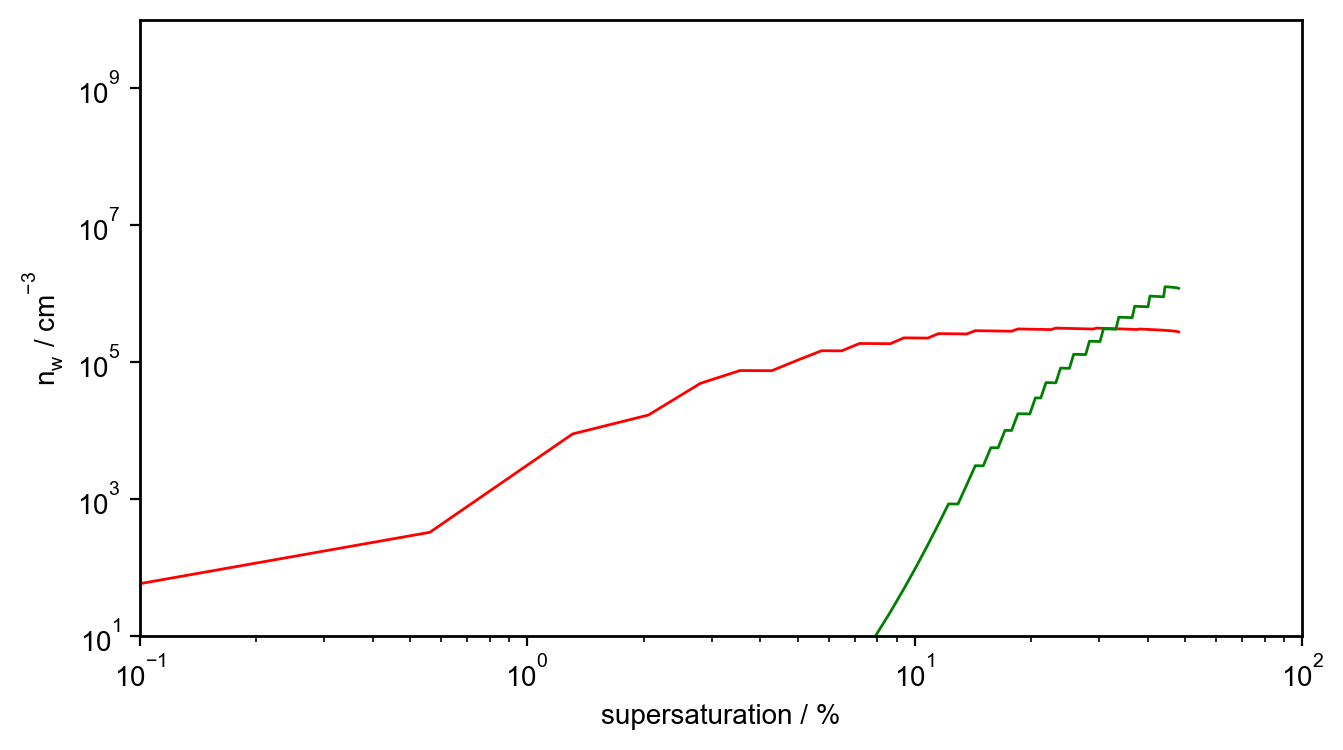

In [ ]:
# Checking dilution parametrization (2/3)

from pyrcel import binned_activation

ambient_trace = aerosol_traces['ambient']
nvPM_trace = aerosol_traces['nvPM']
vPM_trace = aerosol_traces['vPM']

N0_nvPM = (EI_nvPM * (P0 * 28.96e-3) / (8.3145 * T_e)) / 60 / 1e6 # initial number concentration of soot particles, particles per cm^3
N0_vPM = (EI_vPM * (P0 * 28.96e-3) / (8.3145 * T_e)) / 60 / 1e6 # initial number concentration of soot particles, particles per cm^3

ambient =  pm.AerosolSpecies('ambient',
                            pm.Lognorm(mu=GMD_ambient * 0.5e6, sigma=GSD_ambient, N=n_ambient),
                            kappa=kappa_ambient, bins=int(bins_ambient))
                            
vPM =  pm.AerosolSpecies('ambient',
                            pm.Lognorm(mu=GMD_vPM * 0.5e6, sigma=GSD_vPM, N=N0_vPM),
                            kappa=kappa_vPM, bins=int(bins_vPM))

nvPM =  pm.AerosolSpecies('ambient',
                            pm.Lognorm(mu=GMD_nvPM * 0.5e6, sigma=GSD_nvPM, N=N0_nvPM),
                            kappa=kappa_nvPM, bins=int(bins_nvPM))   

n_act_ambient_list = []
n_act_nvPM_list = []
n_act_vPM_list = []

T_list = []
S_list = []

idxmin = np.argmin(np.abs(parcel_trace['T']-260))
idxmax = np.argmax(parcel_trace['S'])

indices = np.arange(idxmin, idxmax, 1)

for i in indices:

    n_act_ambient = binned_activation(parcel_trace['S'].iloc[i], parcel_trace['T'].iloc[i], ambient_trace.iloc[i],  ambient, T_a) # activated fractions at maximum supersaturation
    n_act_nvPM = binned_activation(parcel_trace['S'].iloc[i], parcel_trace['T'].iloc[i], nvPM_trace.iloc[i],  nvPM, T_a) # activated fractions at maximum supersaturation
    n_act_vPM = binned_activation(parcel_trace['S'].iloc[i], parcel_trace['T'].iloc[i], vPM_trace.iloc[i],  vPM, T_a) # activated fractions at maximum supersaturation

    n_act_ambient_list.append(n_act_ambient/1e6)
    n_act_nvPM_list.append(n_act_nvPM/1e6)
    n_act_vPM_list.append(n_act_vPM/1e6)
    
    T_list.append(parcel_trace['T'].iloc[i])
    S_list.append(parcel_trace['S'].iloc[i])

# set limits

n_act_ambient_array = np.array(n_act_ambient_list)
n_act_nvPM_array = np.array(n_act_nvPM_list)
n_act_vPM_array = np.array(n_act_vPM_list)

S_array = np.array(S_list)

# plotting

%matplotlib inline
%config InlineBackend.figure_format='retina'

plt.rcParams['mathtext.default'] = 'regular'
plt.rcParams["font.family"] = "Arial"
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['axes.formatter.useoffset'] = False
plt.rcParams["font.size"] = 10

fig = plt.figure(figsize = (7.5, 4))

ax = fig.add_subplot(1, 1, 1)

ax.plot(100 * S_array, n_act_ambient_array, color = "grey", linewidth = 1)
ax.plot(100 * S_array, n_act_nvPM_array, color = "red", linewidth = 1)
ax.plot(100 * S_array, n_act_vPM_array, color = "green", linewidth = 1)

ax.set_xlim([1e-1, 100])
ax.set_ylim([1e1, 1e10])

ax.set_ylabel("n$_{w}$" + " / cm$^{-3}$")
ax.set_xlabel("supersaturation / %")

ax.set_xscale("log")
ax.set_yscale("log")

plt.savefig("/Users/jrp21/Desktop/Test_2.png", dpi = 500)

plt.show()

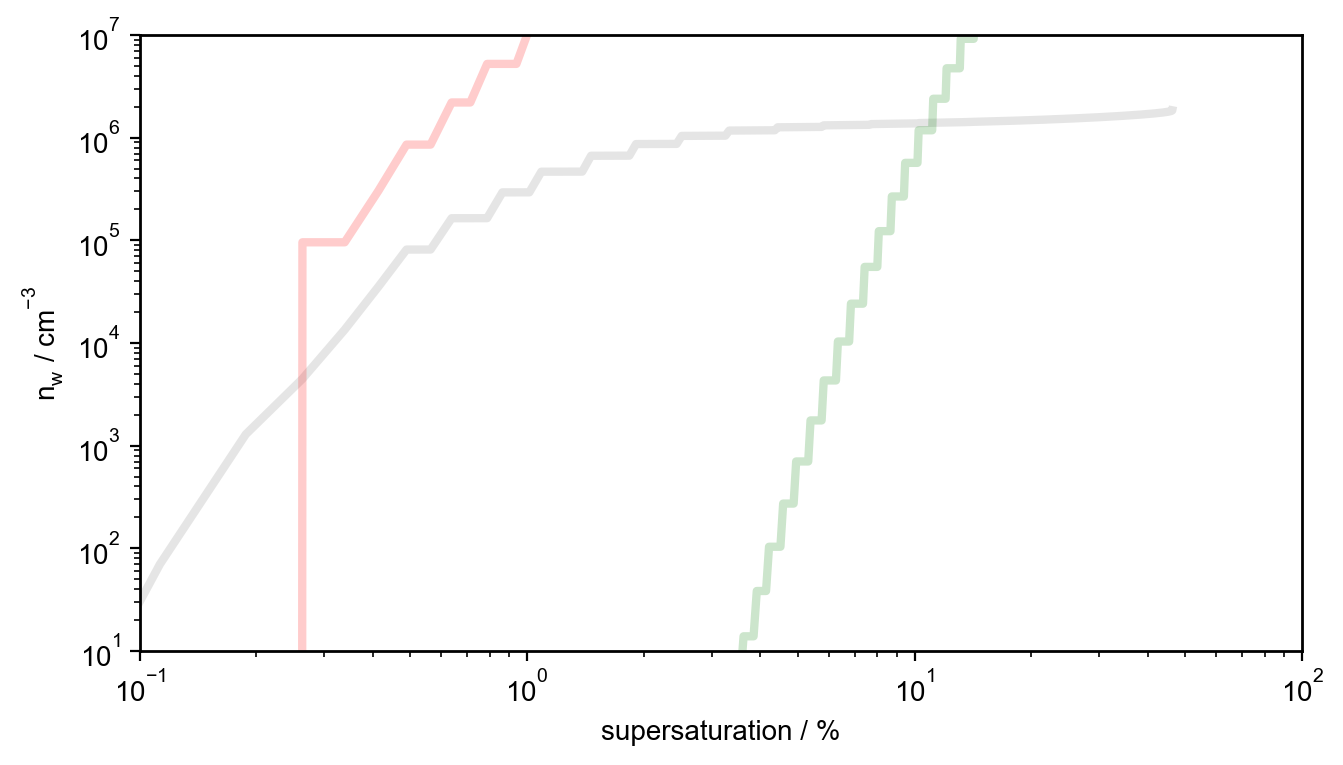

In [ ]:
# Checking dilution parametrization (3/3)

# Plotting

%matplotlib inline
%config InlineBackend.figure_format='retina'

plt.rcParams['mathtext.default'] = 'regular'
plt.rcParams["font.family"] = "Arial"
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['axes.formatter.useoffset'] = False
plt.rcParams["font.size"] = 10

fig = plt.figure(figsize = (7.5, 4))

ax = fig.add_subplot(1, 1, 1)

ax.plot(100 * S_array, n_act_ambient_array, color = "grey", linewidth = 3, alpha = 0.2)
ax.plot(100 * S_array, n_act_nvPM_array, color = "red", linewidth = 3, alpha = 0.2)
ax.plot(100 * S_array, n_act_vPM_array, color = "green", linewidth = 3, alpha = 0.2)

# importing Kärcher model

import pandas as pd

# df = pd.read_csv("/Users/jrp21/Desktop/data.csv")

# ax.plot(df["supersaturation"] * 100, df["ambient"], color = "grey", linewidth = 1, linestyle = "-", alpha = 1)
# ax.plot(df["supersaturation"] * 100, df["nvPM"], color = "red", linewidth = 1, linestyle = "-", alpha = 1)
# ax.plot(df["supersaturation"] * 100, df["vPM"], color = "green", linewidth = 1, linestyle = "-", alpha = 1)

# ax.axvline(x = df["supersaturation"].iloc[-1] * 100, color = "grey", linewidth = 1, linestyle = "-", alpha = 1)
# ax.axvline(x = 100 * S_array[-1], color = "grey", linewidth = 1, linestyle = "-", alpha = 1)


ax.set_xlim([1e-1, 100])
ax.set_ylim([1e1, 1e7])

ax.set_ylabel("n$_{w}$" + " / cm$^{-3}$")
ax.set_xlabel("supersaturation / %")

ax.set_xscale("log")
ax.set_yscale("log")

plt.savefig("/Users/jrp21/Desktop/Test_2.png", dpi = 500)

plt.show()


In [30]:
# looking at positive versus negative supersaturation forcing (1/X)

# Define contrail properties

T_a = 215.0 # ambient temperature / K
T_e = 600 # exhaust temperature
P0 = 22919.5 # (cruise) pressure, Pa 

# Define particle properties

n_ambient = 600 # number concentration of ambient particles / cm^-3
EI_nvPM = 1e15 # emission index of nvPM particles, particles per kg of fuel burned
EI_vPM = 2e17 # emission index of vPM particles, particles per kg of fuel burned

GMD_ambient, GSD_ambient, kappa_ambient = 30e-9, 1.6, 0.500001 # must specify the ambient mode with this kappa value otherwise the code will fail
GMD_nvPM, GSD_nvPM, kappa_nvPM = 30e-9, 2.0, 0.005
GMD_vPM, GSD_vPM, kappa_vPM = 2e-9, 1.4, 0.5
bins_nvPM, bins_ambient, bins_vPM = 30, 30, 20

# Define model properties

T_start = 600 # initial model (not the ambient temperature) temperature / K
dt = 0.0005 # timestep / s
t_end = 2 # end time / s

# Call the model (returns maximum supersaturation as % and effective emission index of ice as particles per kg-fuel)

# parcel_trace, aerosol_traces = n_droplets(T_a, T_e, P0, 
#                n_ambient, GMD_ambient, GSD_ambient, kappa_ambient, bins_ambient, 
#                EI_vPM, GMD_vPM, GSD_vPM, kappa_vPM, bins_vPM,
#                EI_nvPM, GMD_nvPM, GSD_nvPM, kappa_nvPM, bins_nvPM,
#                T_start, dt, t_end)

In [31]:
# exploring vPM sensitivity (1/2)
 
import matplotlib.pyplot as plt
import matplotlib.colors
import matplotlib as mpl

# Define contrail properties

T_a = 215.0 # ambient temperature / K
T_e = 600 # exhaust temperature
P0 = 22919.5 # (cruise) pressure, Pa 

# Define particle properties

n_ambient = 600 # number concentration of ambient particles / cm^-3
EI_nvPM = 1e15 # emission index of nvPM particles, particles per kg of fuel burned
EI_vPM = 2e17 # emission index of vPM particles, particles per kg of fuel burned

GMD_ambient, GSD_ambient, kappa_ambient = 30e-9, 1.6, 0.500001 # must specify the ambient mode with this kappa value (0.500001) otherwise the code will fail
GMD_nvPM, GSD_nvPM, kappa_nvPM = 25e-9, 2.0, 0.005
GMD_vPM, GSD_vPM, kappa_vPM = 2e-9, 1.4, 0.005

bins_nvPM, bins_ambient, bins_vPM = 30, 30, 30

# Define model properties

T_start = 270 # initial model (not the ambient temperature) temperature / K
dt = 0.0005 # timestep / s
t_end = 0.5 # end time / s

# Dependent variables

kappa_vPM_array = np.logspace(-3, 0, 2)
GMD_vPM_array = np.linspace(2.5e-9, 5e-9, 2)

x, y = np.meshgrid(kappa_vPM_array, GMD_vPM_array)

f_vectorized = np.vectorize(n_droplets)
z = f_vectorized(T_a, T_e, P0, 
               n_ambient, GMD_ambient, GSD_ambient, kappa_ambient, bins_ambient, 
               EI_vPM, y, GSD_vPM, x, bins_vPM,
               EI_nvPM, GMD_nvPM, GSD_nvPM, kappa_nvPM, bins_nvPM,
               T_start, dt, t_end)

fig = plt.figure(figsize = (5, 4))
ax = fig.add_subplot(1, 1, 1)

import matplotlib.colors as mcolors
from matplotlib.ticker import ScalarFormatter

contour = plt.contourf(x, y/1e-9, z, cmap = "jet")
fig.colorbar(contour, ax = ax, label = 'EIi/Ei_nvPM')

ax.set_xlabel('vPM kappa / no units')
ax.set_ylabel('vPM GMD / nm')

# ax.set_xlim([])
# ax.set_ylim([1, 10])

ax.set_xscale("log")
# ax.set_yscale("log")

# ax.set_xticks([1e2, 1e4, 1e6, 1e8, 1e10, 1e12, 1e14, 1e16])
# ax.set_yticks([1, 10, 100])

plt.subplots_adjust(left = 0.1, right = 0.94, bottom = 0.17, top = 0.94, wspace = 0.27, hspace = 0.2)
plt.savefig(f"/Users/jrp21/Desktop/test_13.png", dpi = 300)

plt.show()

ParcelModelError: 'Something failed during model integration.'

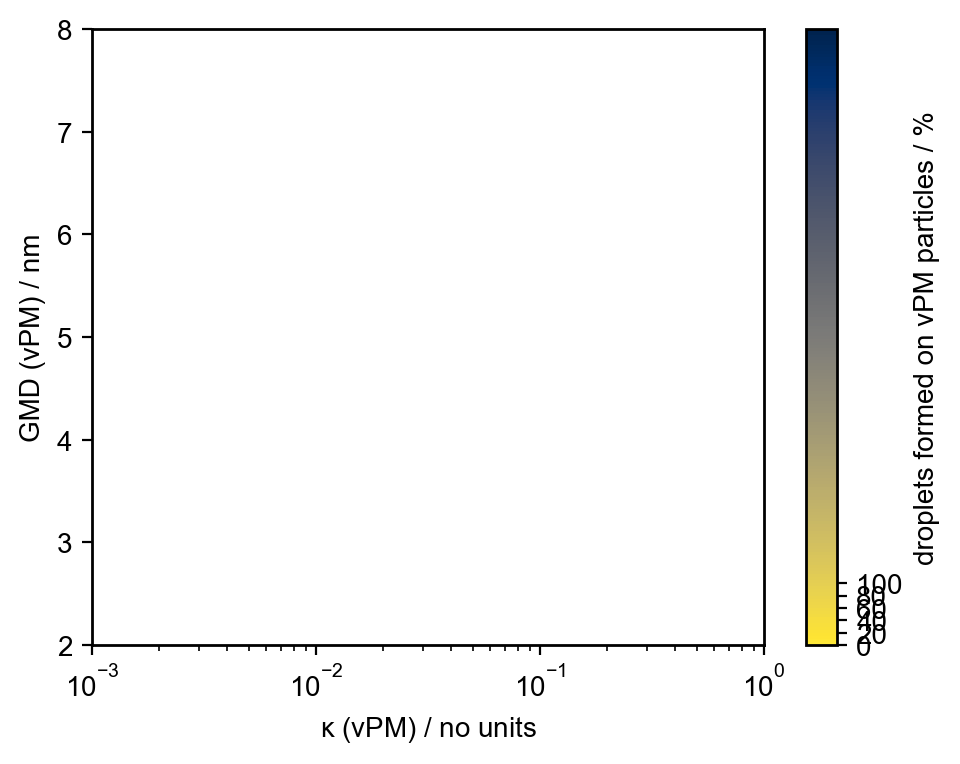

In [ ]:
# exploring vPM sensitivity (2/2)

%matplotlib inline
%config InlineBackend.figure_format='retina'

plt.rcParams['mathtext.default'] = 'regular'
plt.rcParams["font.family"] = "Arial"
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['axes.formatter.useoffset'] = False
plt.rcParams["font.size"] = 10

fig = plt.figure(figsize = (5, 4))
ax = fig.add_subplot(1, 1, 1)

import matplotlib.colors as mcolors
from matplotlib.ticker import ScalarFormatter

contour = plt.contourf(x, y/1e-9, z, levels = np.arange(0, 1000, 5), cmap = "cividis_r")

cbar = fig.colorbar(contour, ax = ax, label = 'droplets formed on vPM particles / %')
cbar.set_ticks([0, 20, 40, 60, 80, 100])

ax.set_xlabel('$\kappa$ (vPM) / no units')
ax.set_ylabel('GMD (vPM) / nm')

# ax.set_xlim([])
# ax.set_ylim([1, 10])

ax.set_xscale("log")
# ax.set_yscale("log")

# ax.set_xticks([1e2, 1e4, 1e6, 1e8, 1e10, 1e12, 1e14, 1e16])
# ax.set_yticks([1, 10, 100])

plt.subplots_adjust(left = 0.1, right = 0.94, bottom = 0.17, top = 0.94, wspace = 0.27, hspace = 0.2)
plt.savefig(f"/Users/jrp21/Desktop/new.png", dpi = 300)

plt.show()

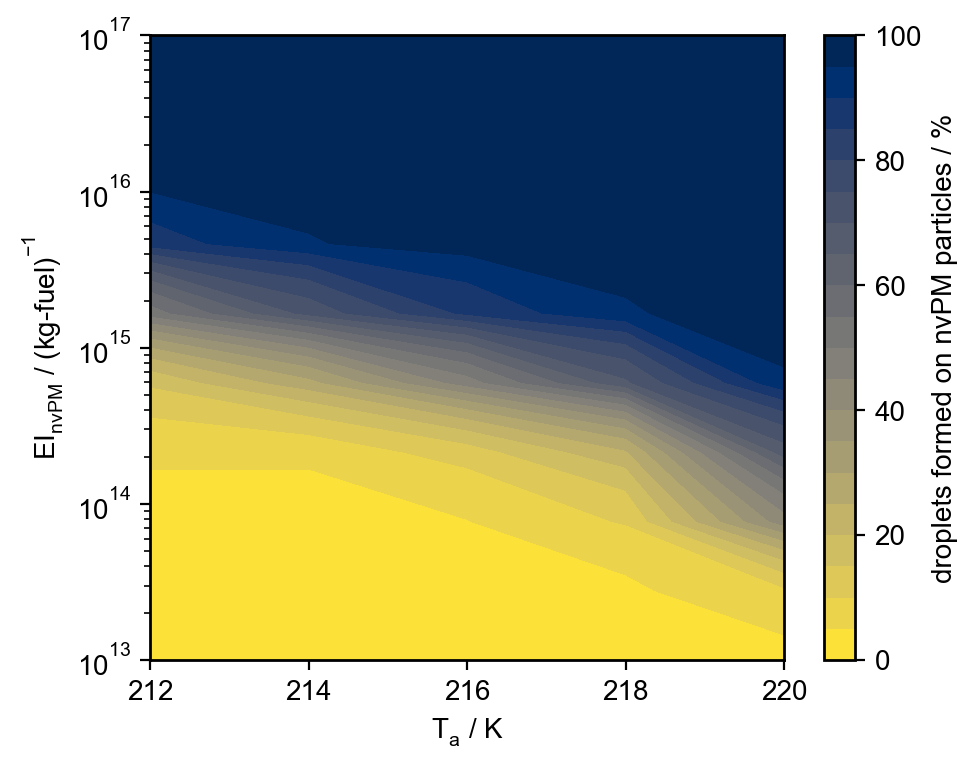

In [ ]:
# exploring T/nvPM sensitivity (1/1)
 
import matplotlib.pyplot as plt
import matplotlib.colors
import matplotlib as mpl

# Define contrail properties

T_a = 215.0 # ambient temperature / K
T_e = 600 # exhaust temperature
P0 = 22919.5 # (cruise) pressure, Pa 

# Define particle properties

n_ambient = 600 # number concentration of ambient particles / cm^-3
EI_nvPM = 1e15 # emission index of nvPM particles, particles per kg of fuel burned
EI_vPM = 1e17 # emission index of vPM particles, particles per kg of fuel burned

GMD_ambient, GSD_ambient, kappa_ambient = 30e-9, 1.6, 0.500001 # must specify the ambient mode with this kappa value (0.500001) otherwise the code will fail
GMD_nvPM, GSD_nvPM, kappa_nvPM = 30e-9, 2.0, 0.005
GMD_vPM, GSD_vPM, kappa_vPM = 1.5e-9, 1.4, 0.5
bins_nvPM, bins_ambient, bins_vPM = 30, 30, 50

# Define model properties

T_start = 270 # initial model (not the ambient temperature) temperature / K
dt = 0.001 # timestep / s
t_end = 0.5 # end time / s

# Dependent variables

T_a_array = np.linspace(212, 220, 5)
EI_nvPM_array = np.logspace(13, 17, 10)

x, y = np.meshgrid(T_a_array, EI_nvPM_array)

f_vectorized = np.vectorize(n_droplets)
z = f_vectorized(x, T_e, P0, 
               n_ambient, GMD_ambient, GSD_ambient, kappa_ambient, bins_ambient, 
               EI_vPM, GMD_vPM, GSD_vPM, kappa_vPM, bins_vPM,
               y, GMD_nvPM, GSD_nvPM, kappa_nvPM, bins_nvPM,
               T_start, dt, t_end)

# Plotting

%matplotlib inline
%config InlineBackend.figure_format='retina'

plt.rcParams['mathtext.default'] = 'regular'
plt.rcParams["font.family"] = "Arial"
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['axes.formatter.useoffset'] = False
plt.rcParams["font.size"] = 10

fig = plt.figure(figsize = (5, 4))
ax = fig.add_subplot(1, 1, 1)

import matplotlib.colors as mcolors
from matplotlib.ticker import ScalarFormatter

contour = plt.contourf(x, y, z, levels = np.arange(0, 105, 5), cmap = "cividis_r")

cbar = fig.colorbar(contour, ax = ax, label = 'droplets formed on nvPM particles / %')
cbar.set_ticks([0, 20, 40, 60, 80, 100])

ax.set_xlabel('T$_{a}$ / K')
ax.set_ylabel('EI$_{nvPM}$ / (kg-fuel)$^{-1}$')

# ax.set_xlim([])
# ax.set_ylim([1, 10])

# ax.set_xscale("log")
ax.set_yscale("log")

# ax.set_xticks([1e2, 1e4, 1e6, 1e8, 1e10, 1e12, 1e14, 1e16])
# ax.set_yticks([1, 10, 100])

plt.subplots_adjust(left = 0.1, right = 0.94, bottom = 0.17, top = 0.94, wspace = 0.27, hspace = 0.2)
plt.savefig(f"/Users/jrp21/Desktop/new.png", dpi = 300)

plt.tight_layout()

plt.show()

NameError: name 'x' is not defined

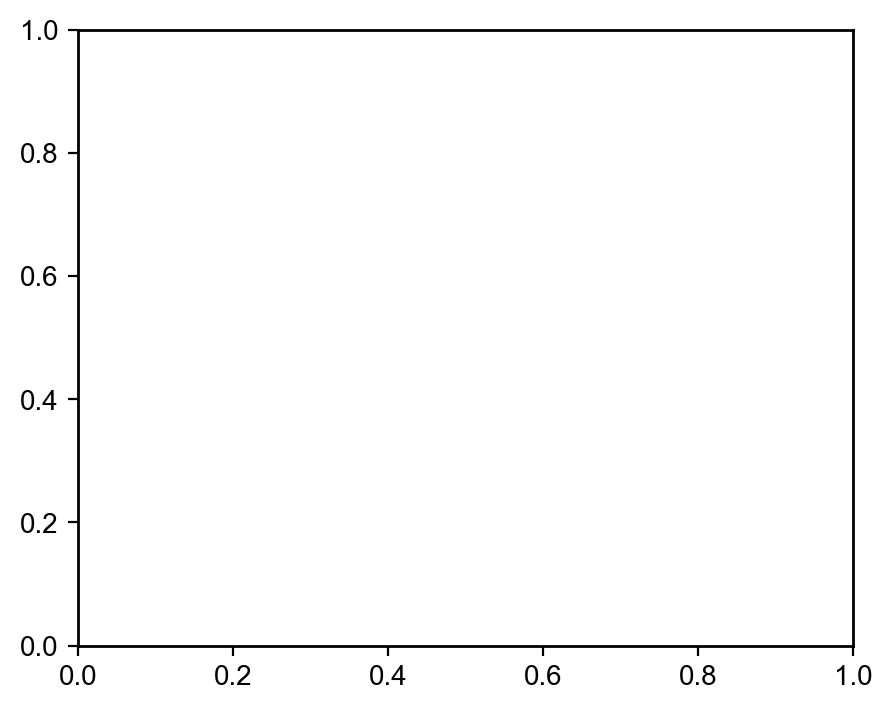

In [12]:
# Plotting

%matplotlib inline
%config InlineBackend.figure_format='retina'

plt.rcParams['mathtext.default'] = 'regular'
plt.rcParams["font.family"] = "Arial"
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['axes.formatter.useoffset'] = False
plt.rcParams["font.size"] = 10

fig = plt.figure(figsize = (5, 4))
ax = fig.add_subplot(1, 1, 1)

import matplotlib.colors as mcolors
from matplotlib.ticker import ScalarFormatter

contour = plt.contourf(x, y, z, levels = np.arange(0, 105, 5), cmap = "cividis")

cbar = fig.colorbar(contour, ax = ax, label = 'droplets formed on nvPM / %')
cbar.set_ticks([0, 20, 40, 60, 80, 100])

ax.set_xlabel('T$_{a}$ / K')
ax.set_ylabel('EI$_{nvPM}$ / (kg-fuel)$^{-1}$')

# ax.set_xlim([])
ax.set_ylim([1e13, 1e17])

# ax.set_xscale("log")
ax.set_yscale("log")

# ax.set_xticks([1e2, 1e4, 1e6, 1e8, 1e10, 1e12, 1e14, 1e16])
# ax.set_yticks([1, 10, 100])

plt.subplots_adjust(left = 0.1, right = 0.94, bottom = 0.17, top = 0.94, wspace = 0.27, hspace = 0.2)
plt.savefig(f"/Users/jrp21/Desktop/new.png", dpi = 300)

plt.tight_layout()

plt.show()

In [19]:
EI_nvPM_array = np.logspace(12, 16, 9)
EI_nvPM_array

array([1.00000000e+12, 3.16227766e+12, 1.00000000e+13, 3.16227766e+13,
       1.00000000e+14, 3.16227766e+14, 1.00000000e+15, 3.16227766e+15,
       1.00000000e+16])

0
1
2
3
4
5
6
7


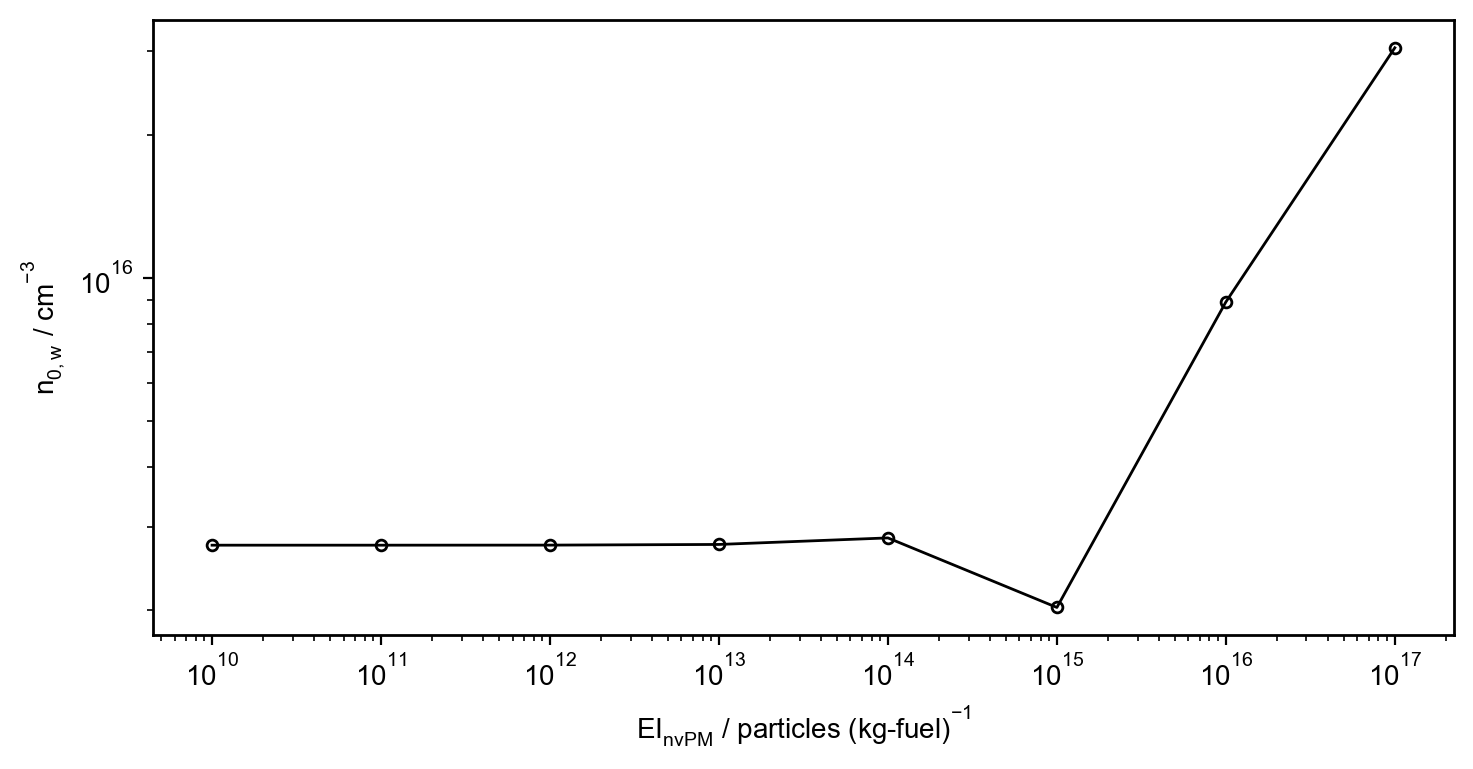

In [8]:
# iterating to find the droplet number concentration at peak supersaturation as a function of EI nvPM, including vPM in the calculations

from pyrcel import binned_activation

# Define contrail properties

T_a = 215.00 # ambient temperature / K
T_e = 600.0 # exhaust temperature
P0 = 22919.5 # (cruise) pressure, Pa 

RHi = 1.00 # ice saturation ratio 
G = 1.64 # contrail mixing line gradient

# Define particle properties

n_ambient = 600 # number concentration of ambient particles / cm^-3
EI_nvPM = 1e12 # emission index of nvPM particles, particles per kg of fuel burned
EI_vPM = 1e17 # emission index of vPM particles, particles per kg of fuel burned

GMD_ambient, GSD_ambient, kappa_ambient = 30.0e-9, 2.2, 0.500001 # must specify the ambient mode with this kappa value otherwise the code will fail
GMD_nvPM, GSD_nvPM, kappa_nvPM = 35e-9, 2.0, 0.005
GMD_vPM, GSD_vPM, kappa_vPM = 2.5e-09, 1.3, 0.5
bins_nvPM, bins_ambient, bins_vPM = 50, 50, 50

# Define model properties

T_start = 270.0 # initial model (not the ambient temperature) temperature / K
dt = 1e-4 # timestep / s
t_end = 1 # end time / s

# Call the model (returns maximum supersaturation as % and effective emission index of ice as particles per kg-fuel)

n_0_list = []

EI_nvPM_array = np.logspace(10, 17, 8)
# EI_nvPM_array = np.logspace(12, 16, 9) # after Roger Comments

for index, value in enumerate(EI_nvPM_array):

    print(index)

    n = n_droplets(T_a, T_e, P0, 
               n_ambient, GMD_ambient, GSD_ambient, kappa_ambient, bins_ambient, 
               EI_vPM, GMD_vPM, GSD_vPM, kappa_vPM, bins_vPM,
               value, GMD_nvPM, GSD_nvPM, kappa_nvPM, bins_nvPM,
               T_start, dt, t_end, RHi, G)
    
    n_0_list.append(n)

# plotting
    
%matplotlib inline
%config InlineBackend.figure_format='retina'

plt.rcParams['mathtext.default'] = 'regular'
plt.rcParams["font.family"] = "Arial"
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['axes.formatter.useoffset'] = False
plt.rcParams["font.size"] = 10

fig = plt.figure(figsize = (7.5, 4))

ax = fig.add_subplot(1, 1, 1)

ax.plot(EI_nvPM_array, n_0_list, linewidth = 1, color = "black")
ax.scatter(EI_nvPM_array, n_0_list, edgecolor = "black", color = "white", s = 15, linewidth = 1)

ax.set_xscale("log")
ax.set_yscale("log")

ax.set_ylabel("n$_{0, w}$" + " / cm$^{-3}$")
ax.set_xlabel("EI$_{ice}$ / particles (kg-fuel)$^{-1}$")
ax.set_xlabel("EI$_{nvPM}$ / particles (kg-fuel)$^{-1}$")

plt.tight_layout()
plt.show()

import pandas as pd

df = pd.DataFrame({'EInvPM': EI_nvPM_array, 'AEIice': n_0_list})
df.to_csv("/Users/jrp21/Desktop/data_with_vPM.csv", index=False)

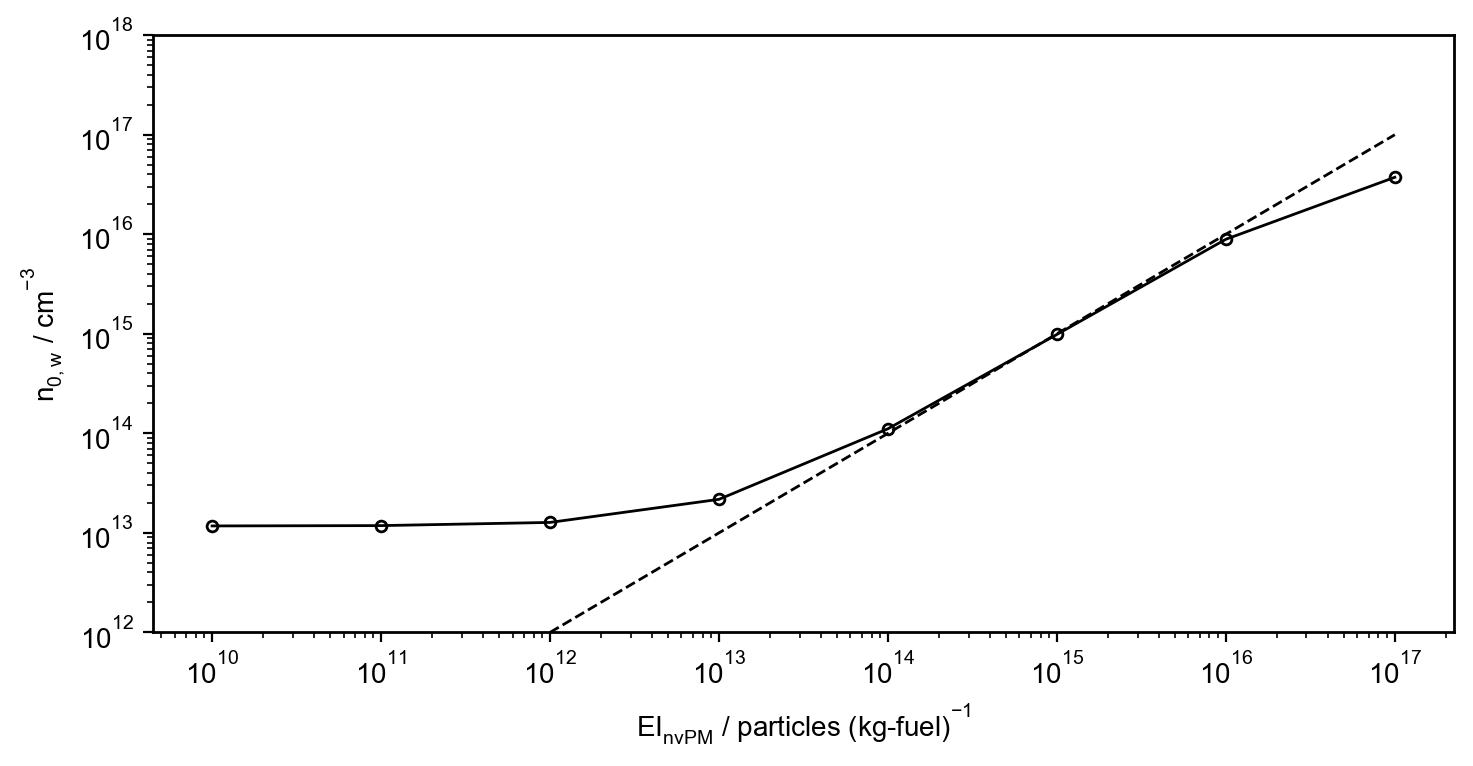

In [27]:
# plotting
    
%matplotlib inline
%config InlineBackend.figure_format='retina'

plt.rcParams['mathtext.default'] = 'regular'
plt.rcParams["font.family"] = "Arial"
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['axes.formatter.useoffset'] = False
plt.rcParams["font.size"] = 10

fig = plt.figure(figsize = (7.5, 4))

ax = fig.add_subplot(1, 1, 1)

ax.plot(EI_nvPM_array, n_0_list, linewidth = 1, color = "black")
ax.plot(EI_nvPM_array, EI_nvPM_array, linewidth = 1, color = "black", linestyle = "--")

ax.scatter(EI_nvPM_array, n_0_list, edgecolor = "black", color = "white", s = 15, linewidth = 1)

ax.set_xscale("log")
ax.set_yscale("log")

ax.set_ylim([1e12, 1e18])

ax.set_ylabel("n$_{0, w}$" + " / cm$^{-3}$")
ax.set_xlabel("EI$_{ice}$ / particles (kg-fuel)$^{-1}$")
ax.set_xlabel("EI$_{nvPM}$ / particles (kg-fuel)$^{-1}$")

plt.tight_layout()

plt.savefig(f"/Users/jrp21/Desktop/nvPM_sensitivity_analysis_water_and_ice_T_{T_a:.1f}.png", dpi = 500)

plt.show()

import pandas as pd

df = pd.DataFrame({'EInvPM': EI_nvPM_array, 'AEIice': n_0_list})
df.to_csv("/Users/jrp21/Desktop/data_without_vPM.csv", index=False)

In [ ]:
# looking at separable/inseparable equations (1/X)

from pyrcel import binned_activation

# Define contrail properties

T_a = 213.0 # ambient temperature / K
T_e = 600 # exhaust temperature
P0 = 22919.5 # (cruise) pressure, Pa 

# Define particle properties

n_ambient = 600 # number concentration of ambient particles / cm^-3
EI_nvPM = 1e13 # emission index of nvPM particles, particles per kg of fuel burned
EI_vPM = 1e17 # emission index of vPM particles, particles per kg of fuel burned

GMD_ambient, GSD_ambient, kappa_ambient = 30e-9, 1.6, 0.500001 # must specify the ambient mode with this kappa value (0.500001) otherwise the code will fail
GMD_nvPM, GSD_nvPM, kappa_nvPM = 30e-9, 2.0, 0.005
GMD_vPM, GSD_vPM, kappa_vPM = 2e-9, 1.4, 0.005

bins_nvPM, bins_ambient, bins_vPM = 30, 30, 100

# Define model properties

T_start = 270 # initial model (not the ambient temperature) temperature / K
dt = 0.0003 # timestep / s
t_end = 0.5 # end time / s

n_0_list_both = []
n_0_list_vPM = []
n_0_list_nvPM = []

T_array = np.linspace(210, 222, 5)

for index, value in enumerate(T_array):

    print(index)

    n_both = n_droplets(value, T_e, P0, 
               n_ambient, GMD_ambient, GSD_ambient, kappa_ambient, bins_ambient, 
               EI_vPM, GMD_vPM, GSD_vPM, kappa_vPM, bins_vPM,
               EI_nvPM, GMD_nvPM, GSD_nvPM, kappa_nvPM, bins_nvPM,
               T_start, dt, t_end)
    
    n_nvPM = n_droplets(value, T_e, P0, 
               0, GMD_ambient, GSD_ambient, kappa_ambient, bins_ambient, 
               0, GMD_vPM, GSD_vPM, kappa_vPM, bins_vPM,
               EI_nvPM, GMD_nvPM, GSD_nvPM, kappa_nvPM, bins_nvPM,
               T_start, dt, t_end)
    
    n_vPM = n_droplets(value, T_e, P0, 
            n_ambient, GMD_ambient, GSD_ambient, kappa_ambient, bins_ambient, 
            EI_vPM, GMD_vPM, GSD_vPM, kappa_vPM, bins_vPM,
            0, GMD_nvPM, GSD_nvPM, kappa_nvPM, bins_nvPM,
            T_start, dt, t_end)
    
    n_0_list_both.append(n_both)
    n_0_list_vPM.append(n_vPM)
    n_0_list_nvPM.append(n_nvPM)

print("done")

n_0_array_both = np.array(n_0_list_both)
n_0_array_vPM = np.array(n_0_list_vPM)
n_0_array_nvPM = np.array(n_0_list_nvPM)

0
1
2
3
4
done


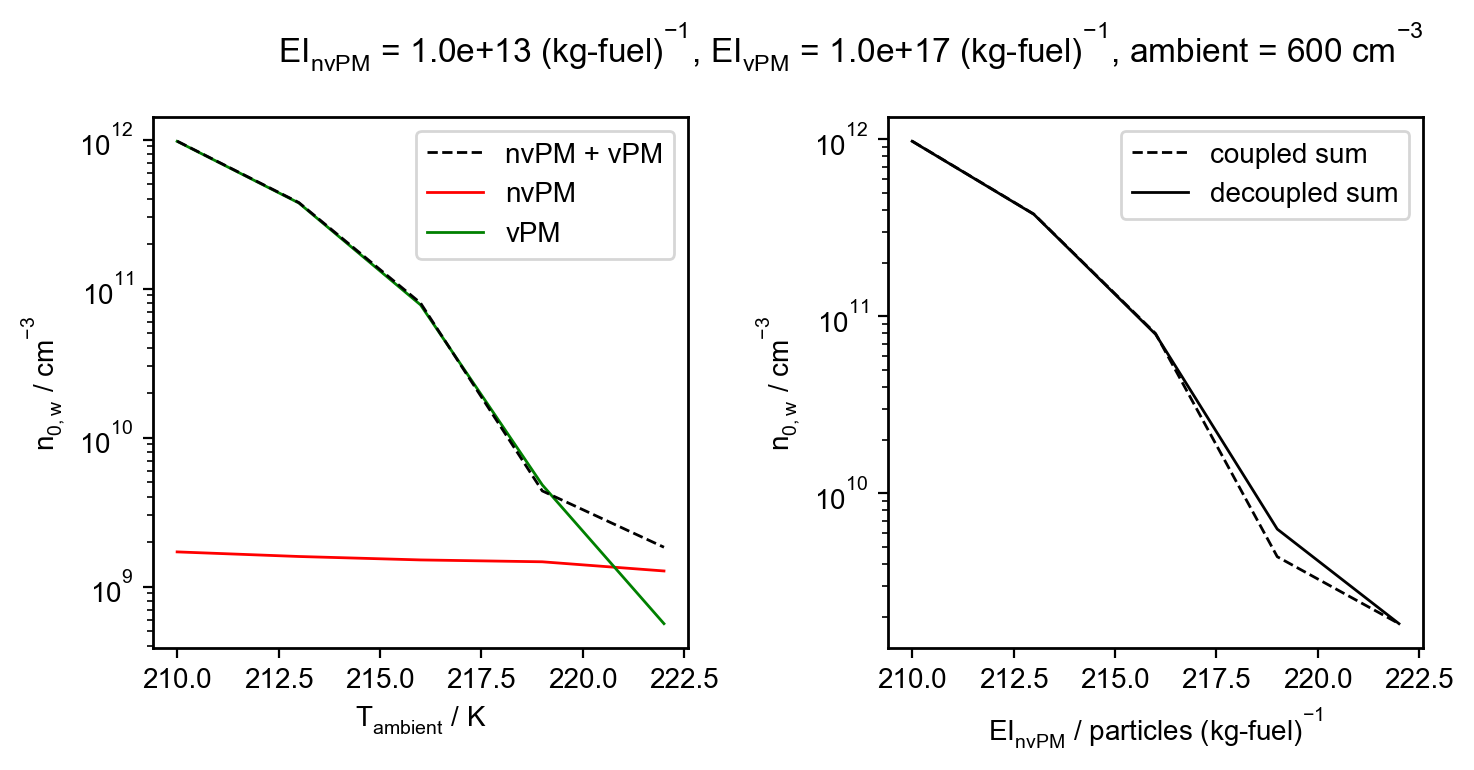

In [ ]:
# looking at separable/inseparable equations (2/X)

# plotting
    
%matplotlib inline
%config InlineBackend.figure_format='retina'

plt.rcParams['mathtext.default'] = 'regular'
plt.rcParams["font.family"] = "Arial"
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['axes.formatter.useoffset'] = False
plt.rcParams["font.size"] = 10

fig = plt.figure(figsize = (7.5, 4))

ax = fig.add_subplot(1, 2, 1)

# ax.plot(EI_nvPM_array, EI_nvPM_array, linewidth = 1, color = "black")

ax.plot(T_array, n_0_array_both, linewidth = 1, color = "black", linestyle = "--", alpha = 1, zorder = 10, label = "nvPM + vPM")
ax.plot(T_array, n_0_array_nvPM, linewidth = 1, color = "red", linestyle = "-", alpha = 1, label = "nvPM")
ax.plot(T_array, n_0_array_vPM, linewidth = 1, color = "green", linestyle = "-", alpha = 1, label = "vPM")

ax.set_yscale("log")

# ax.set_ylim([1e12, 1e16])

ax.set_ylabel("n$_{0, w}$" + " / cm$^{-3}$")
ax.set_xlabel("T$_{{ambient}}$ / K")

ax.legend()

ax1 = fig.add_subplot(1, 2, 2)

ax1.plot(T_array, n_0_array_both, linewidth = 1, color = "black", linestyle = "--", alpha = 1, zorder = 10, label = "coupled sum")
ax1.plot(T_array, n_0_array_nvPM + n_0_array_vPM, linewidth = 1, color = "black", alpha = 1, label = "decoupled sum")

def max_or_average_np(a, b, x):
    max_vals = np.maximum(a, b)
    mask = max_vals < x
    c = np.where(mask, max_vals, (a + b))
    return c

x = n_0_array_nvPM[np.argmin(np.abs(n_0_array_nvPM - n_0_array_vPM))]

# ax1.plot(T_array, max_or_average_np(n_0_array_nvPM, n_0_array_vPM, x), linewidth = 1, color = "red", alpha = 1, label = "test")

ax1.set_yscale("log")

# ax1.set_ylim([1e12, 1e16])

ax1.set_ylabel("n$_{0, w}$" + " / cm$^{-3}$")
ax1.set_xlabel("EI$_{ice}$ / particles (kg-fuel)$^{-1}$")
ax1.set_xlabel("EI$_{nvPM}$ / particles (kg-fuel)$^{-1}$")

ax1.legend()

plt.title(f"EI$_{{nvPM}}$ = {EI_nvPM:.1e} (kg-fuel)$^{{-1}}$, EI$_{{vPM}}$ = {EI_vPM:.1e} (kg-fuel)$^{{-1}}$, ambient = {n_ambient:.0f} cm$^{{-3}}$", pad = 20, loc = "right")

plt.tight_layout()

plt.savefig(f"/Users/jrp21/Desktop/coupled_decoupled_sum_{EI_nvPM:.1e}_vPM_{EI_vPM:.1e}_test.png", dpi = 500)

plt.show()